# Deep mutational scanning of Perth/2009 (H3N2) HA

## Overview

We performed deep mutational scanning of **hemagglutinin (HA)** from the **A/Perth/16/2009(H3N2)** influenza virus strain. This is analysis of the data generated from the DMS experiments using the [`dms_tools2`](https://github.com/jbloomlab/dms_tools2) software.

## Experimental summary

The goal of these experiments was to measure the effect of all possible single amino-acid mutations to HA on viral replication in cell culture. We created triplicate codon-mutant libraries of the Perth/2009 H3 HA, rescued virus libraries using the helper virus approach described in [Doud and Bloom (2016)](http://www.mdpi.com/1999-4915/8/6/155), and passaged the generated mutant virus libraries at low multiplicity of infection (MOI) in cell culture to select for functional variants of HA.

For each library, there is a _mutDNA-#_ sample representing the plasmid mutant library, and a _mutvirus-#_ sample representing the mutant viruses after passaging. Note that library 3 was passaged in technical replicate, so there are two _mutvirus_ samples (_3-1_ and _3-2_) for library 3. There is also a single set of wild-type controls for the unmutated plasmid and the corresponding virus, referred to as _wtDNA_ and _wtvirus_.

As described previously, all of the plasmid and virus samples were deep sequenced using a barcoded-subamplicon sequencing approach to reduce the standard Illumina sequencing error rate.

## Goals

In this analysis, we will try to achieve the following goals:
1. Infer the site-specific amino-acid preferences for H3 and use these preferences to improve the phylogenetic fit of natural H3 sequences
2. Determine if the preferences reveal lineage-specific patterns in mutational effects in human H3N2 evolution
3. Investigate the extent of mutational shifts between two diverged HA homologs

# Section 1: Infer H3 site-specific amino-acid preferences

## Import modules, define directories

In [1]:
import os
import re
import glob
import itertools
import random
import pandas as pd
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as mpatches
import seaborn as sns
import collections
import joypy
import statsmodels.stats.multitest

import Bio
import Bio.Phylo
import pickle
import gzip
import io
import json
import urllib
import codecs
from scipy.interpolate import splev, splrep
from collections import defaultdict

import dms_tools2
import dms_tools2.sra
import dms_tools2.plot
import dms_tools2.dssp
import dms_tools2.prefs
import dms_tools2.compareprefs
from dms_tools2.ipython_utils import showPDF
import warnings
warnings.simplefilter('ignore') # don't print warnings to avoid clutter in notebook
from IPython.display import display, HTML, Markdown
# from pymodules.utils import * # custom modules for this analysis

print("Using dms_tools2 version {0}".format(dms_tools2.__version__))

# CPUs to use, should not exceed the number you request with slurm
ncpus = 14

# do we use existing results or generate everything new?
use_existing = 'yes'

inputdir = './data/'
resultsdir = './results/'
fastqdir = os.path.join(resultsdir, 'FASTQ_files/')
countsdir = os.path.join(resultsdir, 'codoncounts/')
prefsdir = os.path.join(resultsdir, 'preferences/')
renumberedprefsdir = os.path.join(resultsdir, 'H3renumberedprefs/')
phydmsdir = os.path.join(resultsdir, 'phydms_analysis/')
logodir = os.path.join(resultsdir, 'logoplots/')
WSNprefsdir = os.path.join(resultsdir, 'WSNpreferences/')
prefsdistdir = os.path.join(resultsdir, 'prefsdist/')
plotsdir = os.path.join(resultsdir, 'plots/')

no display found. Using non-interactive Agg backend


/home/jmlee34/.local/lib/python3.4/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/app/python3/3.4.1/lib/python3.4/importlib/_bootstrap.py:321: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  return f(*args, **kwds)


Using dms_tools2 version 2.2.0


## Define the samples

Here we will create a `pandas` dataframe to define the samples with the following information:
1. The **name** of each sample.
2. The SRA run accession for the deep sequencing data.

In [2]:
samples = pd.DataFrame.from_records(
        [('mutDNA-1', 'SRR6364210'),
         ('mutDNA-2', 'SRR6364209'),
         ('mutDNA-3', 'SRR6364212'),
         ('mutvirus-1', 'SRR6364216'),
         ('mutvirus-2', 'SRR6364215'),
         ('mutvirus-3-1', 'SRR6364211'),
         ('mutvirus-3-2', 'SRR6364208'),
         ('wtDNA', 'SRR6364214'),
         ('wtvirus', 'SRR6364213')],
        columns=['name', 'run']
        )

## Download `FASTQ` files from the SRA

All of the FASTQ files are on the Sequence Read Archive (SRA) under the run numbers listed in the `samples` dataframe defined above. To download these files, we just pass that dataframe to the [dms_tools2.sra.fastqFromSRA](https://jbloomlab.github.io/dms_tools2/dms_tools2.sra.html#dms_tools2.sra.fastqFromSRA) function. Note that this requires the `fastq-dump` and `aspera` programs to be installed on the computer you are using at the specified paths.

In [3]:
print('Downloading FASTQ files from the SRA...')
dms_tools2.sra.fastqFromSRA(
        samples=samples,
        fastq_dump='fastq-dump', # valid path to this program on the Hutch server
        fastqdir=fastqdir,
        aspera=(
            '/app/aspera-connect/3.5.1/bin/ascp', # valid path to ascp on Hutch server
            '/app/aspera-connect/3.5.1/etc/asperaweb_id_dsa.openssh' # Aspera key on Hutch server
            ),
        overwrite={'no':True, 'yes':False}[use_existing],
        no_downloads=True,
        )
print('Completed download of FASTQ files from the SRA')

print('Here are the names of the downloaded files now found in {0}'.format(fastqdir))
display(HTML(samples.to_html(index=False)))

Completed download of FASTQ files from the SRA
Here are the names of the downloaded files now found in ./results/FASTQ_files/


name,run,R1,R2
mutDNA-1,SRR6364210,mutDNA-1_R1.fastq.gz,mutDNA-1_R2.fastq.gz
mutDNA-2,SRR6364209,mutDNA-2_R1.fastq.gz,mutDNA-2_R2.fastq.gz
mutDNA-3,SRR6364212,mutDNA-3_R1.fastq.gz,mutDNA-3_R2.fastq.gz
mutvirus-1,SRR6364216,mutvirus-1_R1.fastq.gz,mutvirus-1_R2.fastq.gz
mutvirus-2,SRR6364215,mutvirus-2_R1.fastq.gz,mutvirus-2_R2.fastq.gz
mutvirus-3-1,SRR6364211,mutvirus-3-1_R1.fastq.gz,mutvirus-3-1_R2.fastq.gz
mutvirus-3-2,SRR6364208,mutvirus-3-2_R1.fastq.gz,mutvirus-3-2_R2.fastq.gz
wtDNA,SRR6364214,wtDNA_R1.fastq.gz,wtDNA_R2.fastq.gz
wtvirus,SRR6364213,wtvirus_R1.fastq.gz,wtvirus_R2.fastq.gz


## Align deep sequencing data and count mutations

We have employed a barcoded-subamplicon sequencing approach to deep sequence the samples to high accuracy. We will now analyze the sequence data using the `dms2_batch_bcsubamp` program.

In [4]:
# Reference coding sequence of Perth/2009 HA; from plasmid #1535 pICR2-Perth09-HA
refseq = './data/Perth09_HA_reference.fa'

# Temporary align specs
alignspecs = ' '.join(['1,285,38,40', '286,567,33,34', '568,852,34,30', 
                       '853,1137,34,31', '1138,1422,36,29', '1423,1701,39,44'])

# write sample information to a batch file for dms2_batch_bcsubamplicons
countsbatchfile = os.path.join(countsdir, 'batch.csv')
samples.to_csv(countsbatchfile, index=False)

print('\nNow running dms2_batch_bcsubamp...')
log = !dms2_batch_bcsubamp \
        --batchfile {countsbatchfile} \
        --refseq {refseq} \
        --alignspecs {alignspecs} \
        --outdir {countsdir} \
        --summaryprefix summary \
        --R1trim 200 --R2trim 161 \
        --fastqdir {fastqdir} \
        --ncpus {ncpus} \
        --use_existing {use_existing}

print('Completed dms2_batch_bcsubamp.')


Now running dms2_batch_bcsubamp...
Completed dms2_batch_bcsubamp.


In [5]:
!ls {countsdir}/*_codoncounts.csv

./results/codoncounts//mutDNA-1_codoncounts.csv
./results/codoncounts//mutDNA-2_codoncounts.csv
./results/codoncounts//mutDNA-3_codoncounts.csv
./results/codoncounts//mutvirus-1_codoncounts.csv
./results/codoncounts//mutvirus-2_codoncounts.csv
./results/codoncounts//mutvirus-3-1_codoncounts.csv
./results/codoncounts//mutvirus-3-2_codoncounts.csv
./results/codoncounts//wtDNA_codoncounts.csv
./results/codoncounts//wtvirus_codoncounts.csv


In [6]:
countsplotprefix = os.path.join(countsdir, 'summary')

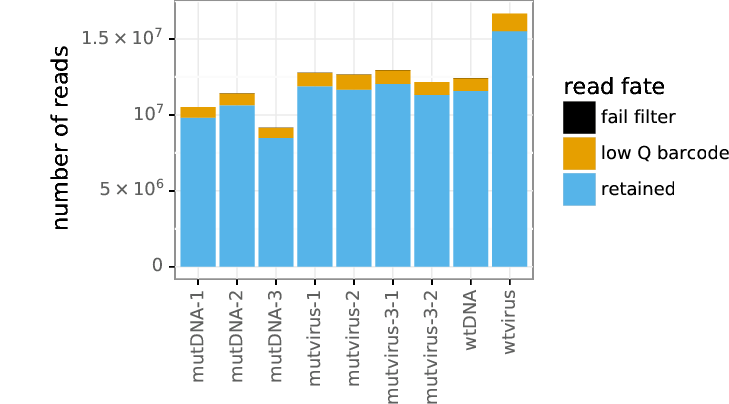

In [7]:
showPDF(countsplotprefix + '_readstats.pdf', width=500)

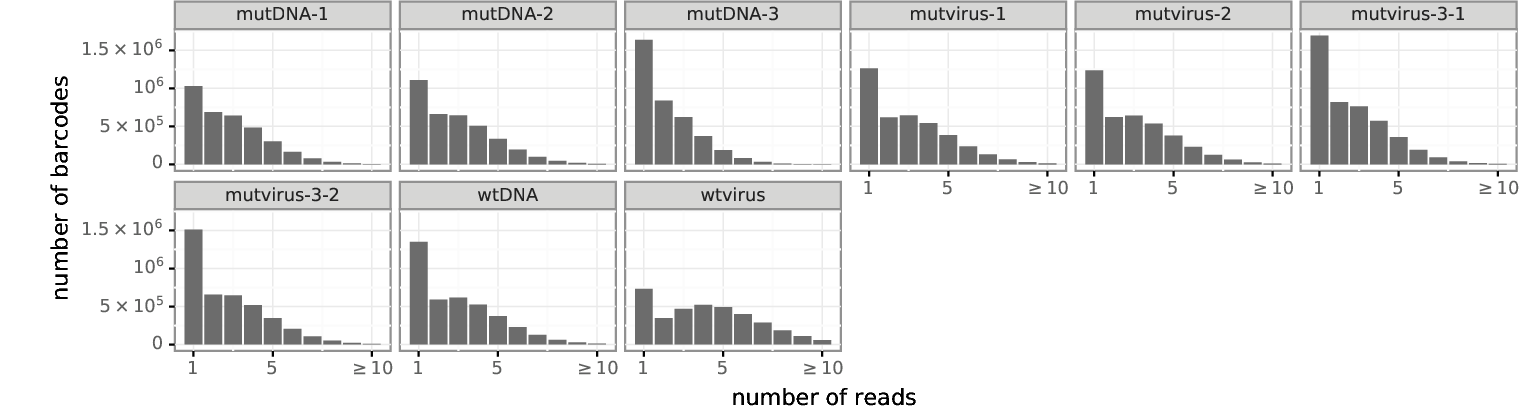

In [8]:
showPDF(countsplotprefix + '_readsperbc.pdf')

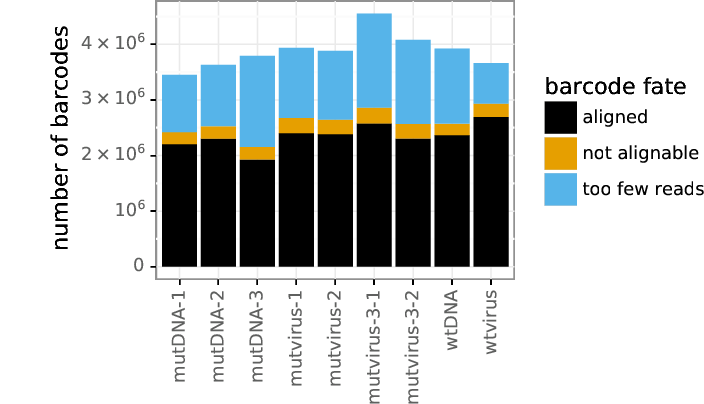

In [9]:
showPDF(countsplotprefix + '_bcstats.pdf', width=500)

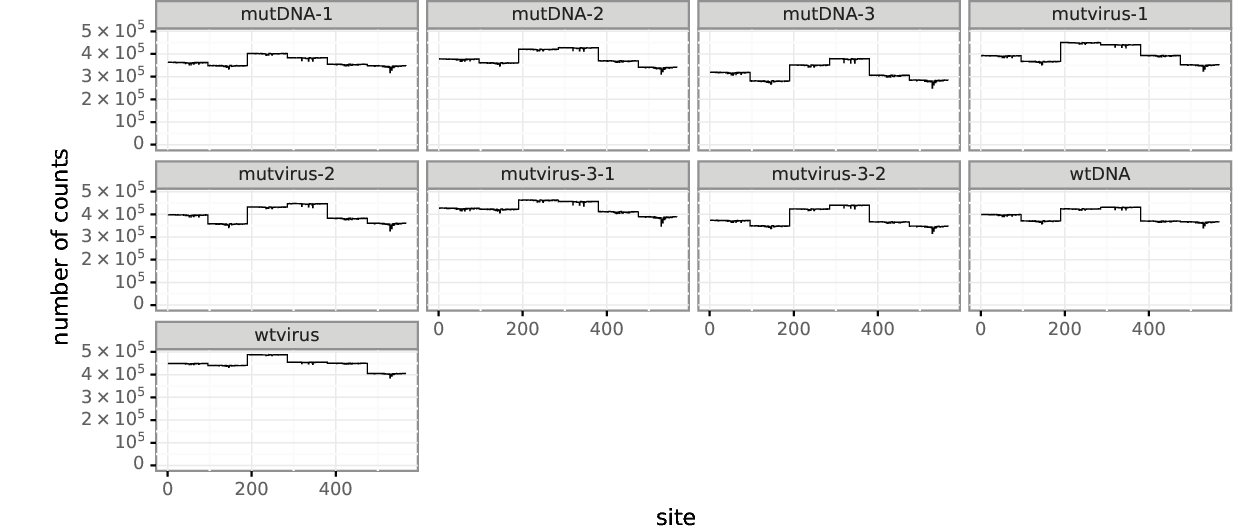

In [10]:
showPDF(countsplotprefix + '_depth.pdf')

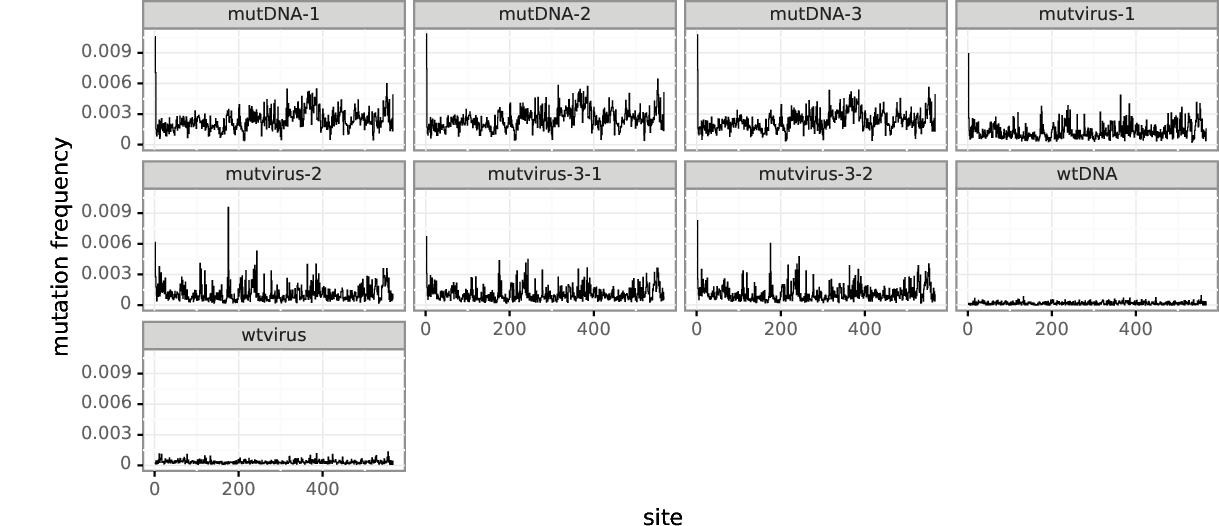

In [11]:
showPDF(countsplotprefix + '_mutfreq.pdf')

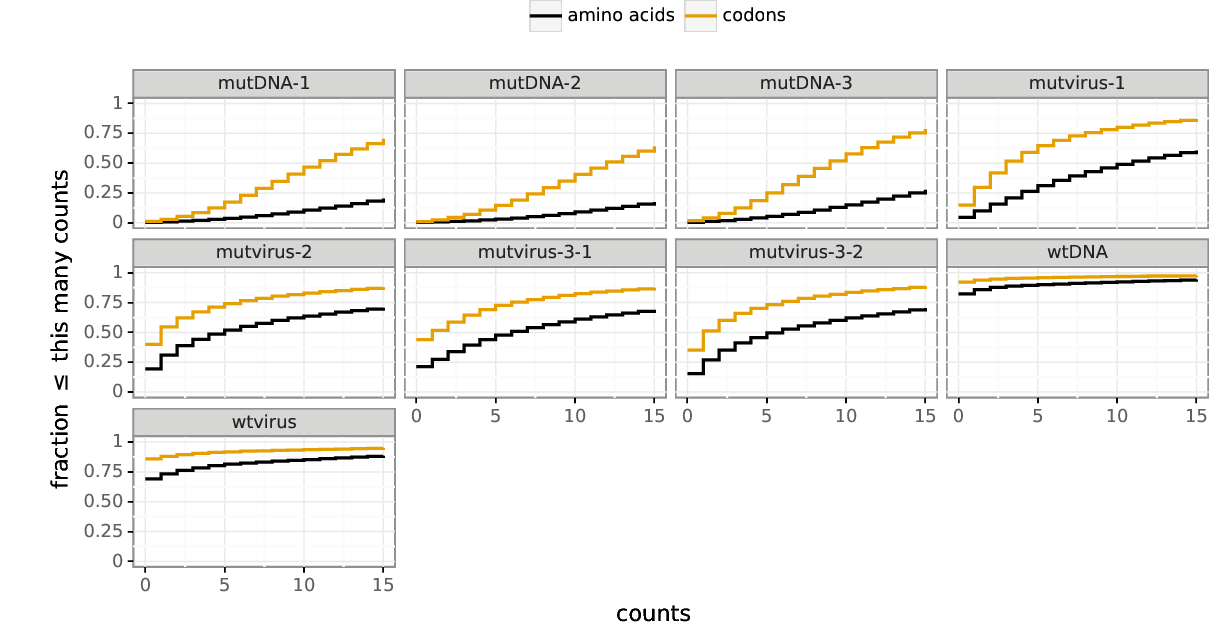

In [12]:
showPDF(countsplotprefix + '_cumulmutcounts.pdf')

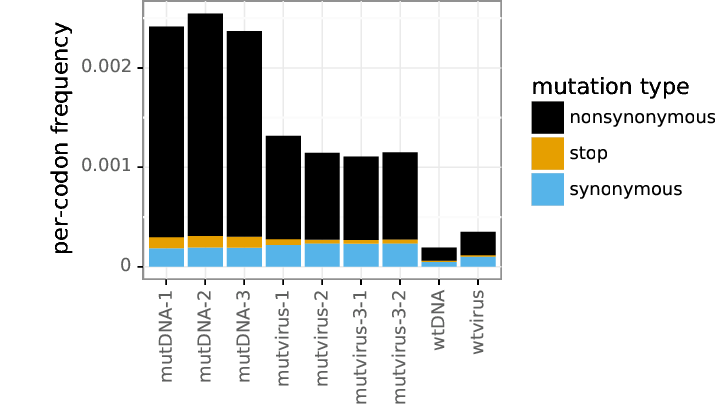

In [13]:
showPDF(countsplotprefix + '_codonmuttypes.pdf', width=500)

In [6]:
codonmuttypes = pd.read_csv(countsplotprefix + '_codonmuttypes.csv').sort_index(axis=1)
display(HTML(codonmuttypes.to_html(index=False)))

name,nonsynonymous,stop,synonymous
mutDNA-1,0.002118,0.000112,0.000186
mutDNA-2,0.002237,0.000117,0.000193
mutDNA-3,0.002068,0.000112,0.000191
mutvirus-1,0.001039,0.000059,0.000219
mutvirus-2,0.000875,0.000036,0.000235
mutvirus-3-1,0.000838,0.000039,0.000232
mutvirus-3-2,0.000876,0.000040,0.000235
wtDNA,0.000130,0.000015,0.000047
wtvirus,0.000233,0.000015,0.000102


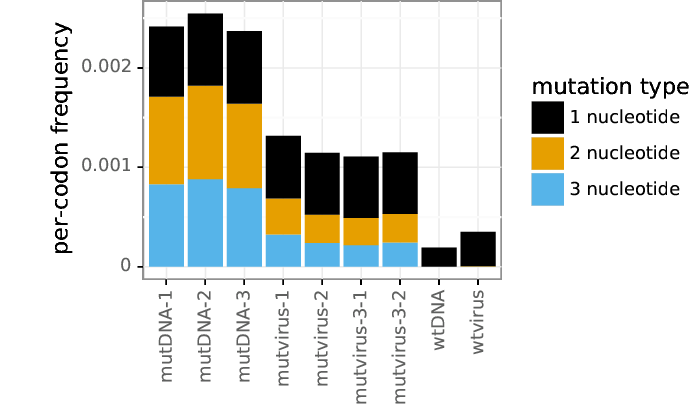

In [15]:
showPDF(countsplotprefix + '_codonntchanges.pdf', width=500)

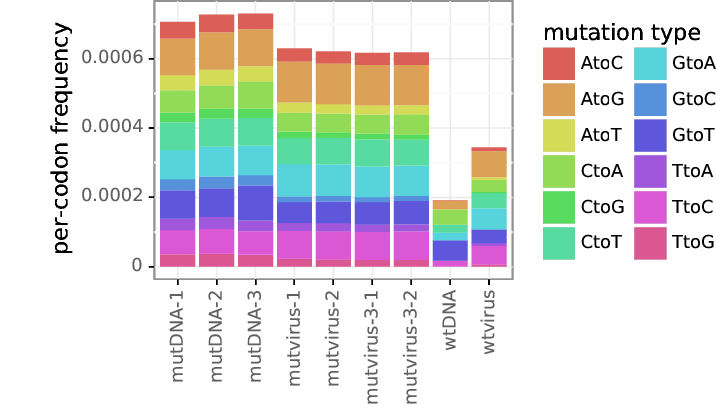

In [16]:
showPDF(countsplotprefix + '_singlentchanges.pdf', width=500)

# Infer the site-specific amino-acid preferences

In [5]:
# create batch file for dms2_batch_prefs
prefsbatch = pd.DataFrame(
        columns=['name', 'pre', 'post', 'errpre', 'errpost'],
        data=[('replicate-1', 'mutDNA-1', 'mutvirus-1', 'wtDNA', 'wtvirus'),
              ('replicate-2', 'mutDNA-2', 'mutvirus-2', 'wtDNA', 'wtvirus'),
              ('replicate-3-1', 'mutDNA-3', 'mutvirus-3-1', 'wtDNA', 'wtvirus'), 
              ('replicate-3-2', 'mutDNA-3', 'mutvirus-3-2', 'wtDNA', 'wtvirus')]
        )
prefsbatchfile = os.path.join(prefsdir, 'batch.csv')
print("Here is the batch file that we write to CSV format to use as input:")
display(HTML(prefsbatch.to_html(index=False)))
prefsbatch.to_csv(prefsbatchfile, index=False)

print("Running dms2_batch_prefs...")
log = !dms2_batch_prefs \
        --indir {countsdir} \
        --batchfile {prefsbatchfile} \
        --outdir {prefsdir} \
        --summaryprefix summary \
        --use_existing {use_existing} 
print("Completed running dms2_batch_prefs")

Here is the batch file that we write to CSV format to use as input:


name,pre,post,errpre,errpost
replicate-1,mutDNA-1,mutvirus-1,wtDNA,wtvirus
replicate-2,mutDNA-2,mutvirus-2,wtDNA,wtvirus
replicate-3-1,mutDNA-3,mutvirus-3-1,wtDNA,wtvirus
replicate-3-2,mutDNA-3,mutvirus-3-2,wtDNA,wtvirus


Running dms2_batch_prefs...
Completed running dms2_batch_prefs


In [8]:
!ls {prefsdir}/*_prefs.csv

./results/preferences//renum_replicate-1_prefs.csv
./results/preferences//renum_replicate-2_prefs.csv
./results/preferences//renum_replicate-3_prefs.csv
./results/preferences//replicate-1_prefs.csv
./results/preferences//replicate-2_prefs.csv
./results/preferences//replicate-3-1_prefs.csv
./results/preferences//replicate-3-2_prefs.csv
./results/preferences//replicate-3_prefs.csv


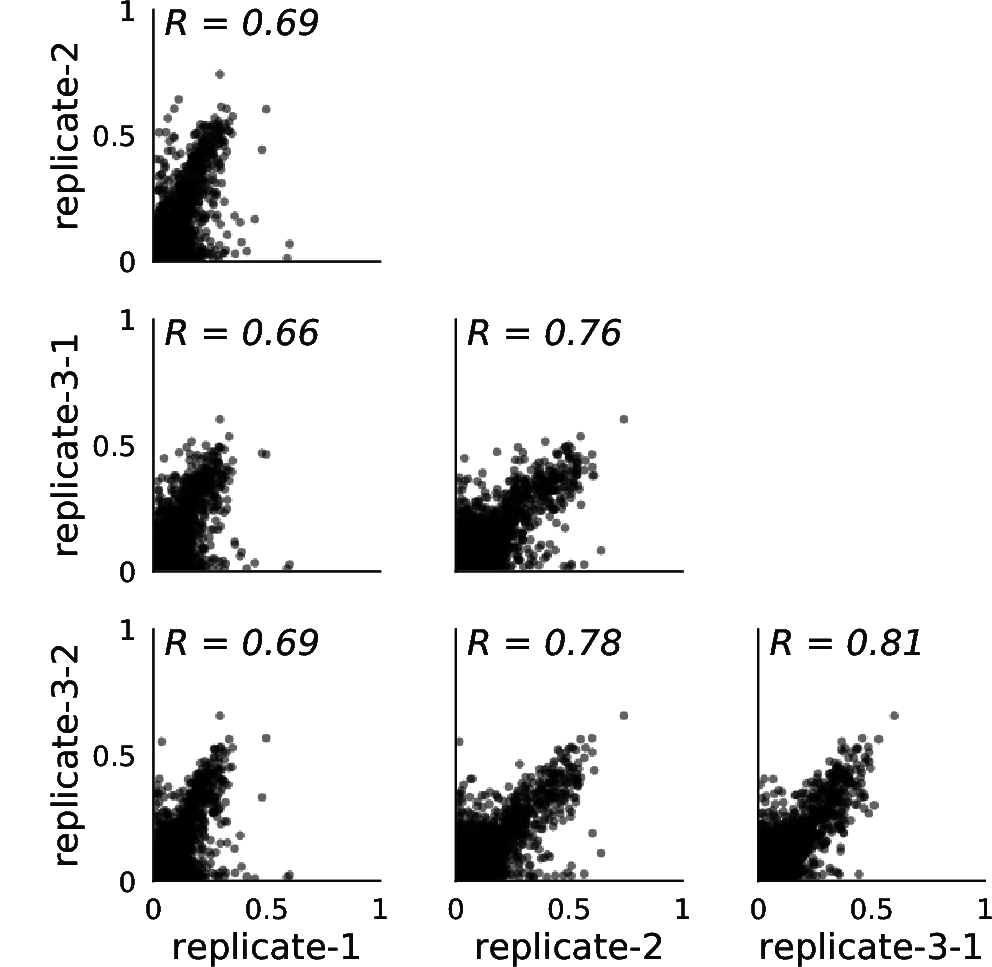

In [19]:
showPDF(os.path.join(prefsdir, 'summary_prefscorr.pdf'), width=300)

# Renumber preferences to H3 numbering

We will now renumber the preferences from sequential (1, 2, ... starting from the initial Met) to H3 numbering. 
The signal peptide is numbered with negative values, and the HA1 and HA2 subunits are numbered separately. 
This numbering scheme is based on an alignment to a PDB structure for an H3 HA [4HMG](https://www.rcsb.org/pdb/explore/explore.do?structureId=4HMG). 
We will use:
1. The [./data/H3renumbering_scheme.csv](./data/H3renumbering_scheme.csv) file to convert the sequential numbers into the H3 numbering scheme
2. The [dms_tools2.utils.renumberSites](https://jbloomlab.github.io/dms_tools2/dms_tools2.utils.html#dms_tools2.utils.renumberSites) function to renumber the codon counts files

The renumbered files will be created in a new `renumberedprefs` directory and will possess the same names as the original preferences files created from `dms2_batch_bcsuabmp` above.

In [6]:
renumberfile = './data/H3renumbering_scheme.csv'

# preferences files to renumber
prefsfiles = glob.glob('{0}/*prefs.csv'.format(prefsdir))

dms_tools2.utils.renumberSites(renumberfile, prefsfiles, missing='drop', 
        outdir=renumberedprefsdir)

In [7]:
avgprefs = os.path.join(renumberedprefsdir, 'summary_avgprefs.csv')
avgprefs_seqnum = os.path.join(prefsdir, 'summary_avgprefs.csv')

# Fit preferences to the evolution of natural H3 sequences

We will now use the preferences inferred above to describe the natural evolution of human H3N2 and swine H3N2 influenza viruses.

In [8]:
print("Using the following version of phydms:")
!phydms -v

raxmlpath = 'raxmlHPC-SSE3'
hosts = ['human', 'swine']

for host in hosts:
    alignment = './data/H3_{0}_alignment.fa'.format(host)
    modelcomparison = '{0}/{1}_modelcomparison.md'.format(phydmsdir, host)
    if use_existing == 'yes' and os.path.isfile(modelcomparison):
        print('Results of phydms analysis for {0} alignment already exist.'.format(host))
    else:
        print('Running phydms_comprehensive...')
        outprefix = '{0}/{1}'.format(phydmsdir, host)
        log = !phydms_comprehensive {outprefix} {alignment} {avgprefs_seqnum} --raxml {raxmlpath} --omegabysite
        print('Analysis for {0} alignment complete.'.format(host))

Using the following version of phydms:
phydms 2.2.0
Results of phydms analysis for human alignment already exist.
Results of phydms analysis for swine alignment already exist.


In [9]:
for host in hosts:
    print('This is the model comparison using a {0} alignment:'.format(host))
    modelcomparison = '{0}/{1}_modelcomparison.md'.format(phydmsdir, host)
    display(Markdown(modelcomparison))

This is the model comparison using a human alignment:


| Model                           | deltaAIC | LogLikelihood | nParams | ParamValues                                   |
|---------------------------------|----------|---------------|---------|-----------------------------------------------|
| ExpCM_summary_avgprefs          | 0.00     | -8439.33      | 6       | beta=2.44, kappa=5.78, omega=0.91             |
| YNGKP_M5                        | 2166.06  | -9516.36      | 12      | alpha_omega=0.30, beta_omega=0.84, kappa=5.10 |
| averaged_ExpCM_summary_avgprefs | 2504.18  | -9691.42      | 6       | beta=0.68, kappa=5.58, omega=0.32             |
| YNGKP_M0                        | 2607.92  | -9738.29      | 11      | kappa=5.05, omega=0.31                        |

This is the model comparison using a swine alignment:


| Model                           | deltaAIC | LogLikelihood | nParams | ParamValues                                   |
|---------------------------------|----------|---------------|---------|-----------------------------------------------|
| ExpCM_summary_avgprefs          | 0.00     | -9042.21      | 6       | beta=2.38, kappa=6.05, omega=0.72             |
| YNGKP_M5                        | 2387.82  | -10230.12     | 12      | alpha_omega=0.35, beta_omega=1.30, kappa=5.26 |
| averaged_ExpCM_summary_avgprefs | 2702.52  | -10393.47     | 6       | beta=0.71, kappa=5.73, omega=0.25             |
| YNGKP_M0                        | 2864.72  | -10469.57     | 11      | kappa=5.12, omega=0.24                        |

## Display preferences as a rescaled logoplot

I will use the rescaling parameter ( $\beta$ ) from `phydms_comprehensive` to create logoplots of rescaled preferences.
First, I will read in the beta values from the `ExpCM *_modelparams.txt` file.

In [10]:
params_file = open('{0}/human_ExpCM_summary_avgprefs_modelparams.txt'.format(phydmsdir), 'r')
params_lst = [line.rstrip() for line in params_file.readlines()]
params_file.close()
beta = float([line for line in params_lst if 'beta' in line][0][7:])
print ('The beta parameter for the ExpCM for the averaged preferences = {0}'.format(beta))

The beta parameter for the ExpCM for the averaged preferences = 2.43599


Before making the logoplot, I will also create a new rescaled preferences file.

In [11]:
unscaled_prefsdf = pd.read_csv(avgprefs)
rescaled_prefsdf = dms_tools2.prefs.rescalePrefs(unscaled_prefsdf, beta)

rescaledavgprefs = os.path.join(renumberedprefsdir, 'summary_avgprefs_rescaled.csv')
rescaled_prefsdf.to_csv(rescaledavgprefs, index=False)

In [12]:
domainfile = os.path.join(renumberedprefsdir, 'domains.csv')

# Epitope sites file
epitopefile = './data/wolf_epitope_sites.csv'

In [13]:
seq_wtoverlayfile = os.path.join(prefsdir, 'wildtypeoverlayfile.csv')
aacounts = dms_tools2.utils.codonToAACounts(
        pd.read_csv(os.path.join(countsdir, 'wtDNA_codoncounts.csv')))
aacounts.query('wildtype != "*"')[['site', 'wildtype']].to_csv(seq_wtoverlayfile, index=False)

wtoverlayfile = os.path.join(renumberedprefsdir, 'wildtypeoverlayfile.csv')

dms_tools2.utils.renumberSites(renumberfile, [seq_wtoverlayfile], missing='drop', outdir=renumberedprefsdir)

Next, I will use the stringency parameters ( $\beta$ ) to make rescaled logoplots by specifying the `'--stringency'` argument.

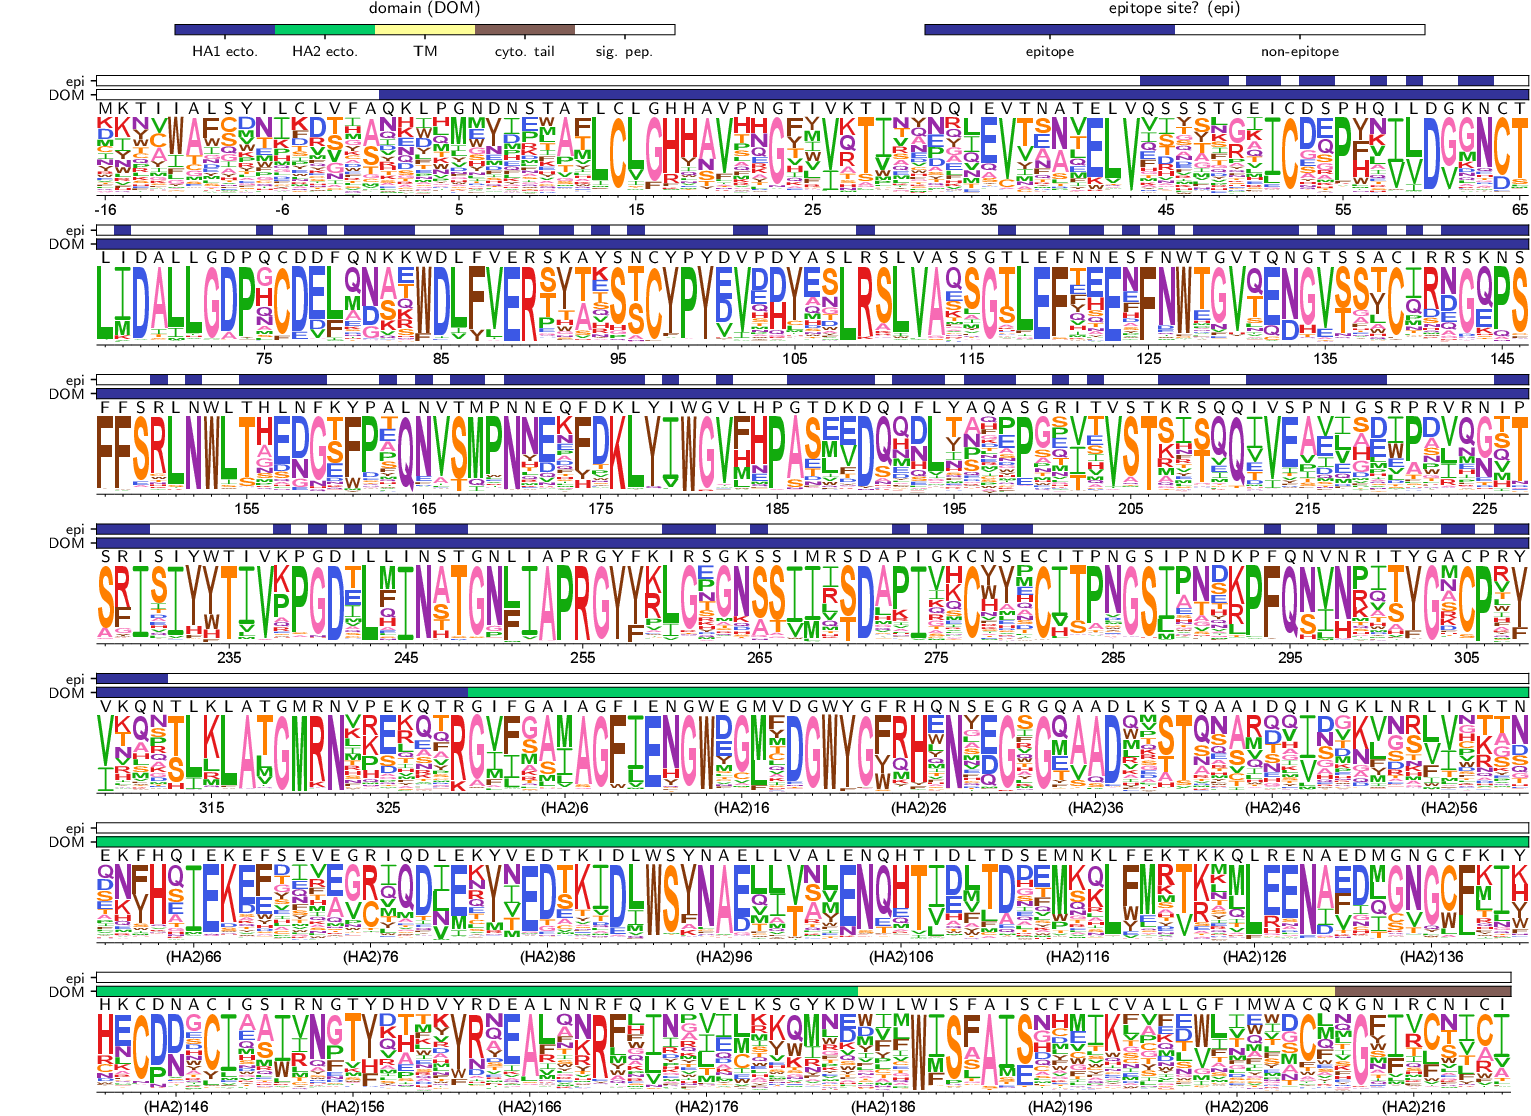

In [14]:
rescaledlogoname = 'rescaled-avgprefs'

log = !dms2_logoplot \
        --prefs {rescaledavgprefs} \
        --name {rescaledlogoname} \
        --outdir {logodir} \
        --overlay1 {wtoverlayfile} wildtype wildtype \
        --overlay2 {domainfile} DOM "domain" \
        --overlay3 {epitopefile} epi "epitope site?" \
        --overlaycolormap "terrain" \
        --nperline 81 \
        --use_existing {use_existing}
        
rescaledlogoplot = os.path.join(logodir, '{0}_prefs.pdf'.format(rescaledlogoname))
showPDF(rescaledlogoplot)

## Calculate the site entropy and write to a new preferences file

In [14]:
entropy_prefsdf = dms_tools2.prefs.prefsEntropy(rescaled_prefsdf, dms_tools2.AAS)

entropyprefs = os.path.join(renumberedprefsdir, 'summary_avgprefs_rescaled_entropies.csv')
entropy_prefsdf.to_csv(entropyprefs, index=False)

# Section 2: Investigate lineage-specific mutational effects from H3N2 evolution

### Define a function to convert a `JSON` dictionary into a `Bio.Phylo` tree
Here I will use the complete H3N2 phylogeny from 1968-present, kindly provided by John Huddleston, which he prepared by using Trevor's nextstrain pipeline (`fauna` and `augur`). 
We will use this phylogeny to collect trunk and side branch mutations and calculate the mutational effects on both sets of branches.

In [15]:
def json_to_tree(json_dict):
    """Returns a Bio.Phylo tree corresponding to the given JSON dictionary exported
    by `tree_to_json`.
    >>> import json
    >>> json_fh = open("tests/data/flu_h3n2_ha_3y_tree.json", "r")
    >>> json_dict = json.load(json_fh)
    >>> tree = json_to_tree(json_dict)
    >>> tree.name
    u'NODE_0002020'
    >>> len(tree.clades)
    2
    >>> tree.clades[0].name
    u'NODE_0001489'
    >>> hasattr(tree, "attr")
    True
    >>> "dTiter" in tree.attr
    True
    """
    node = Bio.Phylo.Newick.Clade()
    node.name = json_dict["strain"]

    if "children" in json_dict:
        # Recursively add children to the current node.
        node.clades = [json_to_tree(child) for child in json_dict["children"]]

    # Assign all non-children attributes.
    for attr, value in json_dict.items():
        if attr != "children":
            setattr(node, attr, value)

    return node

In [16]:
# Load tree JSON file used by auspice. These data are compressed.
# Decompress JSON data and load into a Python dict.
reader = codecs.getreader("utf-8")
with gzip.open("./data/flu_h3n2_1968_6v_tree.json.gz", "rb") as json_uncompressed_fh:
    json_tree = json.load(reader(json_uncompressed_fh))
    
# Load frequencies JSON file used by auspice. These data are compressed.
# Decompress JSON data and load into a Python dict.
with gzip.open("./data/flu_h3n2_1968_6v_frequencies.json.gz", "rb") as json_uncompressed_fh:
    frequencies = json.load(reader(json_uncompressed_fh))

In [17]:
# Convert JSON tree layout to a Biopython Clade instance.
tree = json_to_tree(json_tree)

### Filter nodes by stop codons
We first need to remove nodes from the tree that contain stop codon mutations because these nodes will have incorrect sequence preference values.

In [18]:
for node in tree.find_clades():
    stop_codons = 0
    
    if hasattr(node, "aa_muts"):
        for segment in node.aa_muts:
            for mutation in node.aa_muts[segment]:
                if mutation.endswith("X"):
                    stop_codons += 1

        node.attr["stop_codons"] = stop_codons
    else:
        node.attr["stop_codons"] = None

In [19]:
nodes_with_stop_codons = sorted([(node.name, node.attr["stop_codons"])
                                 for node in tree.find_clades()
                                 if node.attr["stop_codons"] is not None and node.attr["stop_codons"] > 0],
                                key=lambda node: node[1],
                                reverse=True)

In [20]:
node_names_with_stop_codons = [node[0] for node in nodes_with_stop_codons]

In [21]:
node_names_with_stop_codons

['A/Santiago/6764/2006',
 'A/Singapore/16/2002',
 'A/Fes/314/1998',
 'A/Malaysia/12550/1997',
 'A/Ryazan/10/2006',
 'A/Tehran/487/2007',
 'A/RioDeJaneiro/28/2007']

In [22]:
for node in node_names_with_stop_codons:
    tree.prune(node)

In [23]:
len([node for node in tree.find_clades()])

3913

### Define trunk and side branches

[Bedford et al. 2015](http://www.nature.com.offcampus.lib.washington.edu/nature/journal/v523/n7559/pdf/nature14460.pdf) defines the trunk as "all branches ancestral to viruses
sampled within 1 year of the most recent sample". Based on this definition, we used the following steps to define the trunk and side branches:

  1. Select all nodes sampled within the last year (from `2017.0` onwards)
  1. Trace the nodes back until they reach their most recent common ancestor
  1. All branches ancestral to the MRCA of "recent nodes" are called as the the trunk, while all else are side branches 
  1. Omit all nodes sampled after the date of the MRCA, since the resolution of the trunk is limited here

In [24]:
# Biopython's trees don't store links to node parents, so we need to build
# a map of each node to its parent.
# Code from the Bio.Phylo cookbook: http://biopython.org/wiki/Phylo_cookbook
def all_parents(tree):
    parents = {}
    for clade in tree.find_clades(order='level'):
        for child in clade:
            parents[child] = clade
    return parents

parents_by_node = all_parents(tree)

In [25]:
# Next, annotate each node with its parent.
for node in tree.find_clades():
    if node == tree.root:
        node.parent = None
    else:
        node.parent = parents_by_node[node]

In [26]:
# Find all tips of the tree sampled since 2017.
recent_nodes = [node for node in tree.get_terminals() if node.attr["num_date"] > 2017.0]

print ('There are {0} recent nodes.'.format(len(recent_nodes)))

There are 33 recent nodes.


In [27]:
# Find the last common ancestor of all recent nodes.
mrca = tree.common_ancestor(recent_nodes)
mrca

Clade(aa_sequence='MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATE...', clade=2965, name='NODE_0001621', strain='NODE_0001621', tvalue=44.17835, xvalue=0.19177, yvalue=436.73924)

In [28]:
print ('The date of the MRCA of the recent nodes is: {0}'.format(mrca.attr['num_date']))

The date of the MRCA of the recent nodes is: 2012.0451254241716


In [29]:
# Label all nodes as not part of the trunk or as a side branch ancestor
# by default.
for node in tree.find_clades():
    node.is_trunk = False
    node.is_side_branch_ancestor = False

In [30]:
# Find all nodes that are ancestral to recent nodes.
# Label these ancestral nodes as part of the "trunk"
# and collect the set of distinct nodes in the trunk.
for recent_node in recent_nodes:
    current_node = recent_node.parent
    
    # Traverse from the current node to the tree's root.
    while current_node != tree.root:
        # Mark a node as part of the trunk if it was sampled
        # before the MRCA of all recent nodes.
        if current_node.attr["num_date"] < mrca.attr["num_date"]:
            current_node.is_trunk = True
            
        current_node = current_node.parent

In [31]:
# Make a list of nodes that are descendants of the MRCA of recent nodes.
# These are "unresolved" nodes.
unresolved_nodes = [node for node in mrca.find_clades()]

In [32]:
nodes_in_tree = len([node for node in tree.find_clades()])
nodes_in_tree

3913

In [33]:
trunk_path = [node for node in tree.find_clades()
              if node.is_trunk]
len(trunk_path)

147

In [34]:
# Find all nodes that are not on the trunk. These are
# side branch nodes.
side_branch_nodes = [node for node in tree.find_clades()
                     if not node.is_trunk and node not in unresolved_nodes]

print ('There are {0} side branch nodes.'.format(len(side_branch_nodes)))

There are 2806 side branch nodes.


In [35]:
trunk_path_names = [node.name for node in trunk_path]

In [36]:
internal_side_branch_nodes = [node for node in side_branch_nodes
                              if not node.is_terminal()]
print ('There are {0} internal side branch nodes.'.format(len(internal_side_branch_nodes)))

There are 1195 internal side branch nodes.


In [37]:
terminal_side_branch_nodes = [node for node in side_branch_nodes
                              if node.is_terminal()]
print ('There are {0} terminal side branch nodes.'.format(len(terminal_side_branch_nodes)))

There are 1611 terminal side branch nodes.


In [38]:
# Calculate the proportion of the tree on the trunk.
print ('The proportion of the tree on the trunk is = {0}'.format(len(trunk_path) / float(nodes_in_tree)))

The proportion of the tree on the trunk is = 0.03756708407871199


In [39]:
# Color nodes by status as on the trunk or as a side branch ancestor.
for node in tree.find_clades():
    if node.is_trunk:
        node.attr["trunk_status"] = "trunk"
    elif node in side_branch_nodes:
        node.attr["trunk_status"] = "side_branch"
    else:
        node.attr["trunk_status"] = "unresolved"

In [40]:
cmap = {
    "trunk": "#e54d42",
    "side_branch": "#6891e0", 
    "unresolved": "#afafaf"}

label_map = {
    "trunk": "Trunk",
    "side_branch": "Side branch", 
    "unresolved": "Unresolved"}

In [41]:
# Find the DMS strain.
dms_strain = [node for node in tree.find_clades() if node.strain == "A/Perth/16/2009"][0]

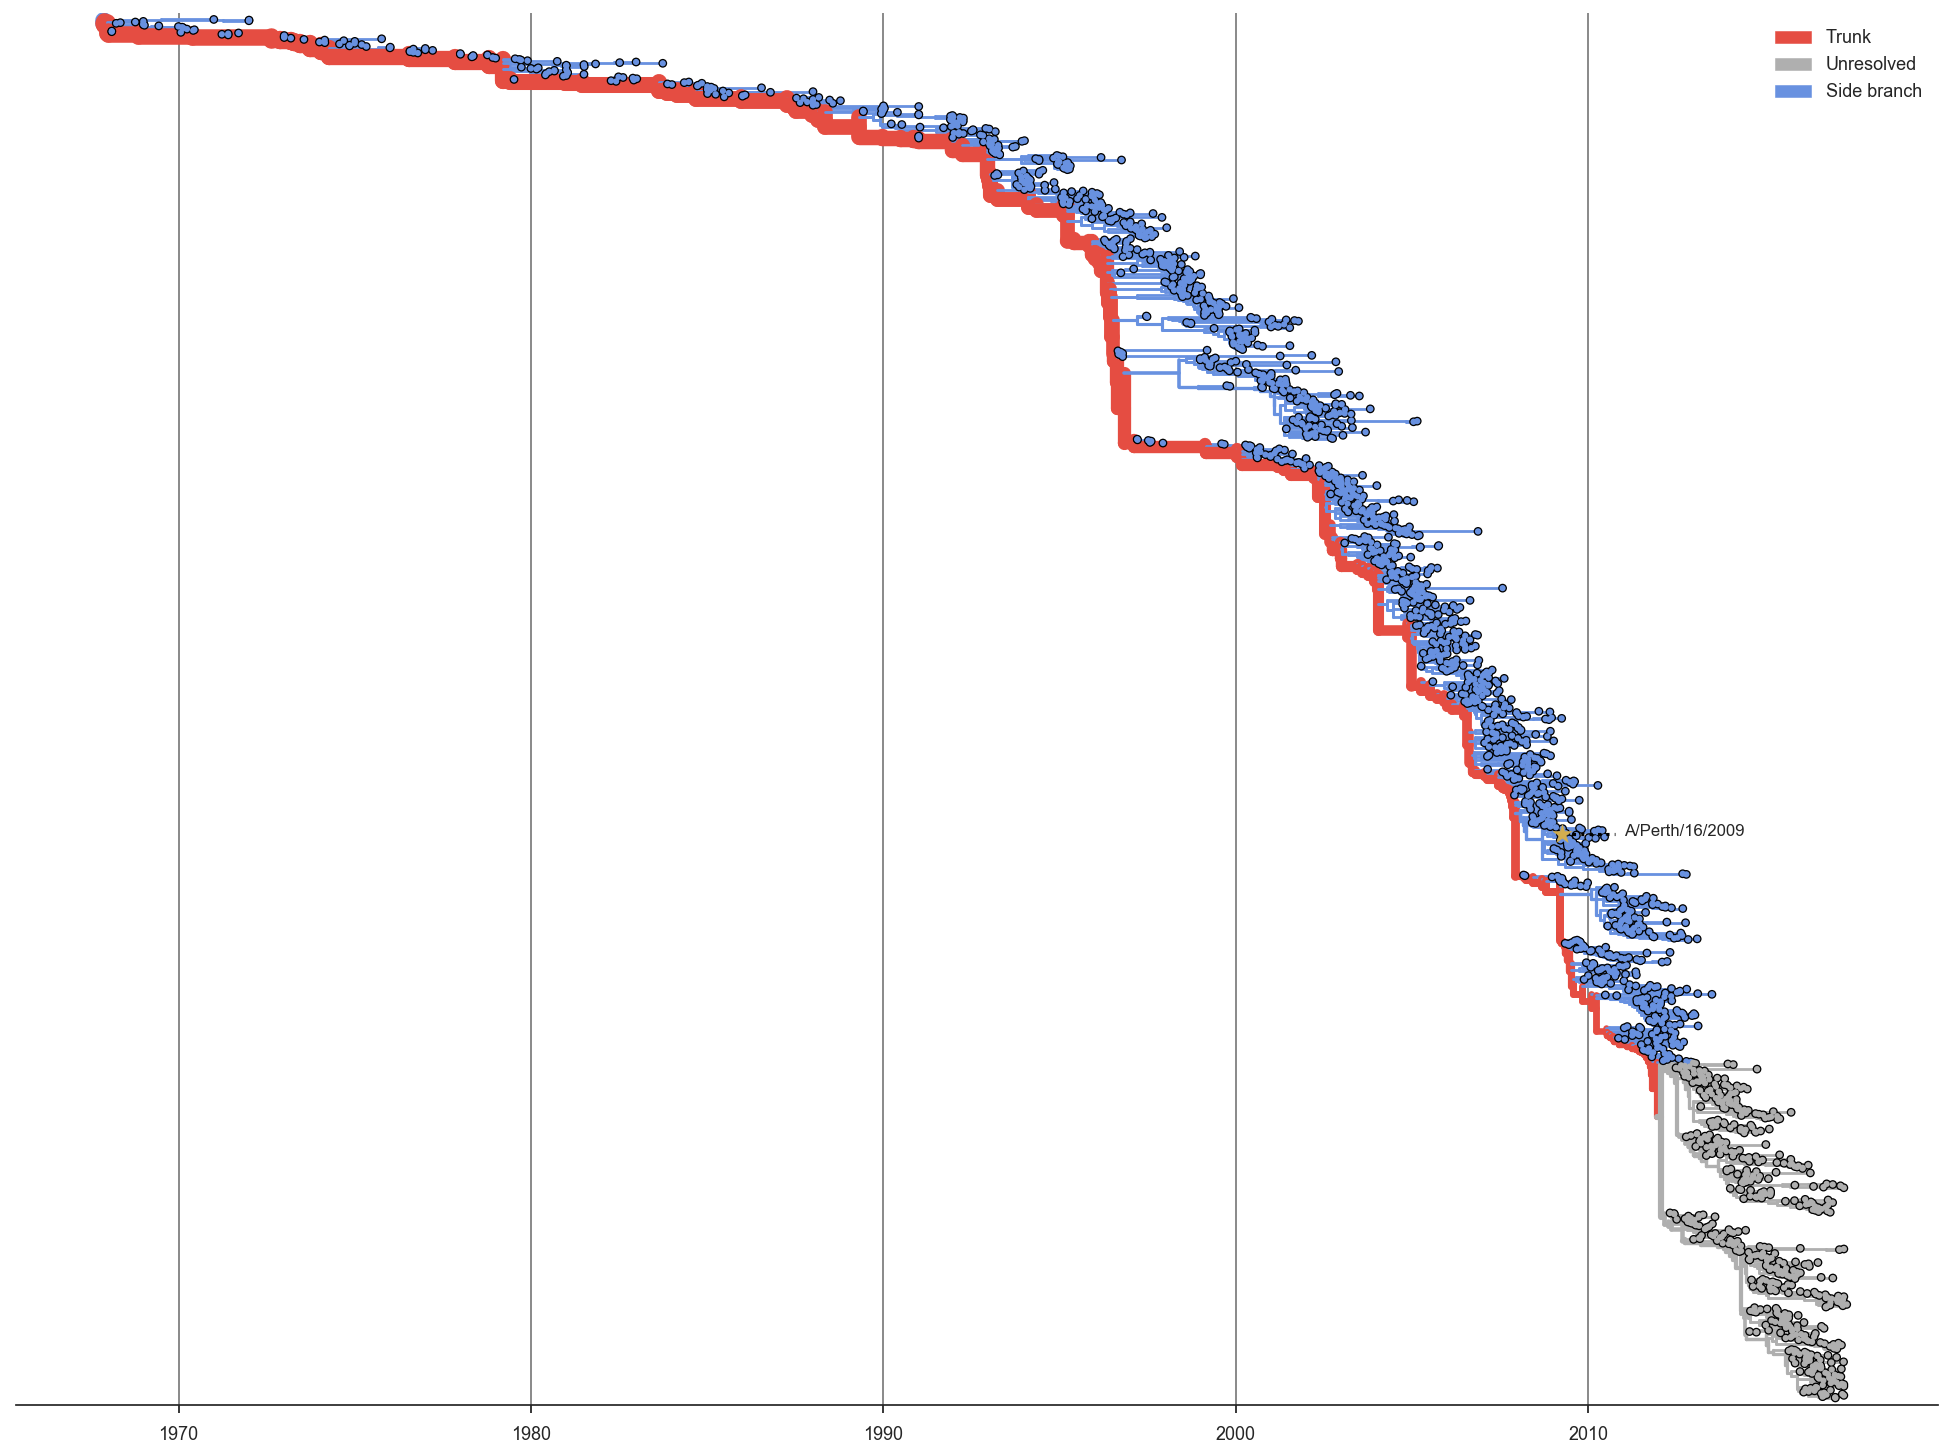

In [67]:
# Plot H3N2 tree in BALTIC style from Bio.Phylo tree.
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 100

# Use simple plot style with figures sized for context of a talk.
sns.set_style("ticks")
sns.set_context("talk")

mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.size']=22

yvalues = [node.yvalue for node in tree.find_clades()]
y_span = max(yvalues)

trait_name = "trunk_status"
fig, ax = plt.subplots(figsize=(20,15), facecolor='w')

L=len([k for k in tree.find_clades() if k.is_terminal()])

# Setup arrays for tip and internal node coordinates.
tip_circles_x = []
tip_circles_y = []
tip_circles_color = []
node_circles_x = []
node_circles_y = []
node_circles_color = []

for k in tree.find_clades(): ## iterate over objects in tree
    x=k.attr["num_date"] ## or from x position determined earlier
    y=k.yvalue ## get y position from .drawTree that was run earlier, but could be anything else
    
    if k.parent is None:
        xp = None
    else:
        xp=k.parent.attr["num_date"] ## get x position of current object's parent

    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp=x
        
    c='k'
    label = ''
    if trait_name in k.attr:
        c = cmap[k.attr[trait_name]]
        label = label_map.get(k.attr[trait_name])
    
    branchWidth=2
    if k.is_terminal(): ## if leaf...
        s=20 ## tip size can be fixed
        
        tip_circles_x.append(x)
        tip_circles_y.append(y)
        tip_circles_color.append(c)
    else: ## if node...
        k_leaves = [child
                    for child in k.find_clades()
                    if child.is_terminal()]
        branchWidth+=10.0*len(k_leaves)/float(L)
        
        if len(k.clades)==1:
            node_circles_x.append(x)
            node_circles_y.append(y)
            node_circles_color.append(c)

        ax.plot([x,x],[k.clades[-1].yvalue, k.clades[0].yvalue], lw=branchWidth, color=c, ls='-', zorder=9, solid_capstyle='round')
        
    ax.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9, label=label)

# Add circles for tips and internal nodes.
ax.scatter(tip_circles_x, tip_circles_y, s=s, facecolor=tip_circles_color, edgecolor='none',zorder=11, rasterized=True) ## plot circle for every tip
ax.scatter(tip_circles_x, tip_circles_y, s=s*2, facecolor='k', edgecolor='none', zorder=10) ## plot black circle underneath
ax.scatter(node_circles_x, node_circles_y, facecolor=node_circles_color, s=50, edgecolor='none', zorder=10, lw=2, marker='|') ## mark every node in the tree to highlight that it's a multitype tree

ax.set_ylim(-10, y_span + 10)

ax.spines['top'].set_visible(False) ## no axes
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.grid(axis='x',ls='-',color='grey')
ax.tick_params(axis='y',size=0)
ax.set_yticklabels([])

# Annotate DMS strain.
ax.scatter([dms_strain.attr["num_date"]], [dms_strain.yvalue], marker="*", s=200, facecolor=["#d3ae4e"], zorder=20)
ax.text(dms_strain.attr["num_date"] + 1.75, dms_strain.yvalue - 3, dms_strain.strain, fontsize=12)
ax.hlines(dms_strain.yvalue, dms_strain.attr["num_date"] + 0.05, dms_strain.attr["num_date"] + 1.5, linestyles=":", zorder=19)

# Add legend for colors.
patches = []
for key in label_map.keys():
    patches.append(mpatches.Patch(color=cmap[key], label=label_map[key]))
    
ax.legend(handles=patches)

plt.tight_layout()
# plt.savefig('{0}/H3N2_phylogeny.pdf'.format(plotsdir), format='pdf')
plt.show()

### Collect trunk and side branch mutations

Now that we have defined what is the trunk and what are side branches, we will traverse through the tree and collect all trunk and side branch mutations.
Note that we collect mutations even if they occur more than once on the tree. 
In other words, if for example, a mutation has occurred twice along the trunk, that mutation is counted twice and not just once.

In [42]:
def collect_mutations_by_nodes(nodes):
    """Returns a unique set of amino acid mutations associated
    with the given nodes.
    """
    mutations = []
    for node in nodes:
        if hasattr(node, "aa_muts"):
            for segment in node.aa_muts:
                for mutation in node.aa_muts[segment]:
                    mutations.append(mutation + ':' + segment)
    
    return mutations

In [43]:
# Save all mutations along the trunk.
trunk_mutations = collect_mutations_by_nodes(trunk_path)

# Save all mutations from any side branch node.
side_branch_mutations = collect_mutations_by_nodes(side_branch_nodes)

# Save all mutations from side branch internal nodes
internal_node_mutations = collect_mutations_by_nodes(internal_side_branch_nodes)

# Save all mutations from side branch terminal nodes
terminal_node_mutations = collect_mutations_by_nodes(terminal_side_branch_nodes)

In [44]:
# Define a function to clean up the list of mutations
def PruneMutList(mutlist, exchars = ['X', '*', 'SigPep']):
    """This function reads in a list of mutations, 
    removes mutations with undesired characters (e.g., 'X', '*', etc.), 
    and returns a pruned list of mutations.
    The argument mutlist specifies the input list of mutations,
    and the argument exchars specifies a list of characters so that if a mutation has any of these characters,
    it should be removed from the list of mutations."""
    newmutlist = [str(mut) for mut in mutlist if not any(c in mut for c in exchars)]
    return newmutlist

In [45]:
all_trunk_muts = PruneMutList(trunk_mutations)
all_side_muts = PruneMutList(side_branch_mutations)
all_internal_node_muts = PruneMutList(internal_node_mutations)
all_terminal_node_muts = PruneMutList(terminal_node_mutations)

print ('There are {0} total trunk mutations.'.format(len(all_trunk_muts)))
print ('There are {0} total side branch mutations.'.format(len(all_side_muts)))
print ('There are {0} total internal node mutations.'.format(len(all_internal_node_muts)))
print ('There are {0} total terminal node mutations.'.format(len(all_terminal_node_muts)))

There are 137 total trunk mutations.
There are 2220 total side branch mutations.
There are 543 total internal node mutations.
There are 1677 total terminal node mutations.


### Calculate mutational effects for each mutation

Now we will calculate the mutational effect for every trunk and side branch mutations.

In [46]:
def CalculateAllFitnessEffects(mutlist, preferences):
    """
    This function reads in a list of mutations and for each mutation,
    calculate the mutational effect as PI_Y / PI_X at site #.
    and returns a list of mutational effects for each of the mutations in the input list.
    
    Args:
        mutlist: list of input mutations. Must be formated as X#Y:SUBUNIT, 
            where X is the original amino-acid at site #, 
            Y is the amino-acid that site # has mutated into, 
            and SUBUNIT is the subunit of the protein (HA1 or HA2)
        preferences: preferences .csv file
        
    Returns:
        A list of mutational effects for each mutation in the input mutlist.
    """
    
    prefsdf = pd.read_csv(preferences)
        
    sites = prefsdf['site'].tolist()
    effectslist = []
    
    for mut in mutlist:
        regex = r"(\w\d{1,3}[^X,*]:HA[12])"
        match = re.search(regex, mut)
        if match:
            m = mut.split(':')[0]
            subunit = mut.split(':')[1]
            site = m[1:-1]
            aa1 = m[0]
            aa2 = m[-1]
        else:
            print ('{0} not a valid mutation.'.format(mut))
            continue 

        if subunit == 'HA1':
            if site in sites:
                aa1pref = prefsdf[prefsdf['site'] == site][aa1]
                aa2pref = prefsdf[prefsdf['site'] == site][aa2]
                muteffect = aa2pref/aa1pref
            else:
                continue
        elif subunit == 'HA2':
            if '(HA2)' + site in sites:
                aa1pref = prefsdf[prefsdf['site'] == '(HA2)'+site][aa1]
                aa2pref = prefsdf[prefsdf['site'] == '(HA2)'+site][aa2]
                muteffect = aa2pref/aa1pref
            else:
                continue

        effectslist.append(float(muteffect))
        
    return effectslist

In [47]:
alltrunk_muts_effects = CalculateAllFitnessEffects(all_trunk_muts, rescaledavgprefs)
allside_muts_effects = CalculateAllFitnessEffects(all_side_muts, rescaledavgprefs)
allintnode_muts_effects = CalculateAllFitnessEffects(all_internal_node_muts, rescaledavgprefs)
alltermnode_muts_effects = CalculateAllFitnessEffects(all_terminal_node_muts, rescaledavgprefs)

In [48]:
print ('The median of trunk mutational effects = {0}'.format(np.median(alltrunk_muts_effects)))
print ('The median of side branch mutational effects = {0}'.format(np.median(allside_muts_effects)))
print ('The median of internal node mutational effects = {0}'.format(np.median(allintnode_muts_effects)))
print ('The median of terminal node mutational effects = {0}\n'.format(np.median(alltermnode_muts_effects)))

trunkvssidebr_med_diff = np.log2(np.median(alltrunk_muts_effects)) - np.log2(np.median(allside_muts_effects))
trunkvsintnode_med_diff = np.log2(np.median(alltrunk_muts_effects)) - np.log2(np.median(allintnode_muts_effects))
trunkvstermnode_med_diff = np.log2(np.median(alltrunk_muts_effects)) - np.log2(np.median(alltermnode_muts_effects))

print ('The difference between the medians of \
trunk and side branch mutational effects = {0}'.format(trunkvssidebr_med_diff))
print ('The difference between the medians of \
trunk and internal node mutational effects = {0}'.format(trunkvsintnode_med_diff))
print ('The difference between the medians of \
trunk and terminal node mutational effects = {0}'.format(trunkvstermnode_med_diff))

The median of trunk mutational effects = 1.3271210704702265
The median of side branch mutational effects = 0.3354449938820977
The median of internal node mutational effects = 0.49925081303844254
The median of terminal node mutational effects = 0.2778969932044076

The difference between the medians of trunk and side branch mutational effects = 1.9841518722986584
The difference between the medians of trunk and internal node mutational effects = 1.4104633085157012
The difference between the medians of trunk and terminal node mutational effects = 2.255677860718781


In [49]:
favored_alltrunk = sum(e > 1 for e in alltrunk_muts_effects)
favored_allside = sum(e > 1 for e in allside_muts_effects)

print ('The fraction of trunk mutations \
that are towards more preferred amino acids = {0}'.format(float(favored_alltrunk)/float(len(alltrunk_muts_effects))))
print ('The fraction of side branch mutations \
that are towards more preferred amino acids = {0}'.format(float(favored_allside)/float(len(allside_muts_effects))))

The fraction of trunk mutations that are towards more preferred amino acids = 0.583941605839416
The fraction of side branch mutations that are towards more preferred amino acids = 0.27072072072072073


These are number of mutations to preferred or to unpreferred amino acids for trunk and side branch mutations:

| BRANCH        | # to more preferred   | # to less preferred  | TOTAL |
| ------------- |:---------------------:| ---------------------|------:|
| trunk         | 80                    | 57                   | 137   |
| side branch   | 601                   | 1619                 | 2220  |


In [50]:
allmuteffects = []
allmuteffects.append([e for e in np.log2(allside_muts_effects)])
allmuteffects.append([e for e in np.log2(alltrunk_muts_effects)])

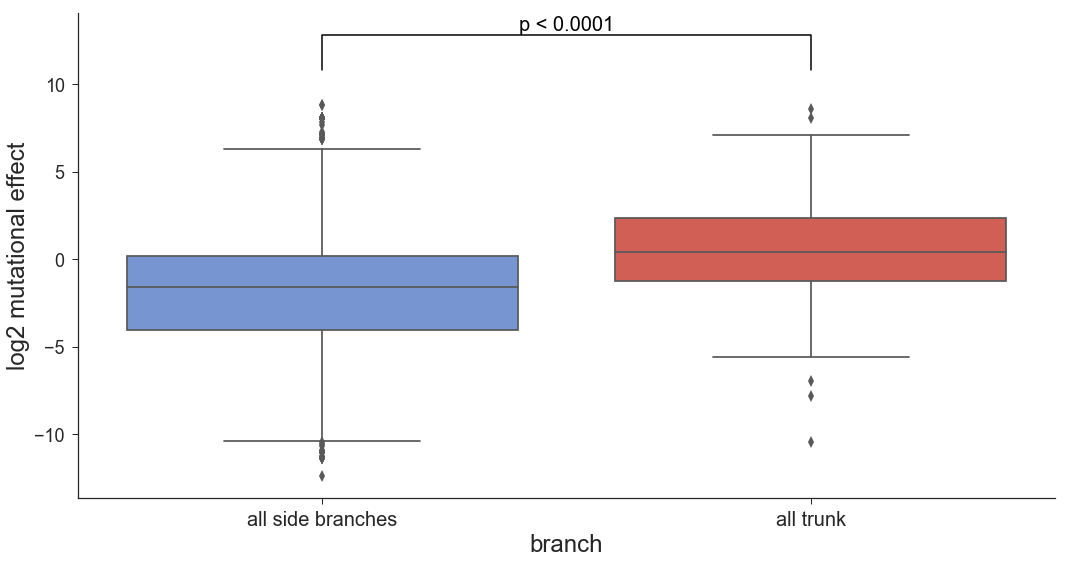

In [67]:
sns.set()
flatui = ['#6891e0', '#e54d42']
sns.color_palette(flatui)
sns.set_palette(flatui)
sns.set_style('white')
sns.set_style('ticks')
(fig, ax) = plt.subplots(figsize=(15,8))
g = sns.boxplot(data=allmuteffects, fliersize=8)
g.set_xticklabels(['all side branches','all trunk'])
ax.set_xlabel('branch', fontsize = 24)
ax.set_ylabel('log2 mutational effect', fontsize = 24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=18)

x1, x2 = 0, 1
y, h, col = max(allmuteffects[0] + allmuteffects[1]) + 2, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "p < 0.0001", ha='center', va='bottom', color=col, fontsize = 20)

sns.despine()
plt.tight_layout()
# plt.savefig('{0}/allsidebr_vs_alltrunk_1968-2012.pdf'.format(plotsdir), format='pdf')
plt.show()

This plot shows the `log2 mutational effect` on the y-axis and the mutation's location on the phylogeny (`side branch` or `trunk`) on the x-axis.

Log mutational effects that are **greater than zero** are mutations that are towards _more_ preferred amino acids, while mutational effects that are **less than zero** are mutations that are towards _less_ preferred amino acids. Overall, the mutational effects for trunk mutations is greater than the mutational effects for side branch mutations. 

In addition, many side branch mutations may be somewhat "beneficial" (i.e., to more preferred amino acids), but these side branches have died out due to competition between clades. It would be interesting to apply a clade frequency cutoff and only look at mutations in those clades that have failed to reach this cutoff frequency.

In [97]:
nodes_muteffects = []
nodes_muteffects.append([e for e in np.log2(alltermnode_muts_effects)])
nodes_muteffects.append([e for e in np.log2(allintnode_muts_effects)])
nodes_muteffects.append([e for e in np.log2(alltrunk_muts_effects)])

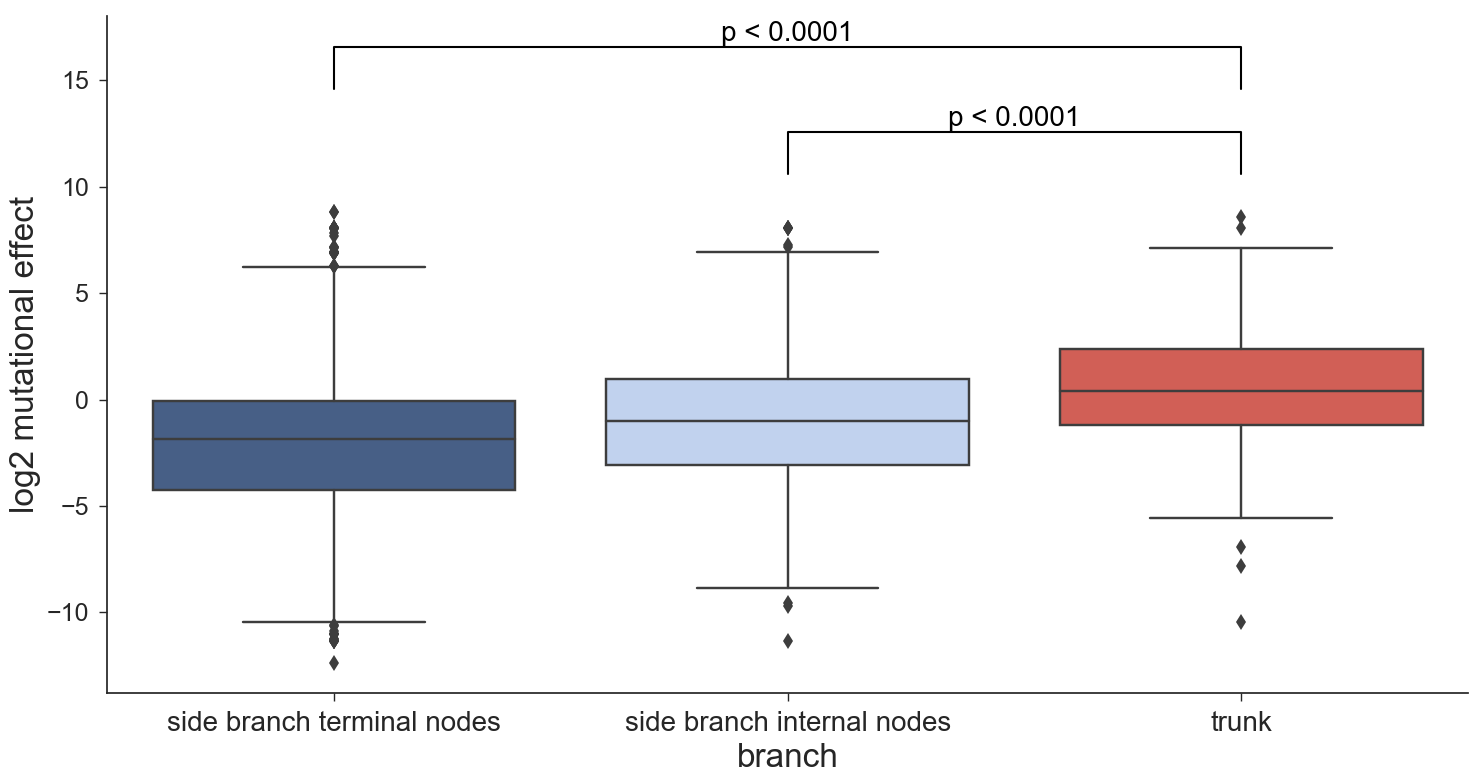

In [98]:
sns.set()
triplet = ['#3c5c90', '#b9d0f6', '#e54d42']
sns.color_palette(triplet)
sns.set_palette(triplet)
sns.set_style('white')
sns.set_style('ticks')
(fig, ax) = plt.subplots(figsize=(15,8))
g = sns.boxplot(data=nodes_muteffects, fliersize=8)
g.set_xticklabels(['side branch terminal nodes','side branch internal nodes','trunk'])
ax.set_xlabel('branch', fontsize = 24)
ax.set_ylabel('log2 mutational effect', fontsize = 24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=18)

y, h, col = max(nodes_muteffects[1] + nodes_muteffects[2]) + 2, 2, 'k'
plt.plot([1, 1, 2, 2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.plot([0, 0, 2, 2], [y+h+h, y+h+h+h, y+h+h+h, y+h+h], lw=1.5, c=col)
plt.text((1+2)*.5, y+h, "p < 0.0001", ha='center', va='bottom', color=col, fontsize = 20)
plt.text((0+2)*.5, y+h+h+h, "p < 0.0001", ha='center', va='bottom', color=col, fontsize = 20)

sns.despine()
plt.tight_layout()
# plt.savefig('{0}/int_termnodes_trunk_1968-2012.pdf'.format(plotsdir), format='pdf')
plt.show()

### Calculate the mutational effects at epitope and non-epitope sites

In [51]:
# Read in Wolf epitope sites
epi_sitesdf = pd.read_csv('./data/wolf_epitope_sites.csv')
epi_sites = epi_sitesdf[epi_sitesdf['epi'] == 'epitope']['site'].tolist()

In [52]:
epi_trunk_muts = [m for m in all_trunk_muts if 'HA2' not in m and (m.split(':')[0])[1:-1] in epi_sites]
epi_side_muts = [m for m in all_side_muts if 'HA2' not in m and (m.split(':')[0])[1:-1] in epi_sites]

In [53]:
non_epi_trunk_muts = [m for m in all_trunk_muts if m not in epi_trunk_muts]
non_epi_side_muts = [m for m in all_side_muts if m not in epi_side_muts]

In [54]:
non_epi_trunk_muts

['D31N:HA1',
 'E150G:HA2',
 'R212K:HA2',
 'L3F:HA1',
 'L2I:HA2',
 'F3L:HA1',
 'D2N:HA1',
 'T160K:HA1',
 'I18V:HA2',
 'R124K:HA2',
 'N2K:HA1',
 'V55L:HA2',
 'K121R:HA2',
 'D46N:HA2',
 'R123K:HA2',
 'E57G:HA2',
 'G225D:HA1',
 'V202I:HA1',
 'W222R:HA1',
 'V201A:HA2',
 'L25I:HA1',
 'T32I:HA2',
 'D225N:HA1',
 'N46D:HA2',
 'R121K:HA2',
 'I32R:HA2',
 'V223I:HA1',
 'Q33R:HA1']

In [55]:
epi_trunk_muts_effects = CalculateAllFitnessEffects(epi_trunk_muts, rescaledavgprefs)
epi_side_muts_effects = CalculateAllFitnessEffects(epi_side_muts, rescaledavgprefs)
non_epi_trunk_effects = CalculateAllFitnessEffects(non_epi_trunk_muts, rescaledavgprefs)
non_epi_side_effects = CalculateAllFitnessEffects(non_epi_side_muts, rescaledavgprefs)

In [56]:
print ('The median of epitope trunk mutational effects = {0}'.format(np.median(epi_trunk_muts_effects)))
print ('The median of epitope side branch mutational effects = {0}'.format(np.median(epi_side_muts_effects)))
print ('The median of non-epitope trunk mutational effects = {0}'.format(np.median(non_epi_trunk_effects)))
print ('The median of non-epitope side branch mutational effects = {0}\n'.format(np.median(non_epi_side_effects)))

epi_med_diff = np.log2(np.median(epi_trunk_muts_effects)) - np.log2(np.median(epi_side_muts_effects))
non_epi_med_diff = np.log2(np.median(non_epi_trunk_effects)) - np.log2(np.median(non_epi_side_effects))

print ('The difference between the medians of \
trunk and side branch mutational effects at epitope sites = {0}'.format(epi_med_diff))
print ('The difference between the medians of \
trunk and internal node mutational effects = {0}'.format(non_epi_med_diff))

The median of epitope trunk mutational effects = 1.689609408629877
The median of epitope side branch mutational effects = 0.3398412325624443
The median of non-epitope trunk mutational effects = 1.199668544756217
The median of non-epitope side branch mutational effects = 0.3280505745563336

The difference between the medians of trunk and side branch mutational effects at epitope sites = 2.313756964658071
The difference between the medians of trunk and internal node mutational effects = 1.8706457070967522


In [104]:
epimuteffects = []
epimuteffects.append([e for e in np.log2(non_epi_side_effects)])
epimuteffects.append([e for e in np.log2(non_epi_trunk_effects)])
epimuteffects.append([e for e in np.log2(epi_side_muts_effects)])
epimuteffects.append([e for e in np.log2(epi_trunk_muts_effects)])

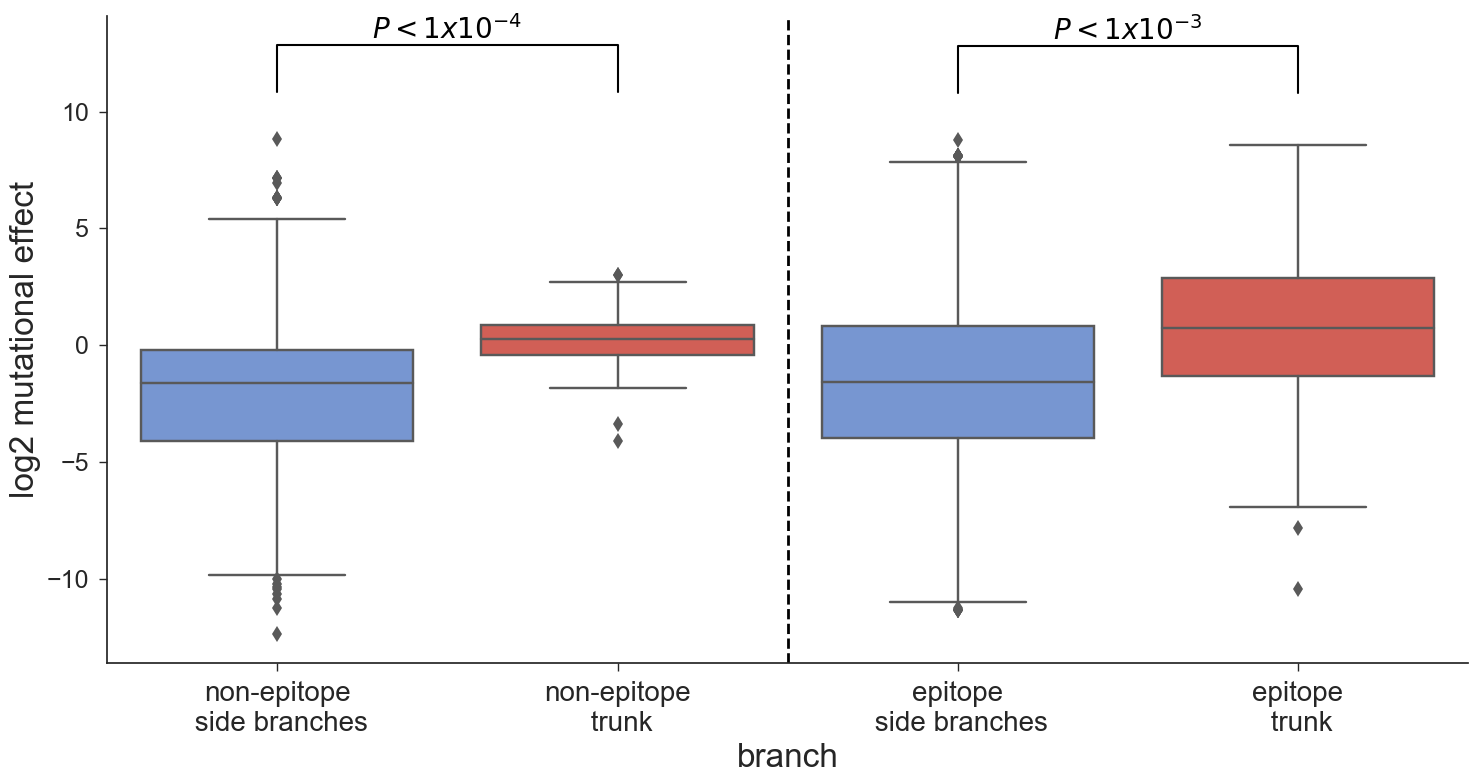

In [105]:
sns.set()
flatui = ['#6891e0', '#e54d42', '#6891e0', '#e54d42']
sns.color_palette(flatui)
sns.set_palette(flatui)
sns.set_style('white')
sns.set_style('ticks')
(fig, ax) = plt.subplots(figsize=(15,8))
g = sns.boxplot(data=epimuteffects, fliersize=8)
g.set_xticklabels(['non-epitope\n side branches', 'non-epitope\n trunk', 
                   'epitope\n side branches', 'epitope\n trunk'])
ax.set_xlabel('branch', fontsize = 24)
ax.set_ylabel('log2 mutational effect', fontsize = 24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=18)

y1, h, col = max(epimuteffects[0] + epimuteffects[1]) + 2, 2, 'k'
plt.plot([0, 0, 1, 1], [y1, y1+h, y1+h, y1], lw=1.5, c=col)
plt.text((0+1)*.5, y1+h, "$P < 1x10^{-4}$", ha='center', va='bottom', color=col, fontsize = 20)

y2, h, col = max(epimuteffects[2] + epimuteffects[3]) + 2, 2, 'k'
plt.plot([2, 2, 3, 3], [y2, y2+h, y2+h, y2], lw=1.5, c=col)
plt.text((2+3)*.5, y2+h, "$P < 1x10^{-3}$", ha='center', va='bottom', color=col, fontsize = 20)

plt.axvline(1.5, linewidth=2, color='k', linestyle='--')

sns.despine()
plt.tight_layout()
# plt.savefig('{0}/epitope_nonepitope_sidebr_trunk.pdf'.format(plotsdir), format='pdf')
plt.show()

### Calculate mutational effects for shuffled preferences

The results above suggest that trunk mutational effects are, on average, higher than side branch mutational effects.
However, we want to know how significant this finding is. 
To determine significance, we will shuffle the preferences across sites, recalculate the median mutational effects for all trunk and side branch mutations using the shuffled preferences, and repeat this randomization 10000 times.
We can then see how frequently the shuffled preferences give a difference in trunk vs side branch mutational effects that exceed the true difference in medians.

In [125]:
def ParseMutListToTuples(mutlist):
    """
    This function reads in a list of mutations and returns the same list of mutations,
    but with each mutation formatted as a tuple.
    Args:
        mutlist: input list of mutations
    Returns:
        a list of mutations with each mutation formatted as a tuple like so: (subunit, site, aa1, aa2)
    """
    parsedmuts = []
    for mut in mutlist:
        regex = r"(\w\d{1,3}[^X,*]:HA[12])"
        match = re.search(regex, mut)
        if match:
            m = mut.split(':')[0]
            subunit = mut.split(':')[1]
            site = m[1:-1]
            aa1 = m[0]
            aa2 = m[-1]
        else:
            print ('{0} not a valid mutation.'.format(mut))
            continue
        
        parsedmuts.append((subunit, site, aa1, aa2))
    return parsedmuts

In [126]:
all_trunk_parsed = ParseMutListToTuples(all_trunk_muts)
all_side_parsed = ParseMutListToTuples(all_side_muts)
side_int_parsed = ParseMutListToTuples(all_internal_node_muts)
side_term_parsed = ParseMutListToTuples(all_terminal_node_muts)

epi_trunk_parsed = ParseMutListToTuples(epi_trunk_muts)
epi_side_parsed = ParseMutListToTuples(epi_side_muts)
non_epi_trunk_parsed = ParseMutListToTuples(non_epi_trunk_muts)
non_epi_side_parsed = ParseMutListToTuples(non_epi_side_muts)

In [127]:
def ShufflePrefs(m1name, m1, m2name, m2, preferences, iterations=1000, sites=None, exclude_sites=False):
    """
    This function reads in two lists of mutations and a preferences file,
    shuffle the preferences across sites, and calculate the mutational effects
    of the two sets of mutations using the shuffled preferences.
    The median of the mutational effects for a given list of mutations will be
    added to a list in a dictionary keyed by the name of the mutation sets.
    It will then repeat this randomization the number of iterations specified 
    by the user.
    
    Args:
        `m1name` and `m2name`: are strings signifying the name that should be given 
            to the list of `m1` and `m2` mutations.
        `m1` and `m2`: lists containing mutations formatted as tuples 
            (created using the `ParseMutListToTuples` function defined above)
            such that each tuple contains the following (subunit, site, aa1, aa2).
        `preferences`: preferences file used as input.
        `iterations`: number of iterations to be completed (default=1000).
        `sites`: specify a list of sites to randomize among.
        `exclude_sites`: exclude the sites in `sites`? (default = False)
    Returns:
        A dictionary of shuffled median mutational effects keyed by m1name and m2name.
    """
    
    prefsdf = pd.read_csv(preferences)
    if sites:
        if exclude_sites is True:
            allsites = prefsdf['site'].tolist()
            siteslist = [s for s in allsites if s not in sites]
            prefsdf = prefsdf[prefsdf['site'].isin(siteslist)]
        else:
            siteslist = sites
            prefsdf = prefsdf[prefsdf['site'].isin(siteslist)]
    else:
        siteslist = prefsdf['site'].tolist()
    
    shuffledmuteffects = {m1name: [], m2name: []}
    
    muts = [(m1name, m1), (m2name, m2)]
    random.seed(10)
    
    for x in range(iterations):
        random.shuffle(siteslist)
        prefsdf['site'] = siteslist
        prefsdf.set_index('site', drop = True, inplace = True)
        prefsdict = prefsdf.to_dict(orient = 'index')
        for (name, mutations) in muts:
            muteffects = []
            for (subunit, site, aa1, aa2) in mutations:
                if subunit == 'HA1' and site in siteslist:
                    aa1pref = prefsdict[site][aa1]
                    aa2pref = prefsdict[site][aa2]
                    muteffect = np.log2(aa2pref/aa1pref)
                elif subunit == 'HA2' and ('(HA2)' + site) in siteslist:
                    aa1pref = prefsdict['(HA2)'+site][aa1]
                    aa2pref = prefsdict['(HA2)'+site][aa2]
                    muteffect = np.log2(aa2pref/aa1pref)
                muteffects.append(float(muteffect))
            shuffledmuteffects[name].append(float(np.median(muteffects)))
    
    return shuffledmuteffects

In [128]:
num_iter = 10000

In [129]:
trunk_sidebr_shuffled = ShufflePrefs('trunk', all_trunk_parsed, 
                                     'side_branch', all_side_parsed, 
                                      rescaledavgprefs, iterations = num_iter)

In [130]:
shuffleddf = pd.DataFrame.from_dict(trunk_sidebr_shuffled)
shuffleddf['effectdiff'] = shuffleddf.trunk - shuffleddf.side_branch
print ('This is the number of trunk median minus side branch median differences \
that are greater than > {0}:'.format(trunkvssidebr_med_diff))
print (sum(e > trunkvssidebr_med_diff for e in shuffleddf.effectdiff))
print ('This is {0}% of the randomizations.'.format(sum(e >= trunkvssidebr_med_diff for e in shuffleddf.effectdiff)/float(num_iter)*100.0))

This is the number of trunk median minus side branch median differences that are greater than > 1.9841518722986584:
0
This is 0.0% of the randomizations.


In [260]:
trunk_intsidebr_shuffled = ShufflePrefs('trunk', all_trunk_parsed, 
                                        'sidebr_internal_nodes', side_int_parsed, 
                                        rescaledavgprefs, iterations = num_iter)

In [261]:
shuffleddf_int = pd.DataFrame.from_dict(trunk_intsidebr_shuffled)
shuffleddf_int['effectdiff'] = shuffleddf_int.trunk - shuffleddf_int.sidebr_internal_nodes
print ('This is the number of trunk median minus side branch internal node median differences \
that are greater than > {0}:'.format(trunkvsintnode_med_diff))
print (sum(e > trunkvsintnode_med_diff for e in shuffleddf_int.effectdiff))
print ('This is {0}% of the randomizations.'.format(sum(e >= trunkvsintnode_med_diff for e in shuffleddf_int.effectdiff)/float(num_iter)*100.0))

This is the number of trunk median minus side branch internal node median differences that are greater than > 1.4104633085157012:
0
This is 0.0% of the randomizations.


In [263]:
trunk_termsidebr_shuffled = ShufflePrefs('trunk', all_trunk_parsed, 
                                         'sidebr_terminal_nodes', side_term_parsed, 
                                         rescaledavgprefs, iterations = num_iter)

In [264]:
shuffleddf_term = pd.DataFrame.from_dict(trunk_termsidebr_shuffled)
shuffleddf_term['effectdiff'] = shuffleddf_term.trunk - shuffleddf_term.sidebr_terminal_nodes
print ('This is the number of trunk median minus side branch terminal node median differences \
that are greater than > {0}:'.format(trunkvstermnode_med_diff))
print (sum(e > trunkvstermnode_med_diff for e in shuffleddf_term.effectdiff))
print ('This is {0}% of the randomizations.'.format(sum(e >= trunkvstermnode_med_diff for e in shuffleddf_term.effectdiff)/float(num_iter)*100.0))

This is the number of trunk median minus side branch terminal node median differences that are greater than > 2.255677860718781:
0
This is 0.0% of the randomizations.


In [82]:
epi_trunk_sidebr_shuffled = ShufflePrefs('trunk', epi_trunk_parsed, 
                                         'side_branch', epi_side_parsed, 
                                         rescaledavgprefs, iterations = num_iter, 
                                         sites=epi_sites)

In [83]:
shuffleddf_epi = pd.DataFrame.from_dict(epi_trunk_sidebr_shuffled)
shuffleddf_epi['effectdiff'] = shuffleddf_epi.trunk - shuffleddf_epi.side_branch
print ('This is the number of trunk median minus side branch terminal node median differences \
that are greater than > {0}:'.format(epi_med_diff))
print (sum(e > epi_med_diff for e in shuffleddf_epi.effectdiff))
print ('This is {0}% of the randomizations.'.format(sum(e >= epi_med_diff for e in shuffleddf_epi.effectdiff)/float(num_iter)*100.0))

This is the number of trunk median minus side branch terminal node median differences that are greater than > 2.313756964658071:
0
This is 0.0% of the randomizations.


In [84]:
non_epi_trunk_sidebr_shuffled = ShufflePrefs('trunk', non_epi_trunk_parsed, 
                                             'side_branch', non_epi_side_parsed, 
                                             rescaledavgprefs, iterations = num_iter, 
                                             sites=epi_sites, exclude_sites=True)

In [85]:
shuffleddf_nonepi = pd.DataFrame.from_dict(non_epi_trunk_sidebr_shuffled)
shuffleddf_nonepi['effectdiff'] = shuffleddf_nonepi.trunk - shuffleddf_nonepi.side_branch
print ('This is the number of trunk median minus side branch terminal node median differences \
that are greater than > {0}:'.format(non_epi_med_diff))
print (sum(e > non_epi_med_diff for e in shuffleddf_nonepi.effectdiff))
print ('This is {0}% of the randomizations.'.format(sum(e >= non_epi_med_diff for e in shuffleddf_nonepi.effectdiff)/float(num_iter)*100.0))

This is the number of trunk median minus side branch terminal node median differences that are greater than > 1.8706457070967522:
7
This is 0.06999999999999999% of the randomizations.


### Calculate mutational effects using WSN H1 preferences

We will now see how useful preferences measured in a diverged HA homolog (from the WSN/1933 H1 HA) are for observing differences in trunk vs side branch mutational effects.

In [68]:
WSNprefs = '{0}/WSN_avgprefs_rescaled_H3numbering.csv'.format(WSNprefsdir)

In [69]:
WSNtrunk_muts_effects = CalculateAllFitnessEffects(all_trunk_muts, WSNprefs)
WSNside_muts_effects = CalculateAllFitnessEffects(all_side_muts, WSNprefs)

In [70]:
print ('The median of trunk mutational effects = {0}'.format(np.median(WSNtrunk_muts_effects)))
print ('The median of side branch mutational effects = {0}'.format(np.median(WSNside_muts_effects)))

WSN_trunkvssidebr_med_diff = np.log2(np.median(WSNtrunk_muts_effects)) - np.log2(np.median(WSNside_muts_effects))
print ('\nThe difference between the medians of \
trunk and side branch mutational effects = {0}'.format(WSN_trunkvssidebr_med_diff))

The median of trunk mutational effects = 0.8371643503186732
The median of side branch mutational effects = 0.6781385471832921

The difference between the medians of trunk and side branch mutational effects = 0.30393082392061427


In [71]:
WSNmuteffects = []
WSNmuteffects.append([e for e in np.log2(WSNside_muts_effects)])
WSNmuteffects.append([e for e in np.log2(WSNtrunk_muts_effects)])

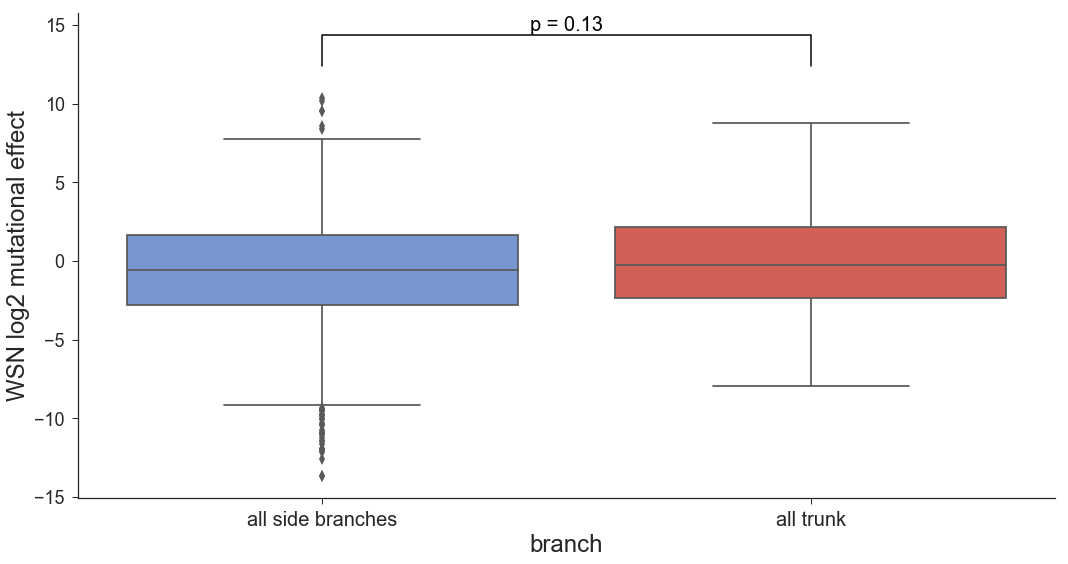

In [72]:
sns.set()
flatui = ['#6891e0', '#e54d42']
sns.color_palette(flatui)
sns.set_palette(flatui)
sns.set_style('white')
sns.set_style('ticks')
(fig, ax) = plt.subplots(figsize=(15,8))
g = sns.boxplot(data=WSNmuteffects, fliersize=8)
g.set_xticklabels(['all side branches','all trunk'])
ax.set_xlabel('branch', fontsize = 24)
ax.set_ylabel('WSN log2 mutational effect', fontsize = 24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=18)

x1, x2 = 0, 1
y, h, col = max(WSNmuteffects[0] + WSNmuteffects[1]) + 2, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "p = 0.13", ha='center', va='bottom', color=col, fontsize = 20)

sns.despine()
plt.tight_layout()
# plt.savefig('{0}/allsidebr_vs_alltrunk_WSNlogmuteffect_1968-2012.pdf'.format(plotsdir), format='pdf')
plt.show()

In [73]:
WSNtrunk_sidebr_shuffled = ShufflePrefs('trunk', all_trunk_parsed, 
                                        'side_branch', all_side_parsed, 
                                        WSNprefs, iterations = num_iter)

NameError: name 'ShufflePrefs' is not defined

In [63]:
WSNshuffleddf = pd.DataFrame.from_dict(WSNtrunk_sidebr_shuffled)
WSNshuffleddf['effectdiff'] = WSNshuffleddf.trunk - WSNshuffleddf.side_branch
print ('This is the number of trunk median minus side branch median differences \
that are greater than > {0}:'.format(WSN_trunkvssidebr_med_diff))
print (sum(e > WSN_trunkvssidebr_med_diff for e in WSNshuffleddf.effectdiff))
print ('This is {0}% of the randomizations.'.format(sum(e >= WSN_trunkvssidebr_med_diff for e in WSNshuffleddf.effectdiff)/float(num_iter)*100.0))

This is the number of trunk median minus side branch median differences that are greater than > 0.30393082392061427:
1313
This is 13.13% of the randomizations.


### Sliding window analysis

Do the mutational effects as calculated from the HA preferences degrade with increasing divergence from the HA the deep mutational scanning experiments were performed on?
To get at this question, we will now analyze the mutational effects on portions of the phylogenetic tree using a sliding window analysis.
One can imagine that the trunk and side branch mutational effect differences will diminish with increasing distance from the Perth/2009 HA, which we measured the preferences for.

In [62]:
# Create a lookup table of nodes by name.
nodes_by_name = dict([(node.name, node) for node in tree.find_clades()])

In [63]:
def make_windows(length, window, slide, start=0):
    """
    For a given length, return an iterator for intervals of length `window` with
    a slide of `slide`.
    
    >>> list(make_windows(8, 4, 0))
    [(0, 4), (4, 8)]
    >>> list(make_windows(8, 5, 0))
    [(0, 5), (5, 8)]
    >>> list(make_windows(8, 8, 0))
    [(0, 8)]
    >>> list(make_windows(8, 4, 2))
    [(0, 4), (2, 6), (4, 8)]
    >>> list(make_windows(8, 5, 2))
    [(0, 5), (2, 7), (4, 8)]
    >>> list(make_windows(7, 8, 0))
    [(0, 7)]
    >>> list(make_windows(8, 4, 2, start=2010))
    [(2010, 2014), (2012, 2016), (2014, 2018)]
    """
    if slide == 0:
        window_starts = range(start, start + length, window)
    else:
        window_starts = range(start, start + length, slide)

    for window_start in window_starts:
        yield (window_start, min(window_start + window, start + length))

        # At most, only output one window at the end of the sequence.
        if start + length <= window_start + window:
            break

In [64]:
# Window size in years.
window_size = 5

# Sliding size in years.
window_slide = 1

# Interval length in years (end year - start year).
interval_length = 2013 - 1968

In [65]:
windows = list(make_windows(interval_length, window_size, window_slide, start=1968))

In [66]:
node_by_window = defaultdict(list)

In [67]:
for node in tree.find_clades():
    for window in windows:
        # Is this node in the current window?
        if node not in unresolved_nodes:
            if node.attr["num_date"] >= window[0] and node.attr["num_date"] < window[1]:
                node_by_window[window].append(node)

In [68]:
trunk_node_by_window = defaultdict(list)

for node in tree.find_clades():
    for window in windows:
        if node not in unresolved_nodes:
            # Is this node in the current window?
            if node.attr["num_date"] >= window[0] and node.attr["num_date"] < window[1]:
                if node.is_trunk:
                    trunk_node_by_window[window].append(node)

In [69]:
sidebr_node_by_window = defaultdict(list)

for node in tree.find_clades():
    for window in windows:
        if node not in unresolved_nodes:
            # Is this node in the current window?
            if node.attr["num_date"] >= window[0] and node.attr["num_date"] < window[1]:
                if not node.is_trunk:
                    sidebr_node_by_window[window].append(node)

In [70]:
trunk_muts_by_window = {}
for window in sorted(trunk_node_by_window.keys()):
    trunkmuts = collect_mutations_by_nodes(trunk_node_by_window[window])
    prunedtrunkmuts = PruneMutList(trunkmuts)
    trunk_muts_by_window[window] = prunedtrunkmuts
    

side_muts_by_window = {}
for window in sorted(sidebr_node_by_window.keys()):
    sidemuts = collect_mutations_by_nodes(sidebr_node_by_window[window])
    prunedsidemuts = PruneMutList(sidemuts)
    side_muts_by_window[window] = prunedsidemuts

In [71]:
for window in sorted(trunk_node_by_window.keys()):
    # Report number nodes per window.
    print ('{0} has {1} trunk and {2} side branch mutations'.format(window, 
                                                                    len(trunk_muts_by_window[window]), 
                                                                    len(side_muts_by_window[window])))

(1968, 1973) has 12 trunk and 46 side branch mutations
(1969, 1974) has 16 trunk and 44 side branch mutations
(1970, 1975) has 19 trunk and 55 side branch mutations
(1971, 1976) has 15 trunk and 77 side branch mutations
(1972, 1977) has 26 trunk and 61 side branch mutations
(1973, 1978) has 22 trunk and 68 side branch mutations
(1974, 1979) has 22 trunk and 74 side branch mutations
(1975, 1980) has 19 trunk and 70 side branch mutations
(1976, 1981) has 24 trunk and 56 side branch mutations
(1977, 1982) has 13 trunk and 60 side branch mutations
(1978, 1983) has 10 trunk and 68 side branch mutations
(1979, 1984) has 9 trunk and 62 side branch mutations
(1980, 1985) has 10 trunk and 62 side branch mutations
(1981, 1986) has 8 trunk and 68 side branch mutations
(1982, 1987) has 8 trunk and 73 side branch mutations
(1983, 1988) has 13 trunk and 64 side branch mutations
(1984, 1989) has 9 trunk and 81 side branch mutations
(1985, 1990) has 11 trunk and 81 side branch mutations
(1986, 1991) h

In [72]:
trunk_muteffects_window = {}
for window in sorted(trunk_muts_by_window.keys()):
    trunkmuteffects = CalculateAllFitnessEffects(trunk_muts_by_window[window], rescaledavgprefs)
    trunk_muteffects_window[window] = trunkmuteffects

side_muteffects_window = {}
for window in sorted(side_muts_by_window.keys()):
    sidemuteffects = CalculateAllFitnessEffects(side_muts_by_window[window], rescaledavgprefs)
    side_muteffects_window[window] = sidemuteffects

In [85]:
muteffectlist_trunk = [[window, np.log2(muteffect), 'trunk'] for window in sorted(trunk_muteffects_window.keys()) for muteffect in trunk_muteffects_window[window]]
muteffectlist_side = [[window, np.log2(muteffect), 'side branch'] for window in sorted(side_muteffects_window.keys()) for muteffect in side_muteffects_window[window]]

In [86]:
windowdf = pd.DataFrame(muteffectlist_trunk, columns = ['window', 'muteffect', 'branch'])
sidedf = pd.DataFrame(muteffectlist_side, columns = ['window', 'muteffect', 'branch'])

windowdf = windowdf.append(sidedf, ignore_index=True)
windowdf = windowdf.reset_index(drop=True)

In [107]:
# Calculate the interquartile ranges of mutational effects for each window
trunk_iqrs = {}
trunk_75iqr = []
trunk_25iqr = []
for window in sorted(trunk_muteffects_window.keys()):
    q75, q25 = np.percentile(trunk_muteffects_window[window], [75, 25])
    q75, q25 = np.log2(q75), np.log2(q25)
    trunk_iqrs[window] = [q75, q25]
    trunk_75iqr.append(q75)
    trunk_25iqr.append(q25)
    
side_iqrs = {}
side_75iqr = []
side_25iqr = []
for window in sorted(side_muteffects_window.keys()):
    q75, q25 = np.percentile(side_muteffects_window[window], [75, 25])
    q75, q25 = np.log2(q75), np.log2(q25)
    side_iqrs[window] = [q75, q25]
    side_75iqr.append(q75)
    side_25iqr.append(q25)

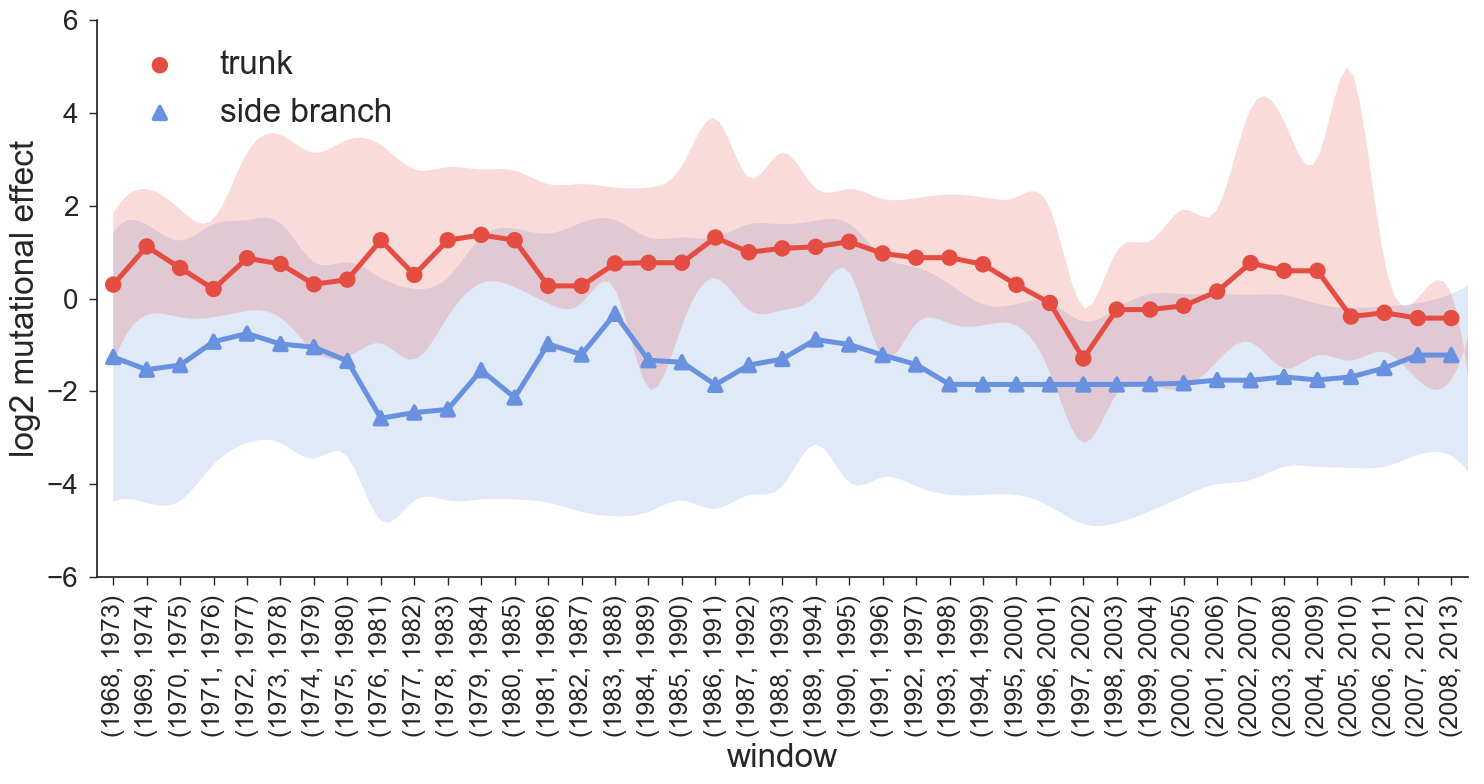

In [108]:
sns.set()
flatui = ['#e54d42', '#6891e0']
sns.color_palette(flatui)
sns.set_palette(flatui)
sns.set_style('white')
sns.set_style('ticks')
(fig, ax) = plt.subplots(figsize=(15,8))

x2 = np.linspace(0, len(windows), 200)
trunk75_spl = splrep(range(len(windows)), trunk_75iqr)
trunk25_spl = splrep(range(len(windows)), trunk_25iqr)
trunk75_y2 = splev(x2, trunk75_spl)
trunk25_y2 = splev(x2, trunk25_spl)
side75_spl = splrep(range(len(windows)), side_75iqr)
side25_spl = splrep(range(len(windows)), side_25iqr)
side75_y2 = splev(x2, side75_spl)
side25_y2 = splev(x2, side25_spl)

ax.fill_between(x2, side75_y2, side25_y2, facecolor='#6891e0', edgecolor=None, alpha=0.2, linewidth=0)
ax.fill_between(x2, trunk75_y2, trunk25_y2, facecolor='#e54d42', edgecolor=None, alpha=0.2, linewidth=0)

g = sns.pointplot(x = 'window', y = 'muteffect', hue = 'branch', 
                  data=windowdf, 
                  estimator=np.median, 
                  ci=None, 
                  markers=['o', '^'], 
                  scale=1.15)
ax.set_xlabel('window', fontsize = 24)
ax.set_ylabel('log2 mutational effect', fontsize = 24)
plt.xticks(fontsize=18, rotation='vertical')
plt.yticks(fontsize=20)
plt.ylim(-6,6)

# plt.axhline(0, linewidth=2, color='#5e5e5e', linestyle='--')

sns.despine()
plt.legend(loc = 'upper left', prop= {'size': 24})
plt.tight_layout()
# plt.savefig('{0}/sidebrvstrunk_slidingwindow_5y.pdf'.format(plotsdir), format='pdf')
plt.show()

### Sliding window analysis using WSN HA preferences

Now I will look at the mutational effects in the sliding windows using the WSN HA preferences.

In [87]:
WSN_trunk_muteffects_window = {}
for window in sorted(trunk_muts_by_window.keys()):
    WSNtrunkmuteffects = CalculateAllFitnessEffects(trunk_muts_by_window[window], WSNprefs)
    WSN_trunk_muteffects_window[window] = WSNtrunkmuteffects

WSN_side_muteffects_window = {}
for window in sorted(side_muts_by_window.keys()):
    WSNsidemuteffects = CalculateAllFitnessEffects(side_muts_by_window[window], WSNprefs)
    WSN_side_muteffects_window[window] = WSNsidemuteffects

In [88]:
WSN_muteffectlist_trunk = [[window, np.log2(muteffect), 'trunk'] for window in sorted(WSN_trunk_muteffects_window.keys()) for muteffect in WSN_trunk_muteffects_window[window]]
WSN_muteffectlist_side = [[window, np.log2(muteffect), 'side branch'] for window in sorted(WSN_side_muteffects_window.keys()) for muteffect in WSN_side_muteffects_window[window]]

In [89]:
WSN_windowdf = pd.DataFrame(WSN_muteffectlist_trunk, columns = ['window', 'muteffect', 'branch'])
WSN_sidedf = pd.DataFrame(WSN_muteffectlist_side, columns = ['window', 'muteffect', 'branch'])

WSN_windowdf = WSN_windowdf.append(WSN_sidedf, ignore_index=True)
WSN_windowdf = WSN_windowdf.reset_index(drop=True)

In [90]:
WSN_trunk_iqrs = {}
WSN_trunk_75iqr = []
WSN_trunk_25iqr = []
for window in sorted(WSN_trunk_muteffects_window.keys()):
    q75, q25 = np.percentile(WSN_trunk_muteffects_window[window], [75, 25])
    q75, q25 = np.log2(q75), np.log2(q25)
    WSN_trunk_iqrs[window] = [q75, q25]
    WSN_trunk_75iqr.append(q75)
    WSN_trunk_25iqr.append(q25)
    
WSN_side_iqrs = {}
WSN_side_75iqr = []
WSN_side_25iqr = []
for window in sorted(WSN_side_muteffects_window.keys()):
    q75, q25 = np.percentile(WSN_side_muteffects_window[window], [75, 25])
    q75, q25 = np.log2(q75), np.log2(q25)
    WSN_side_iqrs[window] = [q75, q25]
    WSN_side_75iqr.append(q75)
    WSN_side_25iqr.append(q25)

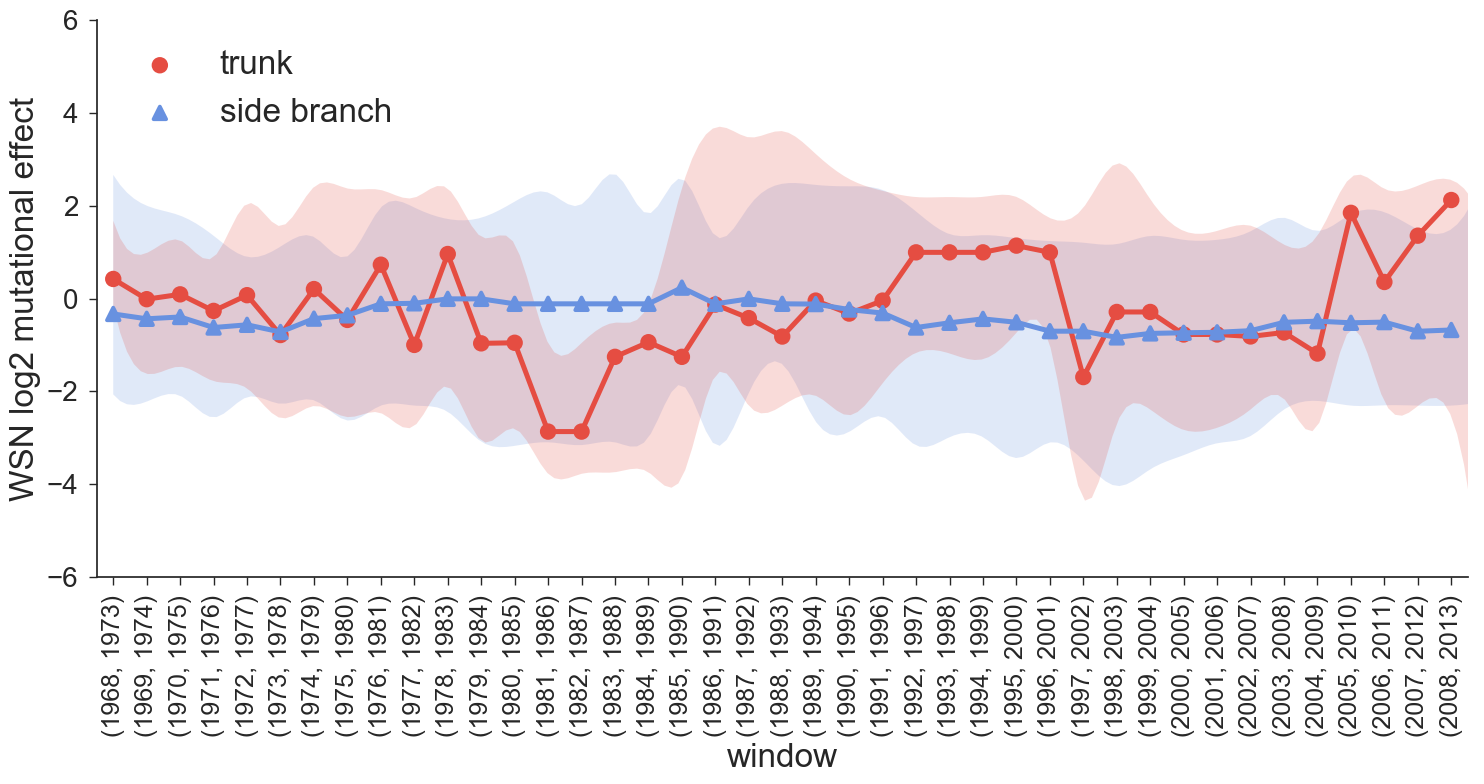

In [235]:
sns.set()
flatui = ['#e54d42', '#6891e0']
sns.color_palette(flatui)
sns.set_palette(flatui)
sns.set_style('white')
sns.set_style('ticks')
(fig, ax) = plt.subplots(figsize=(15,8))

x2 = np.linspace(0, len(windows), 200)
WSN_trunk75_spl = splrep(range(len(windows)), WSN_trunk_75iqr)
WSN_trunk25_spl = splrep(range(len(windows)), WSN_trunk_25iqr)
WSN_trunk75_y2 = splev(x2, WSN_trunk75_spl)
WSN_trunk25_y2 = splev(x2, WSN_trunk25_spl)
WSN_side75_spl = splrep(range(len(windows)), WSN_side_75iqr)
WSN_side25_spl = splrep(range(len(windows)), WSN_side_25iqr)
WSN_side75_y2 = splev(x2, WSN_side75_spl)
WSN_side25_y2 = splev(x2, WSN_side25_spl)

ax.fill_between(x2, WSN_side75_y2, WSN_side25_y2, facecolor='#6891e0', edgecolor=None, alpha=0.2, linewidth=0)
ax.fill_between(x2, WSN_trunk75_y2, WSN_trunk25_y2, facecolor='#e54d42', edgecolor=None, alpha=0.2, linewidth=0)

g = sns.pointplot(x = 'window', y = 'muteffect', hue = 'branch', 
                  data=WSN_windowdf, 
                  estimator=np.median, 
                  ci=None, 
                  markers=['o', '^'], 
                  scale=1.15)
ax.set_xlabel('window', fontsize = 24)
ax.set_ylabel('WSN log2 mutational effect', fontsize = 24)
plt.xticks(fontsize=18, rotation='vertical')
plt.yticks(fontsize=20)
plt.ylim(-6,6)

# plt.axhline(0, linewidth=2, color='#5e5e5e', linestyle='--')

sns.despine()
plt.legend(loc = 'upper left', prop= {'size': 24})
plt.tight_layout()
# plt.savefig('{0}/WSN_sidebrvstrunk_slidingwindow_5y_hline.pdf'.format(plotsdir), format='pdf')
plt.show()

### Plot sequence preference by time

Rather than just looking at mutational effects, another way to evaluate differences in the trunk vs in side branches is to calculate **sequence preference**. 

In [80]:
def calc_tolerance(aa_sequence, preferences, positions=None):
    """Calculates log odds of a node's AA sequence relative to a set of
    site-specific AA preferences.
    
    The calculation can be limited to a given list of `positions` in the
    given sequence.
    """
    # Use all positions in the given sequence by default.
    if positions is None:
        positions = list(range(len(aa_sequence)))
    
    # Create a list of keys into the preference series where the first
    # value is the zero-based protein position and the second value is
    # the amino acid at that position in the given sequence.
    aa_array = [(i, aa_sequence[i]) for i in positions]
    
    # Look up preferences for the amino acids at each site in the given
    # protein using the given `preferences` series indexed by site and 
    # amino acid.
    node_preferences = preferences[aa_array]

    # Replace missing values with a very small probability. This
    # primarily accounts for stop codons ("X") that do not have an
    # associated DMS preference.
    node_preferences = node_preferences.fillna(1e-10)

    # Calculate sum of the log of the preferences the node's amino acid
    # sequence.
    tolerance = np.log(node_preferences).sum()

    return tolerance

In [81]:
prefsdf = pd.read_csv(rescaledavgprefs)
prefsdf.index.name = "HA_position"
prefsdf = prefsdf.reset_index()

In [82]:
stacked_preferences = prefsdf.stack()

In [83]:
# Calculate sequence preference across all sites in HA.
for node in tree.find_clades():
    node.attr["tol"] = calc_tolerance(node.aa_sequence, stacked_preferences)

In [84]:
# Define epitope bitmasks where 1 includes a given position in the mask and 0 excludes it.
epitope_mask = {}

# Koel mask
epitope_mask["koel"] = "00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000110110000000000000000000000000000010001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000"

# Wolf mask
epitope_mask["wolf"] = "00000000000000000000000000000000000000000000000000000000000111110110110010100110001000000010010111100111001101010000011000001000000010001101010111111010110101111100010100111110001010110111111110100100011111011101110010100011100111111110000001111100000001010101011100000000000111001000000010110111000000000000010010110001101111110000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000"

In [85]:
epitope_sites = {}
nonepitope_sites = {}
for mask in epitope_mask.keys():
    int_mask = np.fromstring(epitope_mask[mask], "S1").astype(np.int0)
    epitope_sites[mask] = [i for i in range(len(int_mask))
                           if int_mask[i] == 1]
    nonepitope_sites[mask] = [i for i in range(len(int_mask))
                              if int_mask[i] == 0]

In [86]:
# Calculate sequence preference across epitope and non-epitope mask sites in HA.
for node in tree.find_clades():
    for mask in epitope_sites.keys():
        node.attr["tol_epitope_%s" % mask] = calc_tolerance(
            node.aa_sequence,
            stacked_preferences,
            epitope_sites[mask]
        ) / len(epitope_sites[mask])
        
        node.attr["tol_nonepitope_%s" % mask] = calc_tolerance(
            node.aa_sequence,
            stacked_preferences,
            nonepitope_sites[mask]
        ) / len(nonepitope_sites[mask])

In [87]:
num_sites = len(tree.root.aa_sequence)
num_epitope_sites = len(epitope_sites["wolf"])
num_nonepitope_sites = len(nonepitope_sites["wolf"])

for node in tree.find_clades():
    node.attr["mutation_sites"] = [i for i in range(num_sites)
                                   if tree.root.aa_sequence[i] != node.aa_sequence[i]]
    
    node.attr["mutations"] = len(node.attr["mutation_sites"])
    node.attr["epitope_mutations"] = len([i for i in node.attr["mutation_sites"]
                                          if i in epitope_sites["wolf"]])
    node.attr["nonepitope_mutations"] = len([i for i in node.attr["mutation_sites"]
                                             if i in nonepitope_sites["wolf"]])
    
    node.attr["mutations_per_site"] = node.attr["mutations"] / num_sites
    node.attr["epitope_mutations_per_site"] = node.attr["epitope_mutations"] / num_epitope_sites
    node.attr["nonepitope_mutations_per_site"] = node.attr["nonepitope_mutations"] / num_nonepitope_sites

In [88]:
def get_parent_attribute(parent, attr, default=0):
    if parent is not None:
        value = parent.attr.get(attr, default)
    else:
        value = default
        
    return value

In [89]:
# Collect sequence preference, date, and trunk status for each
# node prior to the MRCA of all recent nodes.
nodes = []
for node in tree.find_clades():
    if node not in unresolved_nodes:
        node_values = {
            "epitope_mutations": node.attr["epitope_mutations"],
            "nonepitope_mutations": node.attr["nonepitope_mutations"],
            "mutations_per_site": node.attr["mutations_per_site"],
            "epitope_mutations_per_site": node.attr["epitope_mutations_per_site"],
            "nonepitope_mutations_per_site": node.attr["nonepitope_mutations_per_site"],
            "preference": node.attr["tol"] / len(node.aa_sequence),
            "date": node.attr["num_date"],
            "trunk": node.is_trunk,
            "terminal": node.is_terminal(),
            "name": node.name,
            "parent_date": node.parent is not None and node.parent.attr["num_date"] or 0,
            "parent_preference": node.parent is not None and (node.parent.attr["tol"] / len(node.aa_sequence)) or 0,
            "parent_epitope_mutations": node.parent is not None and node.parent.attr["epitope_mutations"] or 0,
            "parent_nonepitope_mutations": node.parent is not None and node.parent.attr["nonepitope_mutations"] or 0,
            "parent_mutations_per_site": get_parent_attribute(node.parent, "mutations_per_site"),
            "parent_epitope_mutations_per_site": get_parent_attribute(node.parent, "epitope_mutations_per_site"),
            "parent_nonepitope_mutations_per_site": get_parent_attribute(node.parent, "nonepitope_mutations_per_site")
        }
        
        for mask in epitope_sites.keys():
            node_values["preference_epitope_%s" % mask] = node.attr["tol_epitope_%s" % mask]
            node_values["preference_nonepitope_%s" % mask] = node.attr["tol_nonepitope_%s" % mask]

            node_values["parent_preference_epitope_%s" % mask] = node.parent is not None and node.parent.attr["tol_epitope_%s" % mask] or 0
            node_values["parent_preference_nonepitope_%s" % mask] = node.parent is not None and node.parent.attr["tol_nonepitope_%s" % mask] or 0
            
        nodes.append(node_values)

In [90]:
preference_df = pd.DataFrame(nodes)

In [91]:
colors = ("#e54d42",
          "#6891e0",
          "#ffd800",
          "#547BD3",
          "#DF4327")

In [92]:
def plot_preference_tree(ax, segments, trunk_preference, non_trunk_preference, dms_preference,
                         preference_key="preference", legend=True, tick_multiple=1):
    # Draw line segments between each node and its parent to represent the tree.
    lc = LineCollection(segments, zorder=1)
    lc.set_alpha(0.6)
    lc.set_color("black")
    lc.set_linewidth(1)
    ax.add_collection(lc)

    # Draw non-trunk (side branch) nodes.
    ax.scatter(
        non_trunk_preference["date"],
        non_trunk_preference[preference_key],
        s=40,
        c=colors[1],
        alpha=0.5,
        label="Side branch"
    )

    # Draw trunk nodes.
    ax.scatter(
        trunk_preference["date"],
        trunk_preference[preference_key],
        s=40,
        c=colors[0],
        alpha=1,
        label="Trunk"
    )

    # Draw the DMS strain with a distinct marker.
    ax.scatter(
        dms_preference["date"],
        dms_preference[preference_key],
        s=500,
        c=colors[2],
        marker="*",
        zorder=10,
        edgecolors='k',
        linewidth='1',
        label="A/Perth/16/2009"
    )

    # Label axes.
    ax.set_xlabel("Year")
    ax.set_ylabel("Sequence preference")

    # Fix y-axis tick units.
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(tick_multiple))
    
    # Add legend.
    if legend:
        ax.legend()

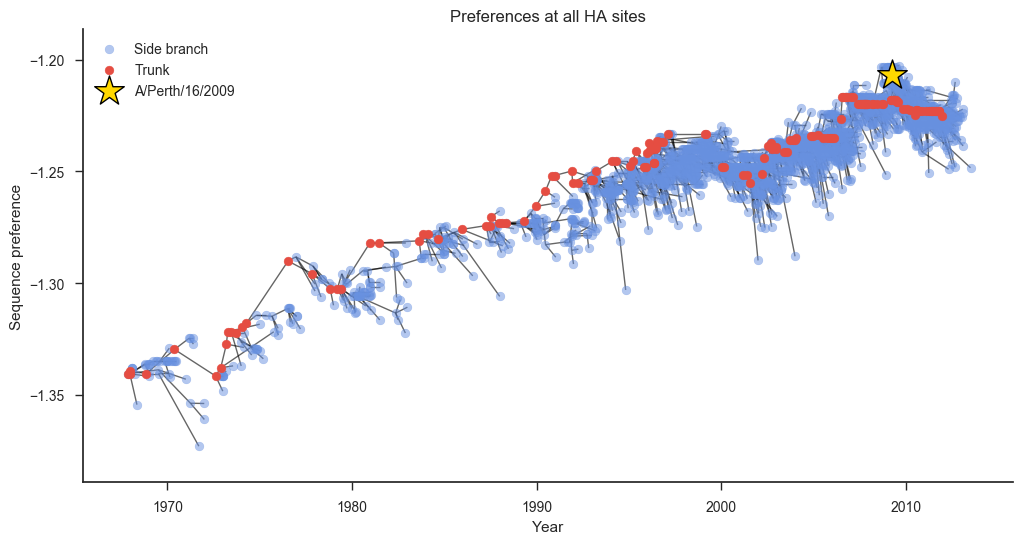

In [81]:
sns.set()
sns.set_style('white')
sns.set_style('ticks')
from matplotlib import gridspec

preference_key = "preference"
trunk_preference = preference_df[preference_df["trunk"] == True].copy()
non_trunk_preference = preference_df[(preference_df["trunk"] == False)].copy()
dms_preference = preference_df[preference_df["name"] == "A/Perth/16/2009"]

# Build a list of lines for each preference entry from one node to its parent.
segments = preference_df[preference_df["parent_date"] > 0].apply(
    lambda row: [(row["date"], row[preference_key]), (row["parent_date"], row["parent_%s" % preference_key])],
    axis=1
).values

fig = plt.subplots(figsize=(12, 6), facecolor='w')

gs = gridspec.GridSpec(1, 1, height_ratios=[1], width_ratios=[1], hspace=0.25, wspace=0.1)

# Plot complete tree.
ax = plt.subplot(gs[0])
plot_preference_tree(ax, segments, trunk_preference, non_trunk_preference, dms_preference, preference_key,
                     tick_multiple=0.05)
ax.set_title("Preferences at all HA sites")
sns.despine(ax=ax)
# plt.savefig('{0}/H3_sequencepref_allsites.pdf'.format(plotsdir), format='pdf')
plt.show()

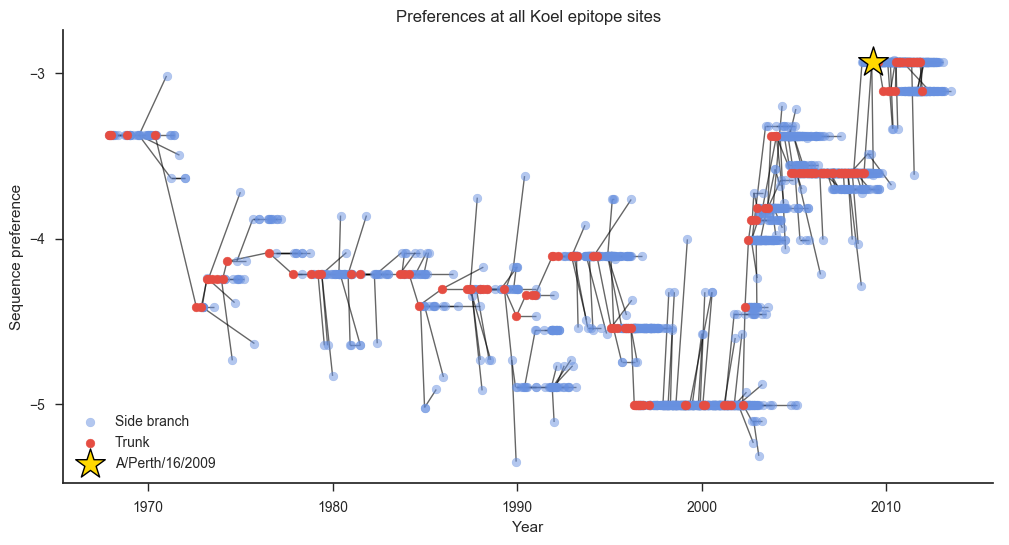

In [82]:
sns.set()
sns.set_style('white')
sns.set_style('ticks')
from matplotlib import gridspec

preference_key = "preference_epitope_koel"
trunk_preference = preference_df[preference_df["trunk"] == True].copy()
non_trunk_preference = preference_df[(preference_df["trunk"] == False)].copy()
dms_preference = preference_df[preference_df["name"] == "A/Perth/16/2009"]

# Build a list of lines for each preference entry from one node to its parent.
segments = preference_df[preference_df["parent_date"] > 0].apply(
    lambda row: [(row["date"], row[preference_key]), (row["parent_date"], row["parent_%s" % preference_key])],
    axis=1
).values

fig = plt.subplots(figsize=(12, 6), facecolor='w')

gs = gridspec.GridSpec(1, 1, height_ratios=[1], width_ratios=[1], hspace=0.25, wspace=0.1)

# Plot complete tree.
ax = plt.subplot(gs[0])
plot_preference_tree(ax, segments, trunk_preference, non_trunk_preference, dms_preference, preference_key)
ax.set_title("Preferences at all Koel epitope sites")
sns.despine(ax=ax)
plt.show()

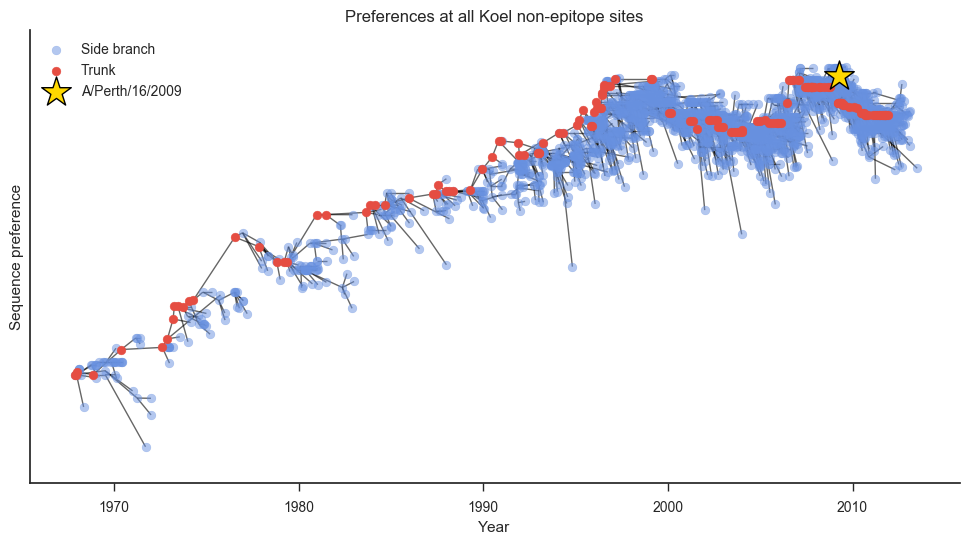

In [83]:
sns.set()
sns.set_style('white')
sns.set_style('ticks')
from matplotlib import gridspec

preference_key = "preference_nonepitope_koel"
trunk_preference = preference_df[preference_df["trunk"] == True].copy()
non_trunk_preference = preference_df[(preference_df["trunk"] == False)].copy()
dms_preference = preference_df[preference_df["name"] == "A/Perth/16/2009"]

# Build a list of lines for each preference entry from one node to its parent.
segments = preference_df[preference_df["parent_date"] > 0].apply(
    lambda row: [(row["date"], row[preference_key]), (row["parent_date"], row["parent_%s" % preference_key])],
    axis=1
).values

fig = plt.subplots(figsize=(12, 6), facecolor='w')

gs = gridspec.GridSpec(1, 1, height_ratios=[1], width_ratios=[1], hspace=0.25, wspace=0.1)

# Plot complete tree.
ax = plt.subplot(gs[0])
plot_preference_tree(ax, segments, trunk_preference, non_trunk_preference, dms_preference, preference_key)
ax.set_title("Preferences at all Koel non-epitope sites")
sns.despine(ax=ax)
plt.show()

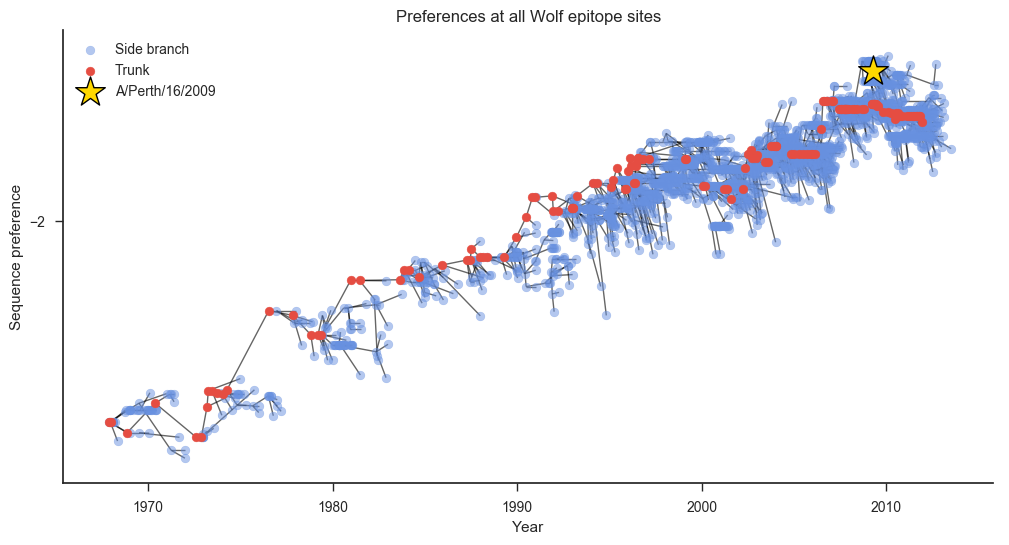

In [84]:
sns.set()
sns.set_style('white')
sns.set_style('ticks')
from matplotlib import gridspec

preference_key = "preference_epitope_wolf"
trunk_preference = preference_df[preference_df["trunk"] == True].copy()
non_trunk_preference = preference_df[(preference_df["trunk"] == False)].copy()
dms_preference = preference_df[preference_df["name"] == "A/Perth/16/2009"]

# Build a list of lines for each preference entry from one node to its parent.
segments = preference_df[preference_df["parent_date"] > 0].apply(
    lambda row: [(row["date"], row[preference_key]), (row["parent_date"], row["parent_%s" % preference_key])],
    axis=1
).values

fig = plt.subplots(figsize=(12, 6), facecolor='w')

gs = gridspec.GridSpec(1, 1, height_ratios=[1], width_ratios=[1], hspace=0.25, wspace=0.1)

# Plot complete tree.
ax = plt.subplot(gs[0])
plot_preference_tree(ax, segments, trunk_preference, non_trunk_preference, dms_preference, preference_key)
ax.set_title("Preferences at all Wolf epitope sites")
sns.despine(ax=ax)
# plt.savefig('{0}/H3_sequencepref_Wolf_epitope.pdf'.format(plotsdir), format='pdf')
plt.show()

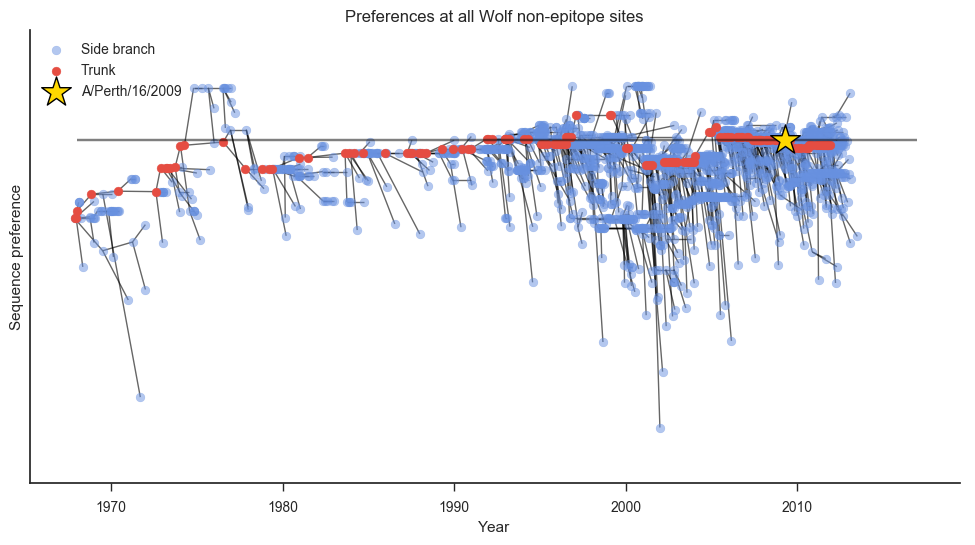

In [86]:
sns.set()
sns.set_style('white')
sns.set_style('ticks')
from matplotlib import gridspec

preference_key = "preference_nonepitope_wolf"
trunk_preference = preference_df[preference_df["trunk"] == True].copy()
non_trunk_preference = preference_df[(preference_df["trunk"] == False)].copy()
dms_preference = preference_df[preference_df["name"] == "A/Perth/16/2009"]

# Build a list of lines for each preference entry from one node to its parent.
segments = preference_df[preference_df["parent_date"] > 0].apply(
    lambda row: [(row["date"], row[preference_key]), (row["parent_date"], row["parent_%s" % preference_key])],
    axis=1
).values

fig = plt.subplots(figsize=(12, 6), facecolor='w')

gs = gridspec.GridSpec(1, 1, height_ratios=[1], width_ratios=[1], hspace=0.25, wspace=0.1)

# Plot complete tree.
ax = plt.subplot(gs[0])
plot_preference_tree(ax, segments, trunk_preference, non_trunk_preference, dms_preference, preference_key)
ax.set_title("Preferences at all Wolf non-epitope sites")
ax.hlines(dms_preference[preference_key], 1968, 2017, color="black", alpha=0.5)
sns.despine(ax=ax)
# plt.savefig('{0}/H3_sequencepref_Wolf_nonepitope.pdf'.format(plotsdir), format='pdf')
plt.show()

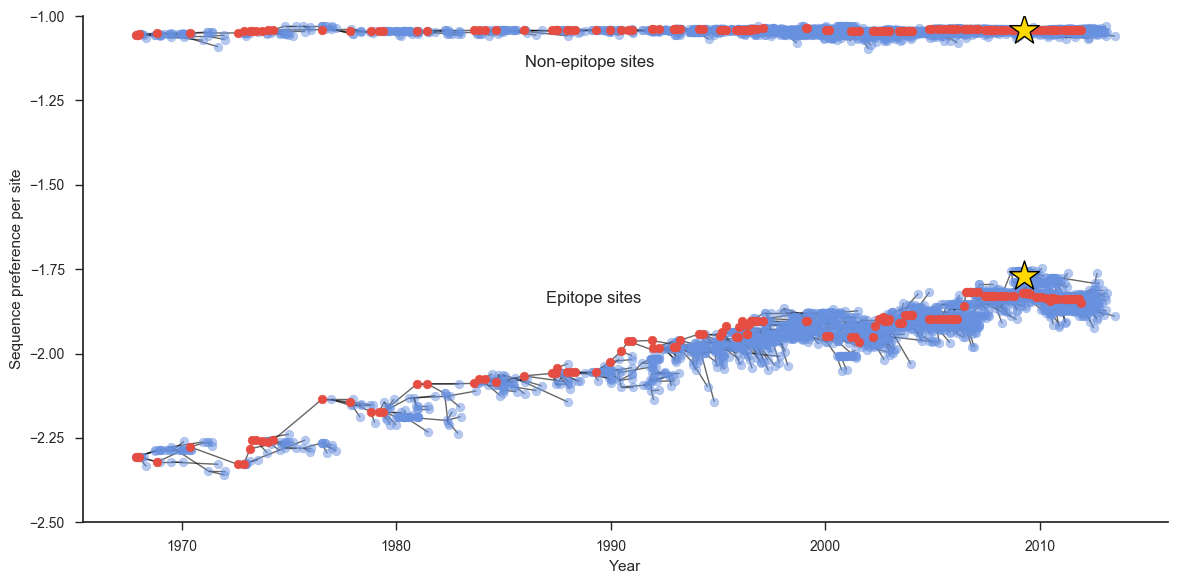

In [152]:
# Set styles.
sns.set()
sns.set_style('white')
sns.set_style('ticks')
from matplotlib import gridspec

# Prepare data frames.
trunk_preference = preference_df[preference_df["trunk"] == True].copy()
non_trunk_preference = preference_df[(preference_df["trunk"] == False)].copy()
dms_preference = preference_df[preference_df["name"] == "A/Perth/16/2009"]

# Create base figures.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6), facecolor='w')
#ax = axes[0]

#
# Plot sequence preference per epitope site.
#

# Build a list of lines for each preference entry from one node to its parent.
preference_key = "preference_epitope_wolf"
segments = preference_df[preference_df["parent_date"] > 0].apply(
    lambda row: [(row["date"], row[preference_key]), (row["parent_date"], row["parent_%s" % preference_key])],
    axis=1
).values

plot_preference_tree(ax, segments, trunk_preference, non_trunk_preference, dms_preference, preference_key,
                     legend=False, tick_multiple=0.05)

#
# Plot sequence preference per non-epitope site.
#

# Build a list of lines for each preference entry from one node to its parent.
preference_key = "preference_nonepitope_wolf"
segments = preference_df[preference_df["parent_date"] > 0].apply(
    lambda row: [(row["date"], row[preference_key]), (row["parent_date"], row["parent_%s" % preference_key])],
    axis=1
).values

plot_preference_tree(ax, segments, trunk_preference, non_trunk_preference, dms_preference, preference_key,
                     legend=False, tick_multiple=0.25)

ax.text(1987, -1.85, "Epitope sites")
ax.text(1986, -1.15, "Non-epitope sites")
ax.set_ylim(-2.5, -1)
ax.set_ylabel("Sequence preference per site")
sns.despine(ax=ax)

plt.tight_layout()
# plt.savefig('{0}/H3_sequencepref_Wolf_sites.pdf'.format(plotsdir), format='pdf')
plt.show()

## Look at nodes that descend from the trunk after Perth/2009

In [73]:
# Find the MRCA of any recent node and the Perth strain.
perth_mrca = tree.common_ancestor([recent_nodes[0], dms_strain])

In [74]:
perth_mrca

Clade(aa_sequence='MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTITNDQIEVTNATE...', clade=2208, is_side_branch_ancestor=False, is_trunk=True, name='NODE_0001216', strain='NODE_0001216', tvalue=40.04199, xvalue=0.17641, yvalue=902.14883)

In [75]:
# Prune all nodes in the corresponding child clades of that MRCA containing Perth.
trunk_clades = [clade for clade in perth_mrca.clades if clade.is_trunk]
perth_mrca.clades = trunk_clades

In [76]:
nodes_prior_to_perth = []
for node in tree.find_clades():
    if node == perth_mrca:
        break
        
    nodes_prior_to_perth.append(node)

In [78]:
len(nodes_prior_to_perth)

2196

In [93]:
prior_to_perth_preferences_df = pd.DataFrame([{"trunk": node.is_trunk, "preference": node.attr["tol"] / 566}
                                              for node in nodes_prior_to_perth])

In [94]:
prior_to_perth_preferences_df["trunk"].value_counts()

False    2086
True      110
Name: trunk, dtype: int64

In [95]:
perth_mrca_resolved_nodes = list(set(list(perth_mrca.find_clades())) - set(unresolved_nodes))

In [96]:
perth_mrca_preferences_df = pd.DataFrame([{"trunk": node.is_trunk, "preference": node.attr["tol"] / 566}
                                          for node in perth_mrca_resolved_nodes])

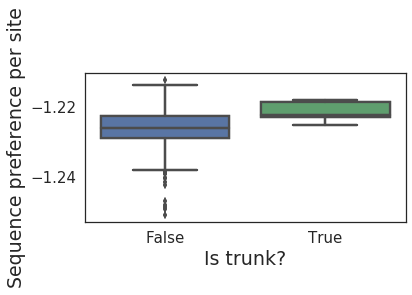

In [98]:
ax = sns.boxplot(x="trunk", y="preference", data=perth_mrca_preferences_df)
ax.set_xlabel("Is trunk?")
ax.set_ylabel("Sequence preference per site")
plt.tight_layout()
plt.show()

In [100]:
len(perth_mrca_resolved_nodes)

549

In [101]:
perth_mrca_trunk_path = [node for node in perth_mrca_resolved_nodes
              if node.is_trunk]
len(perth_mrca_trunk_path)

37

In [102]:
# Find all nodes that are not on the trunk. These are
# side branch nodes.
perth_mrca_side_branch_nodes = [node for node in perth_mrca_resolved_nodes
                     if not node.is_trunk and node not in unresolved_nodes]

print ('There are {0} side branch nodes.'.format(len(perth_mrca_side_branch_nodes)))

There are 512 side branch nodes.


In [105]:
# Save all mutations along the trunk.
perth_mrca_trunk_mutations = collect_mutations_by_nodes(perth_mrca_trunk_path)

# Save all mutations from any side branch node.
perth_mrca_side_branch_mutations = collect_mutations_by_nodes(perth_mrca_side_branch_nodes)

In [107]:
perth_mrca_trunk_muts = PruneMutList(perth_mrca_trunk_mutations)
perth_mrca_side_muts = PruneMutList(perth_mrca_side_branch_mutations)

In [110]:
perth_mrca_trunk_muts_effects = CalculateAllFitnessEffects(perth_mrca_trunk_muts, rescaledavgprefs)
perth_mrca_side_muts_effects = CalculateAllFitnessEffects(perth_mrca_side_muts, rescaledavgprefs)

In [111]:
print ('The median of trunk mutational effects = {0}'.format(np.median(perth_mrca_trunk_muts_effects)))
print ('The median of side branch mutational effects = {0}'.format(np.median(perth_mrca_side_muts_effects)))

perthmrca_med_diff = np.log2(np.median(perth_mrca_trunk_muts_effects)) - np.log2(np.median(perth_mrca_side_muts_effects))

print ('The difference between the medians of \
trunk and side branch mutational effects = {0}'.format(perthmrca_med_diff))

The median of trunk mutational effects = 0.7471697431210704
The median of side branch mutational effects = 0.5455749491901483
The difference between the medians of trunk and side branch mutational effects = 0.45365863123735983


In [116]:
perthmrca_muteffects = []
perthmrca_muteffects.append([e for e in np.log2(perth_mrca_side_muts_effects)])
perthmrca_muteffects.append([e for e in np.log2(perth_mrca_trunk_muts_effects)])

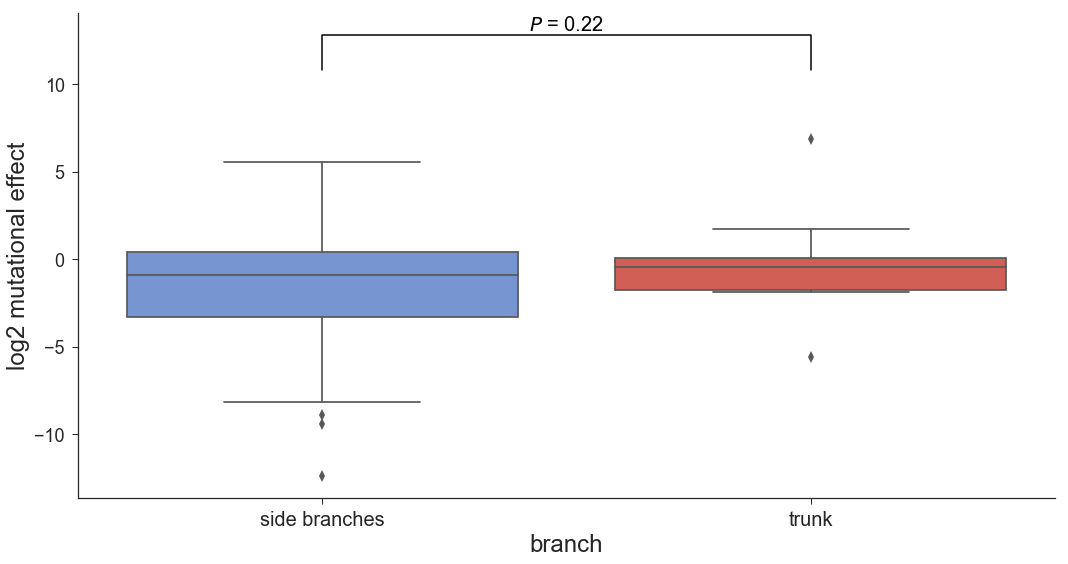

In [121]:
sns.set()
flatui = ['#6891e0', '#e54d42']
sns.color_palette(flatui)
sns.set_palette(flatui)
sns.set_style('white')
sns.set_style('ticks')
(fig, ax) = plt.subplots(figsize=(15,8))
g = sns.boxplot(data=perthmrca_muteffects, fliersize=8)
g.set_xticklabels(['side branches','trunk'])
ax.set_xlabel('branch', fontsize = 24)
ax.set_ylabel('log2 mutational effect', fontsize = 24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=18)

x1, x2 = 0, 1
y, h, col = max(allmuteffects[0] + allmuteffects[1]) + 2, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "$P$ = 0.22", ha='center', va='bottom', color=col, fontsize = 20)

sns.despine()
plt.tight_layout()
# plt.savefig('{0}/perth_mrca_trunk_sidebr.pdf'.format(plotsdir), format='pdf')
plt.show()

In [118]:
perth_mrca_trunk_parsed = ParseMutListToTuples(perth_mrca_trunk_muts)
perth_mrca_side_parsed = ParseMutListToTuples(perth_mrca_side_muts)

In [119]:
trunk_sidebr_shuffled = ShufflePrefs('trunk', perth_mrca_trunk_parsed, 
                                     'side_branch', perth_mrca_side_parsed, 
                                      rescaledavgprefs, iterations = num_iter)

In [122]:
perth_mrca_shuffleddf = pd.DataFrame.from_dict(trunk_sidebr_shuffled)
perth_mrca_shuffleddf['effectdiff'] = perth_mrca_shuffleddf.trunk - perth_mrca_shuffleddf.side_branch
print ('This is the number of trunk median minus side branch median differences \
that are greater than > {0}:'.format(perthmrca_med_diff))
print (sum(e > perthmrca_med_diff for e in perth_mrca_shuffleddf.effectdiff))
print ('This is {0}% of the randomizations.'.format(sum(e >= perthmrca_med_diff for e in perth_mrca_shuffleddf.effectdiff)/float(num_iter)*100.0))

This is the number of trunk median minus side branch median differences that are greater than > 0.45365863123735983:
2222
This is 22.220000000000002% of the randomizations.


## Calculate H1N1 trunk and side branch mutational effects using the WSN preferences

In [110]:
# Load H1N1 tree JSON file.
with gzip.open("./data/h1n1_tree.json.gz", "rb") as json_uncompressed_fh:
    h1n1_json_tree = json.load(reader(json_uncompressed_fh))

In [111]:
h1n1_tree = json_to_tree(h1n1_json_tree)

In [112]:
for node in h1n1_tree.find_clades():
    stop_codons = 0
    
    if hasattr(node, "aa_muts"):
        for segment in node.aa_muts:
            for mutation in node.aa_muts[segment]:
                if mutation.endswith("X"):
                    stop_codons += 1

        node.attr["stop_codons"] = stop_codons
    else:
        node.attr["stop_codons"] = None

In [113]:
h1n1_nodes_with_stop_codons = sorted([(node.name, node.attr["stop_codons"])
                                 for node in h1n1_tree.find_clades()
                                 if node.attr["stop_codons"] is not None and node.attr["stop_codons"] > 0],
                                key=lambda node: node[1],
                                reverse=True)

In [114]:
h1n1_node_names_with_stop_codons = [node[0] for node in h1n1_nodes_with_stop_codons if node[0].startswith("A/")]

In [115]:
h1n1_node_names_with_stop_codons

['A/SouthAustralia/4/2008']

In [116]:
for node in h1n1_node_names_with_stop_codons:
    h1n1_tree.prune(node)

In [117]:
len([node for node in h1n1_tree.find_clades()])

3595

In [118]:
parents_by_node = all_parents(h1n1_tree)

In [119]:
# Next, annotate each node with its parent.
for node in h1n1_tree.find_clades():
    if node == h1n1_tree.root:
        node.parent = None
    else:
        node.parent = parents_by_node[node]

In [120]:
# Find all tips of the tree sampled since 2017.
h1n1_recent_nodes = [node for node in h1n1_tree.get_terminals() if node.attr["num_date"] > 2009.0]

In [121]:
len(h1n1_recent_nodes)

394

In [122]:
# Find the last common ancestor of all recent nodes.
h1n1_mrca = h1n1_tree.common_ancestor(h1n1_recent_nodes)

In [123]:
h1n1_mrca

Clade(aa_sequence='MKVKLLVLLCTFTATYADTICIGYHANNSTDTVDTVLEKNVTVTHSVNLLEDSHNGK...', clade=1405, name='NODE_0000966', strain='NODE_0000966', tvalue=25.50748, xvalue=0.08674, yvalue=1078.22184)

In [124]:
h1n1_mrca.attr["num_date"]

2003.9304362258556

In [125]:
# Label all nodes as not part of the trunk or as a side branch ancestor
# by default.
for node in h1n1_tree.find_clades():
    node.is_trunk = False
    node.is_side_branch_ancestor = False

In [126]:
# Find all nodes that are ancestral to recent nodes.
# Label these ancestral nodes as part of the "trunk"
# and collect the set of distinct nodes in the trunk.
for recent_node in h1n1_recent_nodes:
    current_node = recent_node.parent
    
    # Traverse from the current node to the tree's root.
    while current_node != h1n1_tree.root:
        # Mark a node as part of the trunk if it was sampled
        # before the MRCA of all recent nodes.
        if current_node.attr["num_date"] < h1n1_mrca.attr["num_date"]:
            current_node.is_trunk = True
            
        current_node = current_node.parent

In [127]:
# Make a list of nodes that are descendants of the MRCA of recent nodes.
# These are "unresolved" nodes.
h1n1_unresolved_nodes = [node for node in h1n1_mrca.find_clades()]

In [128]:
nodes_in_h1n1_tree = len([node for node in h1n1_tree.find_clades()])
nodes_in_h1n1_tree

3595

In [129]:
h1n1_tips = [node for node in h1n1_tree.find_clades() if node.is_terminal()]

In [130]:
len(h1n1_tips)

1986

In [131]:
h1n1_trunk_path = [node for node in h1n1_tree.find_clades()
              if node.is_trunk]

In [132]:
len(h1n1_trunk_path)

38

In [133]:
# Find all nodes that are not on the trunk. These are
# side branch nodes.
h1n1_side_branch_nodes = [node for node in h1n1_tree.find_clades()
                     if not node.is_trunk and node not in h1n1_unresolved_nodes]

print ('There are {0} side branch nodes.'.format(len(h1n1_side_branch_nodes)))

There are 1367 side branch nodes.


In [134]:
h1n1_trunk_path_names = [node.name for node in h1n1_trunk_path]

In [135]:
h1n1_internal_side_branch_nodes = [node for node in h1n1_side_branch_nodes
                              if not node.is_terminal()]

print ('There are {0} side branch internal nodes.'.format(len(h1n1_internal_side_branch_nodes)))

There are 583 side branch internal nodes.


In [136]:
h1n1_terminal_side_branch_nodes = [node for node in h1n1_side_branch_nodes
                              if node.is_terminal()]

print ('There are {0} side branch terminal nodes.'.format(len(h1n1_terminal_side_branch_nodes)))

There are 784 side branch terminal nodes.


In [137]:
# Calculate the proportion of the tree on the trunk.
len(h1n1_trunk_path) / float(nodes_in_h1n1_tree)

0.010570236439499305

In [141]:
# Color nodes by status as on the trunk or as a side branch ancestor.
for node in h1n1_tree.find_clades():
    if node.is_trunk:
        node.attr["trunk_status"] = "trunk"
    elif node in h1n1_side_branch_nodes:
        node.attr["trunk_status"] = "side_branch"
    else:
        node.attr["trunk_status"] = "unresolved"

In [142]:
cmap = {
    "trunk": "#e54d42",
    "side_branch": "#6891e0", 
    "unresolved": "#afafaf"}

label_map = {
    "trunk": "Trunk",
    "side_branch": "Side branch", 
    "unresolved": "Unresolved"}

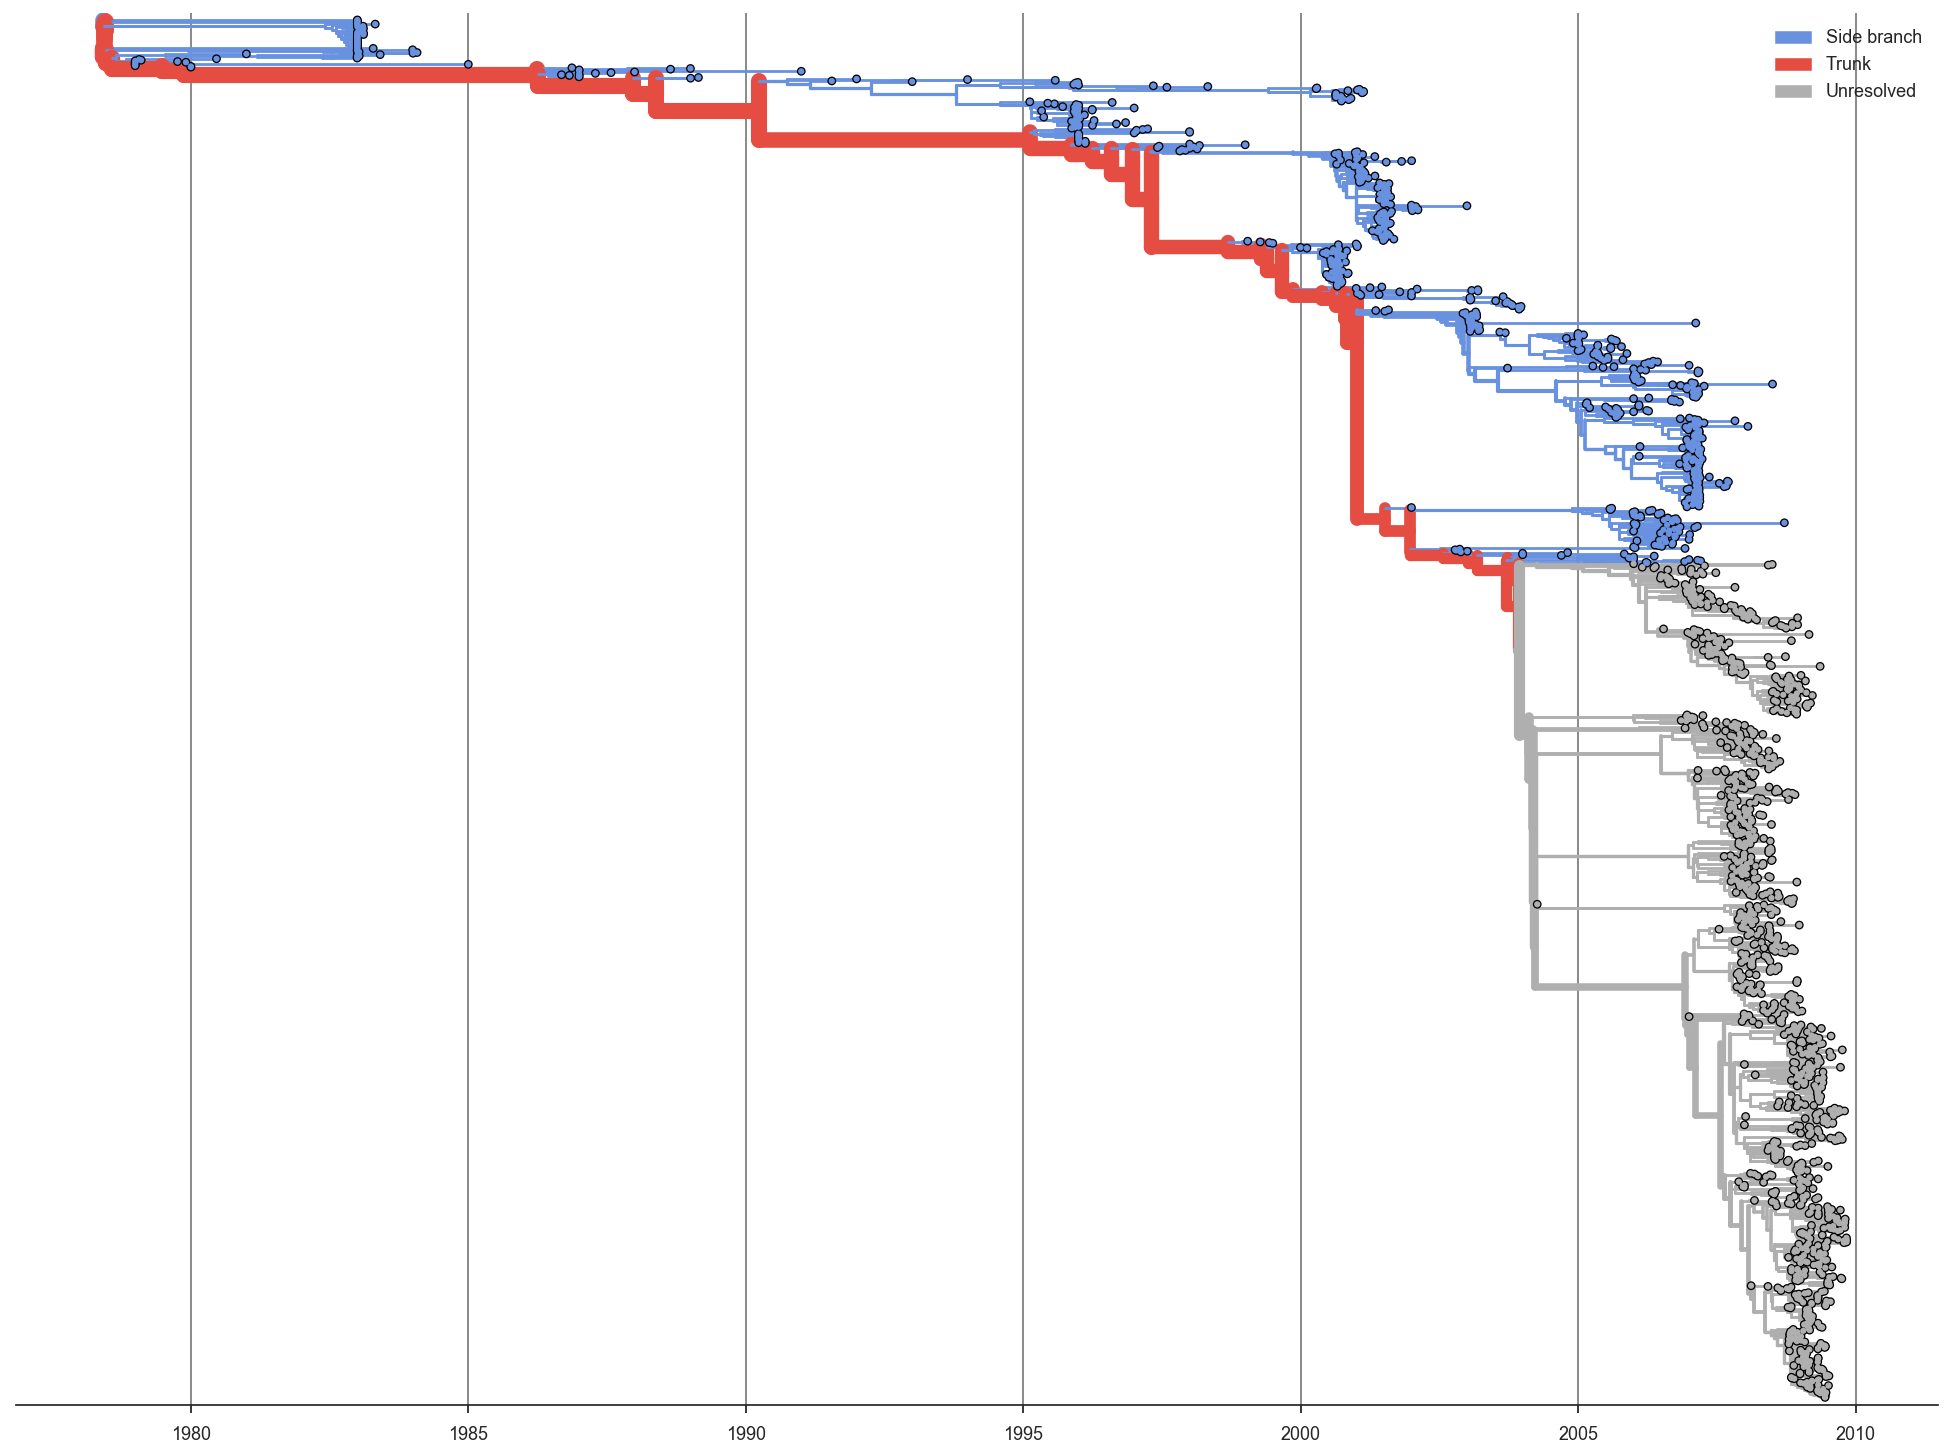

In [143]:
# Plot H1N1 tree in BALTIC style from Bio.Phylo tree.
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 100

# Use simple plot style with figures sized for context of a talk.
sns.set_style("ticks")
sns.set_context("talk")

mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.size']=22

yvalues = [node.yvalue for node in h1n1_tree.find_clades()]
y_span = max(yvalues)

trait_name = "trunk_status"
fig, ax = plt.subplots(figsize=(20,15), facecolor='w')

L=len([k for k in h1n1_tree.find_clades() if k.is_terminal()])

# Setup arrays for tip and internal node coordinates.
tip_circles_x = []
tip_circles_y = []
tip_circles_color = []
node_circles_x = []
node_circles_y = []
node_circles_color = []

for k in h1n1_tree.find_clades(): ## iterate over objects in tree
    x=k.attr["num_date"] ## or from x position determined earlier
    y=k.yvalue ## get y position from .drawTree that was run earlier, but could be anything else
    
    if k.parent is None:
        xp = None
    else:
        xp=k.parent.attr["num_date"] ## get x position of current object's parent

    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp=x
        
    c='k'
    label = ''
    if trait_name in k.attr:
        c = cmap[k.attr[trait_name]]
        label = label_map.get(k.attr[trait_name])
    
    branchWidth=2
    if k.is_terminal(): ## if leaf...
        s=20 ## tip size can be fixed
        
        tip_circles_x.append(x)
        tip_circles_y.append(y)
        tip_circles_color.append(c)
    else: ## if node...
        k_leaves = [child
                    for child in k.find_clades()
                    if child.is_terminal()]
        branchWidth+=10.0*len(k_leaves)/float(L)
        
        if len(k.clades)==1:
            node_circles_x.append(x)
            node_circles_y.append(y)
            node_circles_color.append(c)

        ax.plot([x,x],[k.clades[-1].yvalue, k.clades[0].yvalue], lw=branchWidth, color=c, ls='-', zorder=9, solid_capstyle='round')
        
    ax.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9, label=label)

# Add circles for tips and internal nodes.
ax.scatter(tip_circles_x, tip_circles_y, s=s, facecolor=tip_circles_color, edgecolor='none',zorder=11) ## plot circle for every tip
ax.scatter(tip_circles_x, tip_circles_y, s=s*2, facecolor='k', edgecolor='none', zorder=10) ## plot black circle underneath
ax.scatter(node_circles_x, node_circles_y, facecolor=node_circles_color, s=50, edgecolor='none', zorder=10, lw=2, marker='|') ## mark every node in the tree to highlight that it's a multitype tree

ax.set_ylim(-10, y_span + 10)

ax.spines['top'].set_visible(False) ## no axes
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.grid(axis='x',ls='-',color='grey')
ax.tick_params(axis='y',size=0)
ax.set_yticklabels([])

# Add legend for colors.
patches = []
for key in label_map.keys():
    patches.append(mpatches.Patch(color=cmap[key], label=label_map[key]))
    
ax.legend(handles=patches)

plt.tight_layout()
plt.show()

In [144]:
# Save all mutations along the trunk.
h1n1_trunk_mutations = collect_mutations_by_nodes(h1n1_trunk_path)

# Save all mutations from any side branch node.
h1n1_side_branch_mutations = collect_mutations_by_nodes(h1n1_side_branch_nodes)

# Save all mutations from side branch internal nodes
h1n1_internal_node_mutations = collect_mutations_by_nodes(h1n1_internal_side_branch_nodes)

# Save all mutations from side branch terminal nodes
h1n1_terminal_node_mutations = collect_mutations_by_nodes(h1n1_terminal_side_branch_nodes)

In [145]:
h1n1_trunk_muts = PruneMutList(h1n1_trunk_mutations)
h1n1_side_muts = PruneMutList(h1n1_side_branch_mutations)
h1n1_internal_node_muts = PruneMutList(h1n1_internal_node_mutations)
h1n1_terminal_node_muts = PruneMutList(h1n1_terminal_node_mutations)

print ('There are {0} total trunk mutations.'.format(len(h1n1_trunk_muts)))
print ('There are {0} total side branch mutations.'.format(len(h1n1_side_muts)))
print ('There are {0} total internal node mutations.'.format(len(h1n1_internal_node_muts)))
print ('There are {0} total terminal node mutations.'.format(len(h1n1_terminal_node_muts)))

There are 45 total trunk mutations.
There are 671 total side branch mutations.
There are 182 total internal node mutations.
There are 489 total terminal node mutations.


In [146]:
WSNprefs = '{0}/WSN_avgprefs_rescaled_H3numbering.csv'.format(WSNprefsdir)

h1n1_trunk_muts_effects = CalculateAllFitnessEffects(h1n1_trunk_muts, WSNprefs)
h1n1_side_muts_effects = CalculateAllFitnessEffects(h1n1_side_muts, WSNprefs)
h1n1_intnode_muts_effects = CalculateAllFitnessEffects(h1n1_internal_node_muts, WSNprefs)
h1n1_termnode_muts_effects = CalculateAllFitnessEffects(h1n1_terminal_node_muts, WSNprefs)

In [147]:
print ('The median of trunk mutational effects = {0}'.format(np.median(h1n1_trunk_muts_effects)))
print ('The median of side branch mutational effects = {0}'.format(np.median(h1n1_side_muts_effects)))
print ('The median of internal node mutational effects = {0}'.format(np.median(h1n1_intnode_muts_effects)))
print ('The median of terminal node mutational effects = {0}\n'.format(np.median(h1n1_termnode_muts_effects)))

h1n1_trunkvssidebr_med_diff = np.log2(np.median(h1n1_trunk_muts_effects)) - np.log2(np.median(h1n1_side_muts_effects))
h1n1_trunkvsintnode_med_diff = np.log2(np.median(h1n1_trunk_muts_effects)) - np.log2(np.median(h1n1_intnode_muts_effects))
h1n1_trunkvstermnode_med_diff = np.log2(np.median(h1n1_trunk_muts_effects)) - np.log2(np.median(h1n1_termnode_muts_effects))

print ('The difference between the medians of \
trunk and side branch mutational effects = {0}'.format(h1n1_trunkvssidebr_med_diff))
print ('The difference between the medians of \
trunk and internal node mutational effects = {0}'.format(h1n1_trunkvsintnode_med_diff))
print ('The difference between the medians of \
trunk and terminal node mutational effects = {0}'.format(h1n1_trunkvstermnode_med_diff))

The median of trunk mutational effects = 0.870530508608558
The median of side branch mutational effects = 0.9454748335721336
The median of internal node mutational effects = 1.0219174341249615
The median of terminal node mutational effects = 0.9360734333663501

The difference between the medians of trunk and side branch mutational effects = -0.11914419792038641
The difference between the medians of trunk and internal node mutational effects = -0.23131187379993964
The difference between the medians of trunk and terminal node mutational effects = -0.10472685176993729


In [148]:
h1n1_trunk_parsed = ParseMutListToTuples(h1n1_trunk_muts)
h1n1_side_parsed = ParseMutListToTuples(h1n1_side_muts)
h1n1_side_int_parsed = ParseMutListToTuples(h1n1_internal_node_muts)
h1n1_side_term_parsed = ParseMutListToTuples(h1n1_terminal_node_muts)

In [147]:
h1n1_trunk_sidebr_shuffled = ShufflePrefs('trunk', h1n1_trunk_parsed, 
                                          'side_branch', h1n1_side_parsed, 
                                          WSNprefs, iterations = num_iter)

In [148]:
h1n1_shuffleddf = pd.DataFrame.from_dict(h1n1_trunk_sidebr_shuffled)
h1n1_shuffleddf['effectdiff'] = h1n1_shuffleddf.trunk - h1n1_shuffleddf.side_branch
print ('This is the number of trunk median minus side branch median differences \
that are greater than > {0}:'.format(h1n1_trunkvssidebr_med_diff))
print (sum(e > h1n1_trunkvssidebr_med_diff for e in h1n1_shuffleddf.effectdiff))
print ('This is {0}% of the randomizations.'.format(sum(e >= h1n1_trunkvssidebr_med_diff for e in h1n1_shuffleddf.effectdiff)/float(num_iter)*100.0))

This is the number of trunk median minus side branch median differences that are greater than > -0.05492199844611814:
5599
This is 55.989999999999995% of the randomizations.


In [149]:
h1n1_trunk_intsidebr_shuffled = ShufflePrefs('trunk', h1n1_trunk_parsed, 
                                             'sidebr_internal_nodes', h1n1_side_int_parsed, 
                                             WSNprefs, iterations = num_iter)

In [150]:
h1n1_shuffleddf_int = pd.DataFrame.from_dict(h1n1_trunk_intsidebr_shuffled)
h1n1_shuffleddf_int['effectdiff'] = h1n1_shuffleddf_int.trunk - h1n1_shuffleddf_int.sidebr_internal_nodes
print ('This is the number of trunk median minus internal side branch median differences \
that are greater than > {0}:'.format(h1n1_trunkvsintnode_med_diff))
print (sum(e > h1n1_trunkvsintnode_med_diff for e in h1n1_shuffleddf_int.effectdiff))
print ('This is {0}% of the randomizations.'.format(sum(e >= h1n1_trunkvsintnode_med_diff for e in h1n1_shuffleddf_int.effectdiff)/float(num_iter)*100.0))

This is the number of trunk median minus internal side branch median differences that are greater than > -0.37789276152658124:
6932
This is 69.32000000000001% of the randomizations.


In [151]:
h1n1_trunk_termsidebr_shuffled = ShufflePrefs('trunk', h1n1_trunk_parsed, 
                                              'sidebr_terminal_nodes', h1n1_side_term_parsed, 
                                              WSNprefs, iterations = num_iter)

In [152]:
h1n1_shuffleddf_term = pd.DataFrame.from_dict(h1n1_trunk_termsidebr_shuffled)
h1n1_shuffleddf_term['effectdiff'] = h1n1_shuffleddf_term.trunk - h1n1_shuffleddf_term.sidebr_terminal_nodes
print ('This is the number of trunk median minus terminal side branch median differences \
that are greater than > {0}:'.format(h1n1_trunkvstermnode_med_diff))
print (sum(e > h1n1_trunkvstermnode_med_diff for e in h1n1_shuffleddf_term.effectdiff))
print ('This is {0}% of the randomizations.'.format(sum(e >= h1n1_trunkvstermnode_med_diff for e in h1n1_shuffleddf_term.effectdiff)/float(num_iter)*100.0))

This is the number of trunk median minus terminal side branch median differences that are greater than > 0.1386089415519986:
4547
This is 45.47% of the randomizations.


In [150]:
h1n1_muteffects = []
h1n1_muteffects.append([e for e in np.log2(h1n1_side_muts_effects)])
h1n1_muteffects.append([e for e in np.log2(h1n1_trunk_muts_effects)])

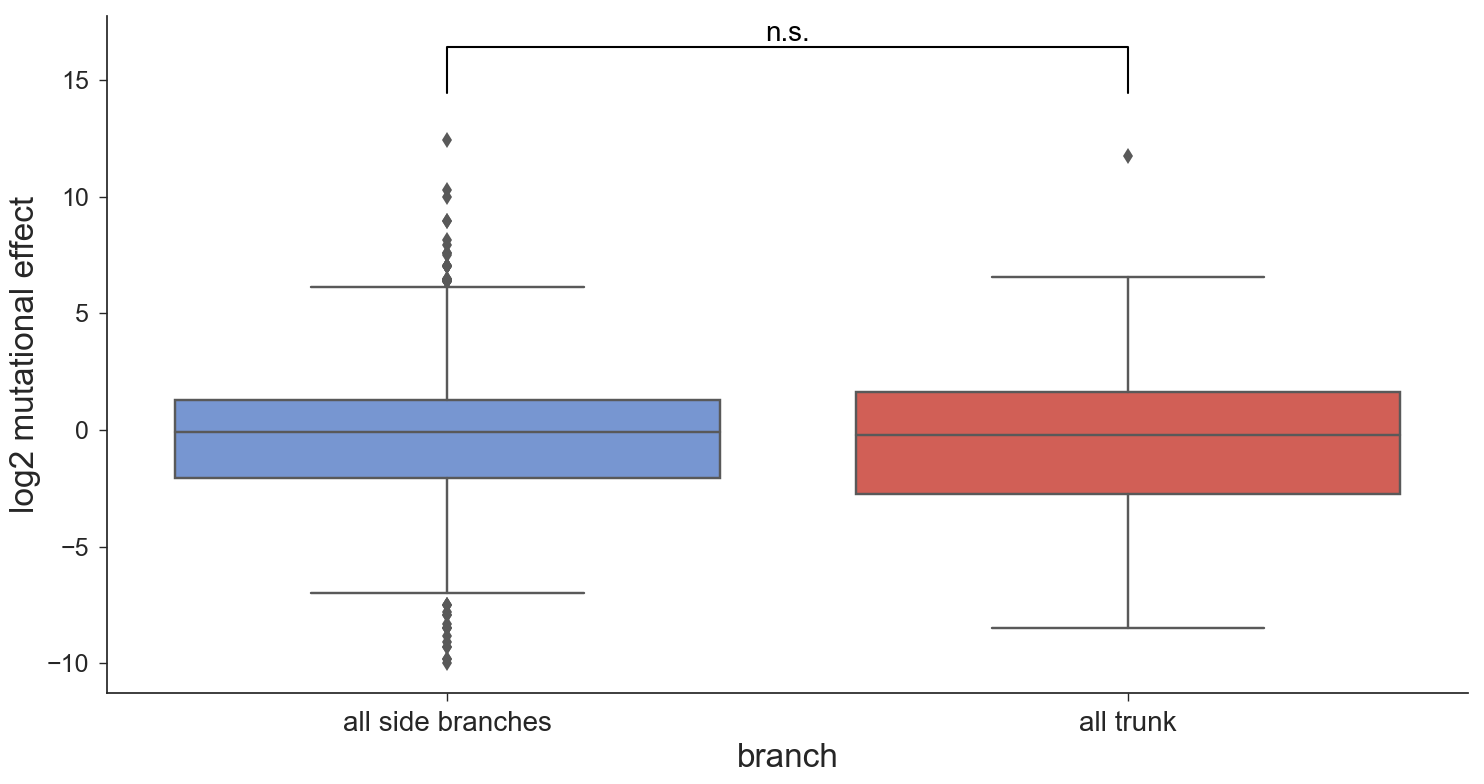

In [152]:
sns.set()
flatui = ['#6891e0', '#e54d42']
sns.color_palette(flatui)
sns.set_palette(flatui)
sns.set_style('white')
sns.set_style('ticks')
(fig, ax) = plt.subplots(figsize=(15,8))
g = sns.boxplot(data=h1n1_muteffects, fliersize=8)
g.set_xticklabels(['all side branches','all trunk'])
ax.set_xlabel('branch', fontsize = 24)
ax.set_ylabel('log2 mutational effect', fontsize = 24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=18)

x1, x2 = 0, 1
y, h, col = max(h1n1_muteffects[0] + h1n1_muteffects[1]) + 2, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "n.s.", ha='center', va='bottom', color=col, fontsize = 20)

sns.despine()
plt.tight_layout()
# plt.savefig('{0}/H1N1_allsidebr_vs_alltrunk.pdf'.format(plotsdir), format='pdf')
plt.show()

In [153]:
h1n1_nodes_muteffects = []
h1n1_nodes_muteffects.append([e for e in np.log2(h1n1_termnode_muts_effects)])
h1n1_nodes_muteffects.append([e for e in np.log2(h1n1_intnode_muts_effects)])
h1n1_nodes_muteffects.append([e for e in np.log2(h1n1_trunk_muts_effects)])

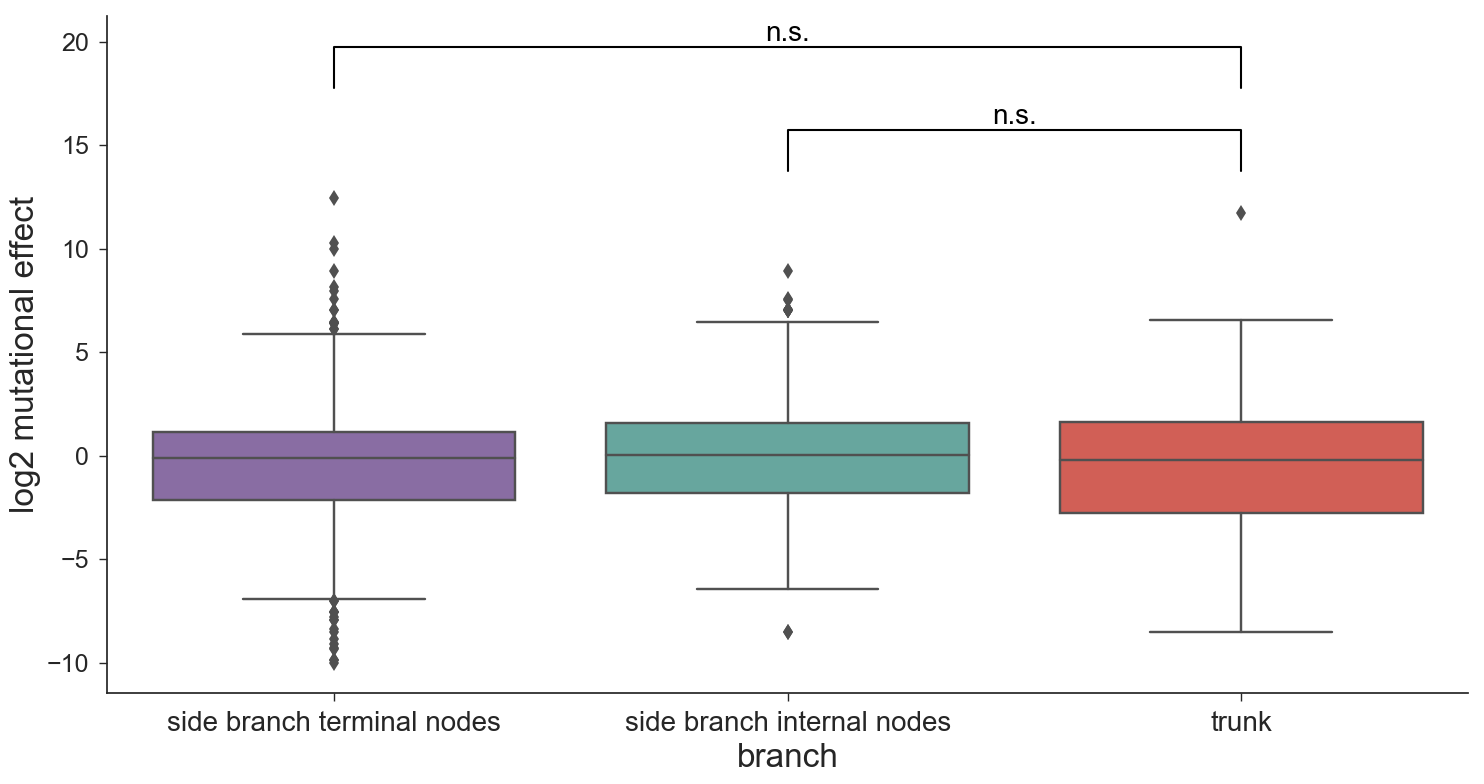

In [154]:
sns.set()
triplet = ['#8964ac', '#5cb0a6', '#e54d42']
sns.color_palette(triplet)
sns.set_palette(triplet)
sns.set_style('white')
sns.set_style('ticks')
(fig, ax) = plt.subplots(figsize=(15,8))
g = sns.boxplot(data=h1n1_nodes_muteffects, fliersize=8)
g.set_xticklabels(['side branch terminal nodes','side branch internal nodes','trunk'])
ax.set_xlabel('branch', fontsize = 24)
ax.set_ylabel('log2 mutational effect', fontsize = 24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=18)

y, h, col = max(h1n1_nodes_muteffects[1] + h1n1_nodes_muteffects[2]) + 2, 2, 'k'
plt.plot([1, 1, 2, 2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.plot([0, 0, 2, 2], [y+h+h, y+h+h+h, y+h+h+h, y+h+h], lw=1.5, c=col)
plt.text((1+2)*.5, y+h, "n.s.", ha='center', va='bottom', color=col, fontsize = 20)
plt.text((0+2)*.5, y+h+h+h, "n.s.", ha='center', va='bottom', color=col, fontsize = 20)

sns.despine()
plt.tight_layout()
# plt.savefig('{0}/H1N1_int_termnodes_trunk.pdf'.format(plotsdir), format='pdf')
plt.show()

In [155]:
# Create a lookup table of nodes by name.
h1n1_nodes_by_name = dict([(node.name, node) for node in h1n1_tree.find_clades()])

In [156]:
# Window size in years.
window_size = 4

# Sliding size in years.
window_slide = 4

# Interval length in years (end year - start year).
interval_length = 2010 - 1918

In [157]:
windows = list(make_windows(interval_length, window_size, window_slide, start=1918))

In [158]:
# Assign each node to one of the non-overlapping windows.
for node in h1n1_tree.find_clades():
    for window in windows:
        # Is this node in the current window?
        if node.attr["num_date"] >= window[0] and node.attr["num_date"] < window[1]:
            node.attr["window"] = window
            break

In [159]:
# Confirm that every node is assigned to a window.
[node.attr["num_date"] for node in h1n1_tree.find_clades() if "window" not in node.attr]

[]

In [160]:
WSNprefsdf = pd.read_csv("./data/WSN_avgprefs_rescaled.csv")

# Convert 1-based positions to 0-based positions.
WSNprefsdf["HA_position"] = WSNprefsdf["site"] - 1
WSNprefsdf = WSNprefsdf.set_index("HA_position")
WSNprefsdf = WSNprefsdf.drop(columns="site")

In [161]:
WSN_stacked_preferences = WSNprefsdf.stack()

In [162]:
# Define sites to calculate sequence preference across.
positions = list(range(2, len(h1n1_tree.root.aa_sequence)))

In [163]:
for node in h1n1_tree.find_clades():
    node.attr["tol"] = calc_tolerance(node.aa_sequence, WSN_stacked_preferences, positions) / len(positions)

In [164]:
wsn_aa_sequence = """MKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTIFEKNVAVT
                     HSVNLLEDRHNGKLCKLKGIAPLQLGKCNITGWLLGNPECDSLLPARSWSYIVETPNS
                     ENGACYPGDFIDYEELREQLSSVSSLERFEIFPKESSWPNHTFNGVTVSCSHRGKSSF
                     YRNLLWLTKKGDSYPKLTNSYVNNKGKEVLVLWGVHHPSSSDEQQSLYSNGNAYVSVA
                     SSNYNRRFTPEIAARPKVKDQHGRMNYYWTLLEPGDTIIFEATGNLIAPWYAFALSRG
                     FESGIITSNASMHECNTKCQTPQGSINSNLPFQNIHPVTIGECPKYVRSTKLRMVTGL
                     RNIPSIQYRGLFGAIAGFIEGGWTGMIDGWYGYHHQNEQGSGYAADQKSTQNAINRIT
                     NKVNSVIEKMNTQFTAVGKEFNNLEKRMENLNKKVDDGFLDIWTYNAELLVLLENERT
                     LDFHDLNVKNLYEKVKSQLKNNAKEIGNGCFEFYHKCDNECMESVRNGTYDYPKYSEE
                     SKLNREKIDGVKLESMGVYQILAIYSTVASSLVLLVSLGAISFWMCSNGSLQCRICI"""

In [165]:
wsn_aa_sequence = "".join(wsn_aa_sequence.split())

In [166]:
# Confirm that all node amino acid sequences match the WSN sequence length.
all([len(node.aa_sequence) == len(wsn_aa_sequence) for node in h1n1_tree.find_clades()])

True

In [167]:
wsn_tolerance = calc_tolerance(wsn_aa_sequence, WSN_stacked_preferences, positions) / len(positions)

In [173]:
# Collect sequence preference, date, and trunk status for each
# node prior to the MRCA of all recent nodes.
h1n1_nodes = []
for node in h1n1_tree.find_clades():
    if (node not in h1n1_unresolved_nodes): # and (node.is_trunk or node.is_side_branch_ancestor):
        h1n1_nodes.append({
            "preference": node.attr["tol"],
            "date": node.attr["num_date"],
            "trunk": node.is_trunk,
            "terminal": node.is_terminal(),
            "name": node.name,
            "parent_date": node.parent is not None and node.parent.attr["num_date"] or 0,
            "parent_preference": node.parent is not None and node.parent.attr["tol"] or 0,
            "window": node.attr["window"]
        })

In [174]:
h1n1_preference_df = pd.DataFrame(h1n1_nodes)

In [175]:
h1n1_preference_df["year"] = h1n1_preference_df["date"].apply(lambda date: int(np.floor(date)))

In [176]:
def plot_preference_tree(ax, segments, trunk_preference, non_trunk_preference, dms_preference):
    # Draw line segments between each node and its parent to represent the tree.
    lc = LineCollection(segments, zorder=1)
    lc.set_alpha(0.6)
    lc.set_color("black")
    lc.set_linewidth(1)
    ax.add_collection(lc)

    # Draw non-trunk (side branch) nodes.
    ax.scatter(
        non_trunk_preference["date"],
        non_trunk_preference["preference"],
        s=40,
        c=colors[-2],
        alpha=0.5,
        label="Side branch"
    )

    # Draw trunk nodes.
    ax.scatter(
        trunk_preference["date"],
        trunk_preference["preference"],
        s=40,
        c=colors[-1],
        alpha=1,
        label="Trunk"
    )

    ax.scatter(
        [1933.0 + 27],
        [wsn_tolerance],
        s=150,
        c=colors[2],
        marker="*",
        zorder=10,
        label="A/WSN/1933"
    )
    
    # Label axes.
    ax.set_xlabel("Time")
    ax.set_ylabel("Sequence preference")

    # Fix y-axis tick units.
    #ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    
    # Add legend.
    ax.legend()

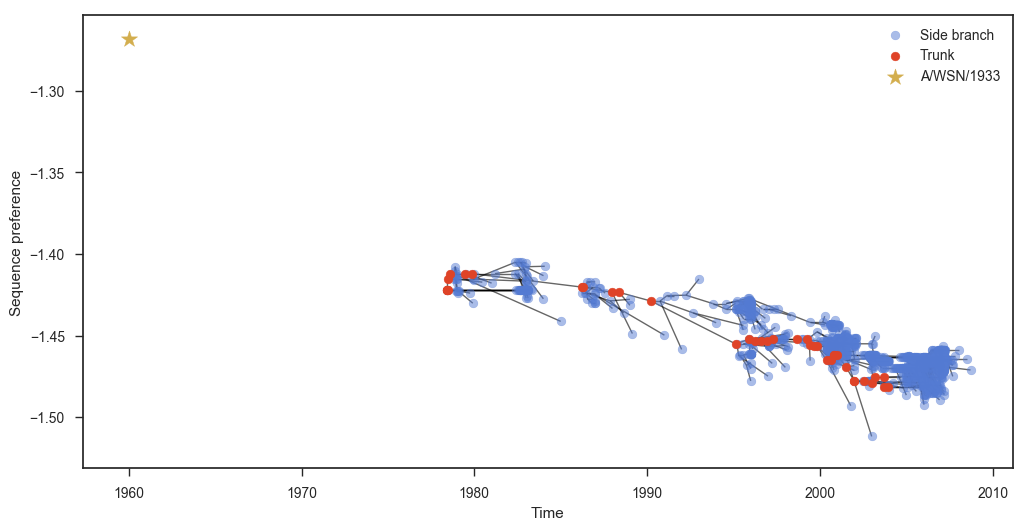

In [177]:
from matplotlib import gridspec

trunk_preference = h1n1_preference_df[h1n1_preference_df["trunk"] == True].copy()
non_trunk_preference = h1n1_preference_df[(h1n1_preference_df["trunk"] == False)].copy()
dms_preference = h1n1_preference_df[h1n1_preference_df["name"] == "A/WSN/1933"]

# Build a list of lines for each preference entry from one node to its parent.
segments = h1n1_preference_df[h1n1_preference_df["parent_date"] > 0].apply(
    lambda row: [(row["date"], row["preference"]), (row["parent_date"], row["parent_preference"])],
    axis=1
).values

fig = plt.subplots(figsize=(12, 6), facecolor='w')

gs = gridspec.GridSpec(1, 1, height_ratios=[1], width_ratios=[1], hspace=0.25, wspace=0.1)

# Plot complete tree.
ax = plt.subplot(gs[0])
plot_preference_tree(ax, segments, trunk_preference, non_trunk_preference, dms_preference)

plt.show()

# Section 3: Compare the preferences between the HA homologs

In this section, we will compare the preferences between the two HA homologs: Perth/2009 H3 and WSN/1933 H1. The WSN/1933 HA preferences were previously measured in [Doud and Bloom (2016)](http://www.mdpi.com/1999-4915/8/6/155).

First, we need to renumber and rescale the preferences so that we can make comparisons between the two HA homologs. I aligned the Perth/2009 H3 and WSN/1933 H1 amino-acid sequences using `mafft`. I will renumber each of the preferences file based on the alignment and remove sites that do not align. The renumbering files are provided in the [`./data/`](./data/) directory as `[homolog]_compareprefs_renumber.csv`, where `\[homolog\]` is Perth2009 or WSN.

In [16]:
# the homologs that we are examining
homologs = ['Perth', 'WSN']

# Average across the two technical replicates of replicate 3
rep3df = dms_tools2.prefs.avgPrefs(glob.glob('{0}/replicate-3-*_prefs.csv'.format(prefsdir)))
rep3df.to_csv('{0}/replicate-3_prefs.csv'.format(prefsdir), index=False)

# Renumber unscaled preferences
Perth_renumbfile = './data/Perth2009_compareprefs_renumber.csv'
dms_tools2.utils.renumberSites(Perth_renumbfile, 
                               sorted(glob.glob('{0}/replicate-?_prefs.csv'.format(prefsdir))), 
                               missing='drop', 
                               outprefix='renum_')

WSN_renumbfile = './data/WSN_compareprefs_renumber.csv'
dms_tools2.utils.renumberSites(WSN_renumbfile, 
                               sorted(glob.glob('{0}/replicate-?_prefs.csv'.format(WSNprefsdir))), 
                               missing='drop', 
                               outprefix='renum_')

# Rescale WSN HA preferences
WSN_stringency = 2.05
for r in [1, 2, 3]:
    unscaled = '{0}/renum_replicate-{1}_prefs.csv'.format(WSNprefsdir, r)
    rescaled = os.path.join(prefsdistdir, 'WSN_replicate-{0}_prefs_rescaled.csv'.format(r))
    (dms_tools2.prefs.rescalePrefs(pd.read_csv(unscaled), WSN_stringency)
            .to_csv(rescaled, index=False))
    
# Rescale Perth/2009 HA preferences
for r in [1, 2, 3]:
    unscaled = '{0}/renum_replicate-{1}_prefs.csv'.format(prefsdir, r)
    rescaled = os.path.join(prefsdistdir, 'Perth_replicate-{0}_prefs_rescaled.csv'.format(r))
    (dms_tools2.prefs.rescalePrefs(pd.read_csv(unscaled), beta)
            .to_csv(rescaled, index=False))

### Correlate the Perth/2009 H3 and WSN/1933 H1 preferences

First, we will examine the correlations between Perth/2009 and WSN HA preferences.

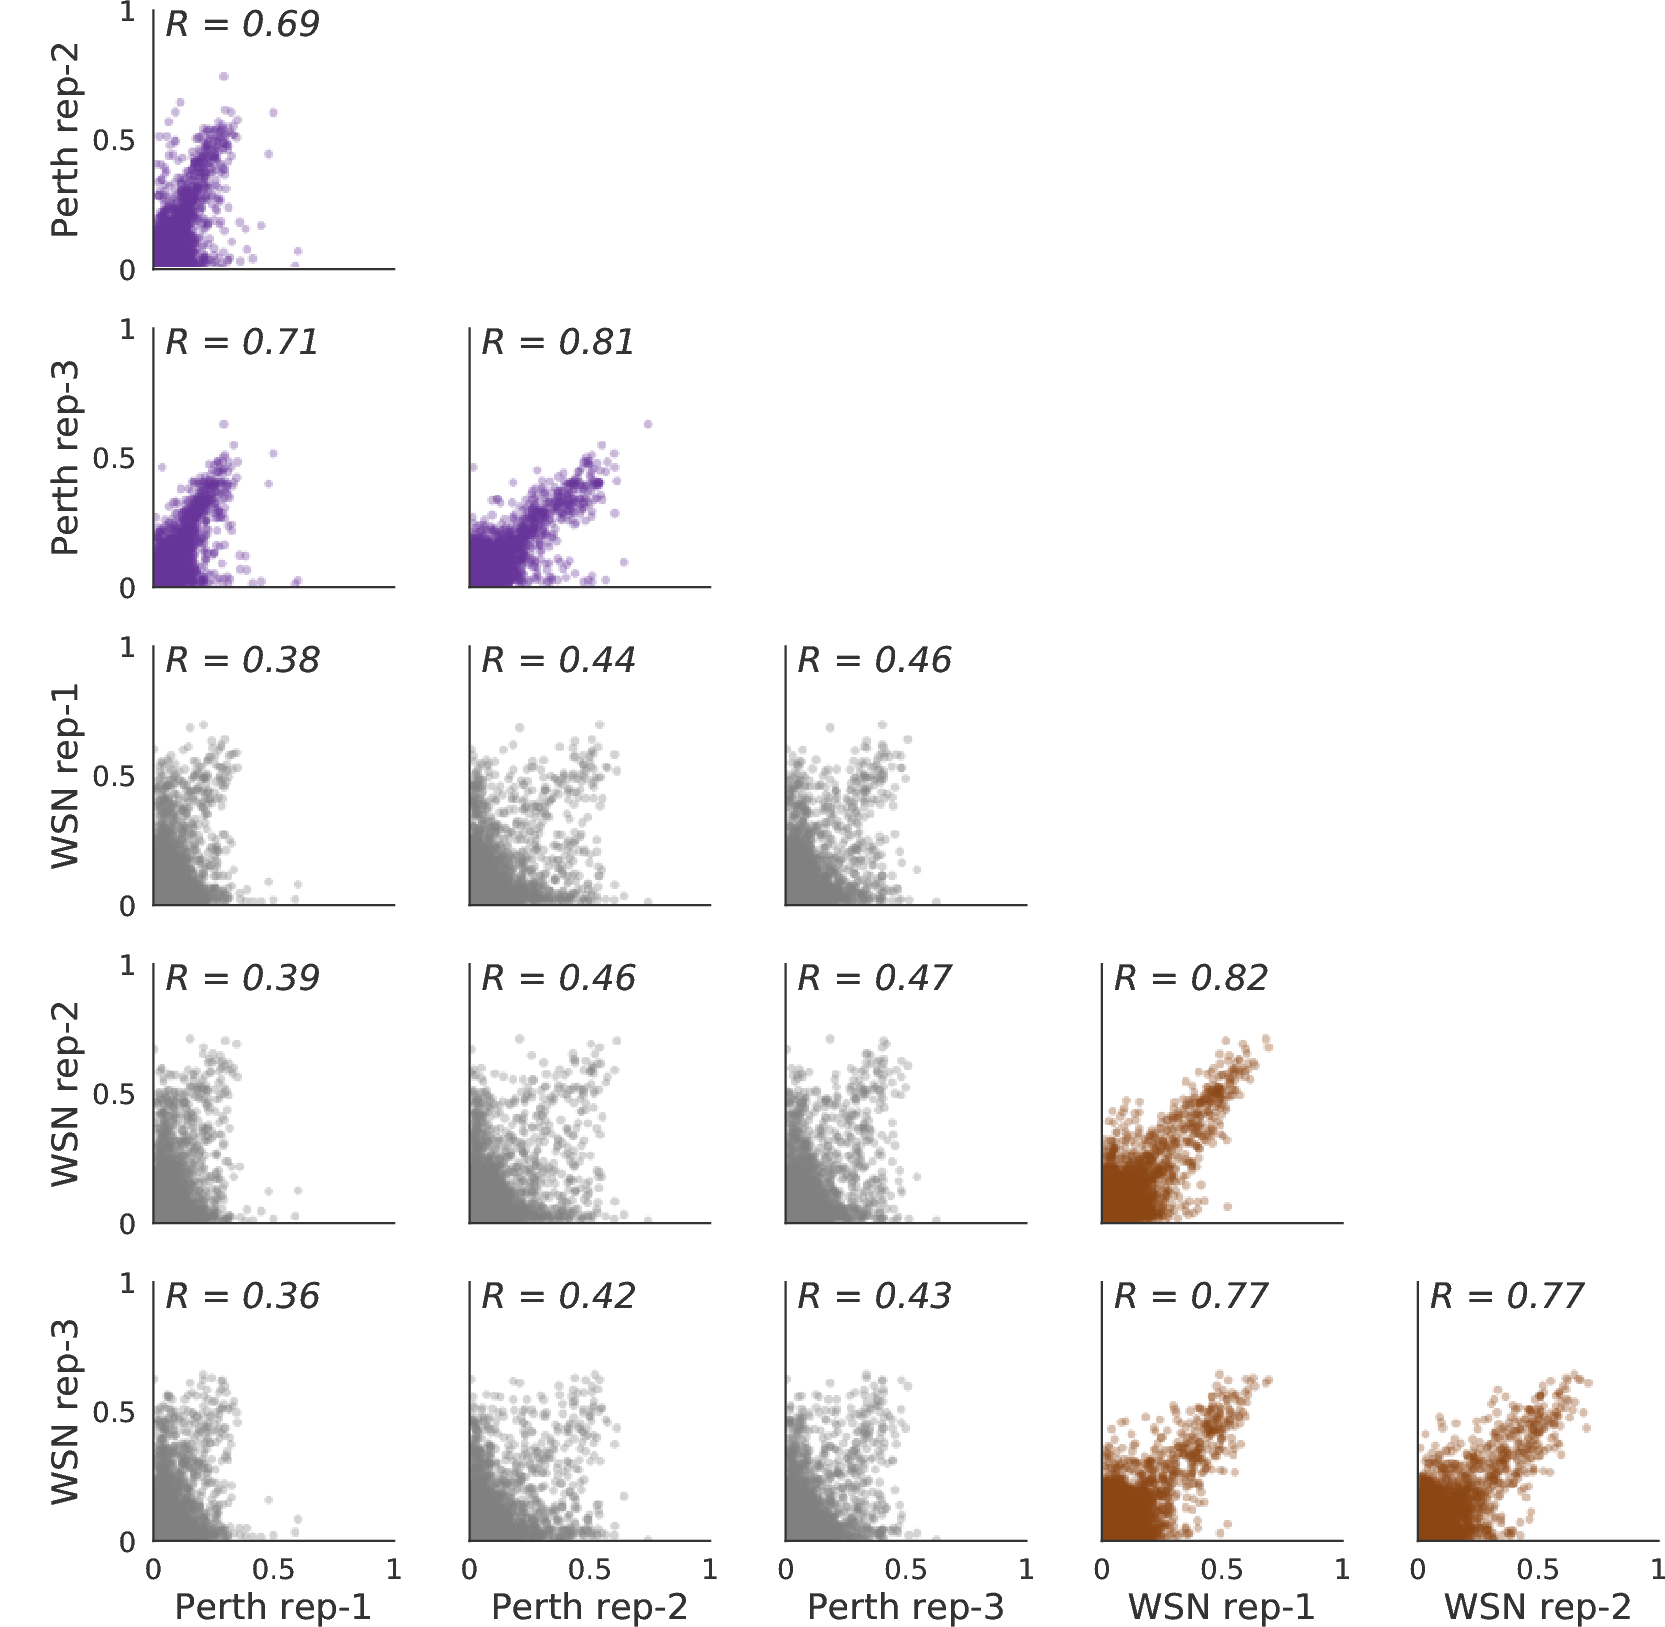

In [17]:
homolog_corrs = os.path.join(prefsdistdir, 'homolog_correlations.pdf')

prefs_names = ['WSN rep-1', 'WSN rep-2', 'WSN rep-3', 
               'Perth rep-1', 'Perth rep-2', 'Perth rep-3']

allHAprefs = glob.glob('{0}/renum_replicate-*_prefs.csv'.format(prefsdir)) \
                + glob.glob('{0}/renum_replicate-*_prefs.csv'.format(WSNprefsdir))

# how to color scatter plots depending on which homologs
# this will break for different numbers of homologs
colors = ['rebeccapurple'] * 3 + ['gray'] * 6 + ['saddlebrown'] + ['gray'] * 3 + ['saddlebrown'] * 2

dms_tools2.plot.plotCorrMatrix(prefs_names, 
                               sorted(allHAprefs), 
                               homolog_corrs, 
                               'prefs', 
                               trim_unshared=True, 
                               colors=colors)

showPDF(homolog_corrs)

### Compute the distances between preferences

In order to quantitatively compare the preferences, we will use the `compareprefs` module of `dms_tools2` to compute $RMSD_{corrected}$ values that allow us to account for experimental noise in the measurements within a given homolog.

In [18]:
# distances between the two HA homologs
assert len(homologs) == 2, "plotting needs to be refactored if > 2 homologs"
prefs1 = glob.glob('{0}/Perth_replicate-*_prefs_rescaled.csv'.format(prefsdistdir))
prefs2 = glob.glob('{0}/WSN_replicate-*_prefs_rescaled.csv'.format(prefsdistdir))

prefsdist = dms_tools2.compareprefs.comparePrefs(prefs1, prefs2)
prefsdistfile = os.path.join(prefsdistdir, '{0}_to_{1}_prefs_dist.csv'.format(*homologs))
prefsdist.to_csv(prefsdistfile, index=False)

# distances for all randomizations of 3 replicates per homolog
rand_dists = []
assert len(prefs1) == len(prefs2) == 3, "code expects 3 replicates / homologs"
for set1 in itertools.combinations(prefs1 + prefs2, 3):
    set2 = [iprefs for iprefs in prefs1 + prefs2 if iprefs not in set1]
    rand_dists += (dms_tools2.compareprefs.comparePrefs(set1, set2)
                      ['RMSDcorrected'].tolist())

# distances from each homolog to BF520 Env prefs
env_prefs = glob.glob('{0}/Env_BF520_replicate-*_prefs_rescaled.csv'.format(prefsdistdir))
ha_env_dist = {}
for (homolog, homologprefs) in zip(homologs, [prefs1, prefs2]):
    ha_env_dist[homolog] = (dms_tools2.compareprefs.comparePrefs(env_prefs, homologprefs)['RMSDcorrected'].tolist())
    
# read in distances for Env homologs
env_dists = (pd.read_csv('./results/prefsdist/BG505_to_BF520_prefs_dist.csv'))['RMSDcorrected'].tolist()

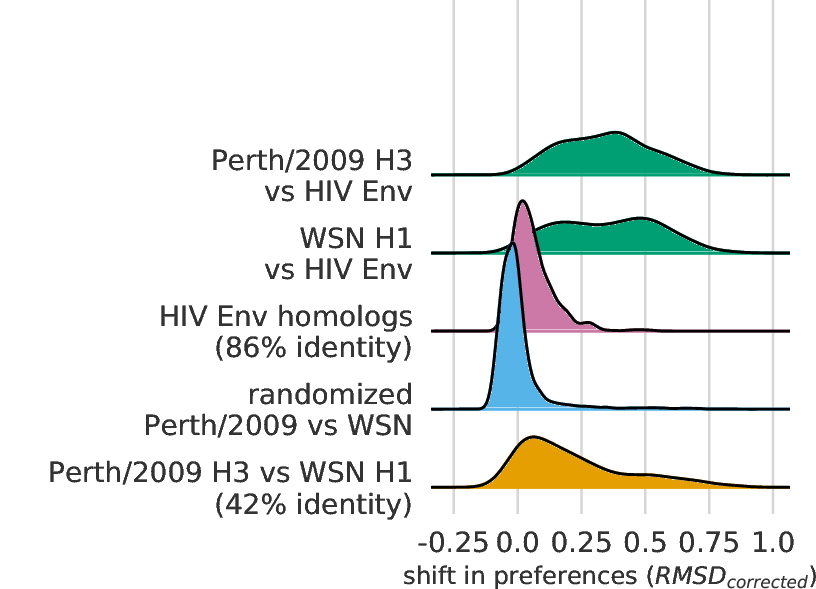

In [21]:
distplot = os.path.join(prefsdistdir, 'distance_distribution.pdf')

actual_dists = prefsdist['RMSDcorrected'].tolist()

# the data to plot
joyplot_data = collections.OrderedDict([
                ('Perth/2009 H3\n vs HIV Env', ha_env_dist[homologs[0]]),
                ('WSN H1\n vs HIV Env', ha_env_dist[homologs[1]]),
                ('HIV Env homologs\n (86% identity)', env_dists),
                ('randomized\n Perth/2009 vs WSN', rand_dists),
                ('Perth/2009 H3 vs WSN H1\n (42% identity)', actual_dists)])
    
# colors for each comparison: same color for the two HA comparisons
cmap = mpl.colors.ListedColormap(["#009E73", "#009E73", "#CC79A7", "#56B4E9", "#E69F00"])

# make the joyplot
joypy.joyplot(joyplot_data,
              grid='x',
              overlap=1,
              linewidth=1.5,
              figsize=(6, 4.8),
              colormap = cmap,
             )
plt.xlabel('shift in preferences ($RMSD_{corrected}$)', size=13)

# save and show
plt.savefig(distplot)
showPDF(distplot, width=600)

In [22]:
# compute P-values
rand_dists = np.array(rand_dists)
actual_dists = sorted(actual_dists, reverse=True)
n = float(len(rand_dists))
pvals = [np.greater_equal(rand_dists, d).sum() / n for d in actual_dists]
assert pvals == sorted(pvals), "pvals should be sorted if actual_dists sorted"

# get minimum distance at which we reject null at FDR of 0.1
fdr = 0.1
reject = statsmodels.stats.multitest.multipletests(
          pvals, alpha=fdr, method='fdr_bh')[0].tolist()
assert any(reject), "no significants sites at FDR, rest of code won't work"
min_dist = actual_dists[reject.index(False) - 1]
print("At FDR of {0}, we consider homolog-to-homolog diffs significant if they "
      "exceed {1:.3f}. There are {2} such sites out of {3} total.".format(
      fdr, min_dist, sum(reject), len(actual_dists)))

At FDR of 0.1, we consider homolog-to-homolog diffs significant if they exceed 0.306. There are 147 such sites out of 552 total.


### Examine mutational shifts at different domains and sites

Now we will examine the extent of mutational shifts in the head vs stalk domains. The demarcation between the head and stalk domains is defined by a disulfide bridge formed by two cysteines at sites 52 and 277 (H3 numbering). 

In addition, based on a multiple sequence alignment of all 18 HA subtypes, there were 94 sites that were absolutely conserved across all the subtypes, so we will look at the distribution of distances for these conserved sites.

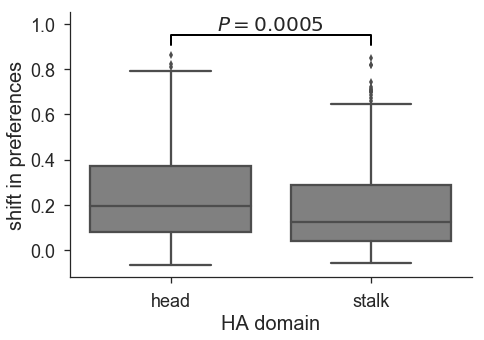

In [24]:
for i, row in prefsdist.iterrows():
    if int(i) in range(59,279):
        prefsdist.set_value(i, 'domain', 'head')
    else:
        prefsdist.set_value(i, 'domain', 'stalk')

# Now plot the shifts in preferences for the two HA domains
sns.set_style('white')
sns.set_style('ticks')
(fig, ax) = plt.subplots(figsize=(7,5))
sns.boxplot(x='domain', 
            y='RMSDcorrected', 
            data=prefsdist, 
            order = ['head', 'stalk'],
            color='gray')

plt.ylabel('shift in preferences', fontsize=20)
plt.xlabel('HA domain', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Calculate significance
p = scipy.stats.mannwhitneyu(
        prefsdist.loc[prefsdist['domain'] == 'head']['RMSDcorrected'], 
        prefsdist.loc[prefsdist['domain'] == 'stalk']['RMSDcorrected']
        )[1]
(x1, x2) = (0, 1)
yextend = 1.05
y = prefsdist.RMSDcorrected.max() * yextend
plt.plot([x1, x1, x2, x2], [y, yextend * y, yextend * y, y], c='black', lw=2)
plt.text((x1 + x2) / 2, y * yextend, '$P = {0:.4f}$'.format(p), 
         ha='center', va='bottom', size=20)
ax.set_ylim(top=y*(yextend**3))

sns.despine()
plt.tight_layout()
# plt.savefig('{0}/HAdomains_vs_shifts.pdf'.format(prefsdistdir), format='pdf')
plt.show()

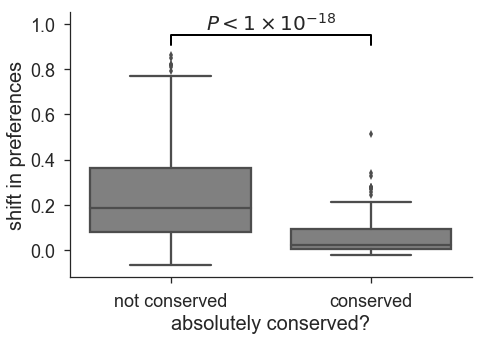

In [25]:
abs_conserved_sites = [s.strip() for s in (open('./data/abs_conserved_sites.txt', 'r')).readlines()]

for i, row in prefsdist.iterrows():
    if str(i+1) in abs_conserved_sites:
        prefsdist.set_value(i, 'abs_conserved', 'conserved')
    else:
        prefsdist.set_value(i, 'abs_conserved', 'not conserved')

# Now plot the shifts in preferences for the two classes
sns.set_style('white')
sns.set_style('ticks')
(fig, ax) = plt.subplots(figsize=(7,5))
sns.boxplot(x='abs_conserved', 
            y='RMSDcorrected', 
            data=prefsdist,
            color='gray')

plt.ylabel('shift in preferences', fontsize=20)
plt.xlabel('absolutely conserved?', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Calculate significance
p = scipy.stats.mannwhitneyu(
        prefsdist.loc[prefsdist['abs_conserved'] == 'conserved']['RMSDcorrected'], 
        prefsdist.loc[prefsdist['abs_conserved'] == 'not conserved']['RMSDcorrected']
        )[1]
(x1, x2) = (0, 1)
yextend = 1.05
y = prefsdist.RMSDcorrected.max() * yextend
plt.plot([x1, x1, x2, x2], [y, yextend * y, yextend * y, y], c='black', lw=2)
plt.text((x1 + x2) / 2, y * yextend, r'$P < 1 \times 10^{-18}$', 
         ha='center', va='bottom', size=20)
ax.set_ylim(top=y*(yextend**3))

sns.despine()
plt.tight_layout()
# plt.savefig('{0}/Conserved_vs_shifts.pdf'.format(prefsdistdir), format='pdf')
plt.show()

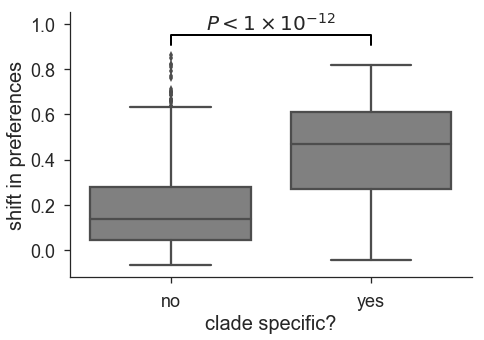

In [27]:
clade_specific_sites = [s.strip() for s in (open('./data/clade_specific_sites.txt', 'r')).readlines()]

for i, row in prefsdist.iterrows():
    if str(i+1) in clade_specific_sites:
        prefsdist.set_value(i, 'clade_specific', 'yes')
    else:
        prefsdist.set_value(i, 'clade_specific', 'no')

# Now plot the shifts in preferences for the two classes
sns.set_style('white')
sns.set_style('ticks')
(fig, ax) = plt.subplots(figsize=(7,5))
sns.boxplot(x='clade_specific', 
            y='RMSDcorrected', 
            data=prefsdist,
            color='gray')

plt.ylabel('shift in preferences', fontsize=20)
plt.xlabel('clade specific?', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Calculate significance
p = scipy.stats.mannwhitneyu(
        prefsdist.loc[prefsdist['clade_specific'] == 'yes']['RMSDcorrected'], 
        prefsdist.loc[prefsdist['clade_specific'] == 'no']['RMSDcorrected']
        )[1]
(x1, x2) = (0, 1)
yextend = 1.05
y = prefsdist.RMSDcorrected.max() * yextend
plt.plot([x1, x1, x2, x2], [y, yextend * y, yextend * y, y], c='black', lw=2)
plt.text((x1 + x2) / 2, y * yextend, r'$P < 1 \times 10^{-12}$', 
         ha='center', va='bottom', size=20)
ax.set_ylim(top=y*(yextend**3))

sns.despine()
plt.tight_layout()
# plt.savefig('{0}/clade_specific_shifts.pdf'.format(prefsdistdir), format='pdf')
plt.show()